## Result Analysis and Visuals

In [3]:
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datasets import load_dataset
import seaborn as sns
import re
from collections import defaultdict
from IPython.display import display, HTML


/home/robin/Research/qtype-eval/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### dataset table

In [4]:
dataset = load_dataset("rokokot/question-type-and-complexity", name="base", split="train")
lang_map = {
'ar': 'Arabic', 'en': 'English', 'fi': 'Finnish',
'id': 'Indonesian', 'ja': 'Japanese',
'ko': 'Korean', 'ru': 'Russian'
}

splits = ['train', 'validation', 'test']
all_results = []

for split in splits:
  dataset = load_dataset('rokokot/question-type-and-complexity', name='base', split=split)
  
  for lang in list(lang_map.keys()):
    lang_data = dataset.filter(lambda x: x['language'] == lang)

    n_questions = len(lang_data)

    question_types = lang_data['question_type']

    polar_count = sum(1 for qt in question_types if qt == 1)
    content_count = sum(1 for qt in question_types if qt == 0)

    polar_pct = round((polar_count / n_questions) * 100, 1)
    content_pct = round((content_count / n_questions) * 100, 1)

    avg_complexity = round(np.mean(lang_data['complexity_score']), 2)

    all_results.append({
        'Language': lang_map[lang],
        'Questions': n_questions,
        'Polar (%)': polar_pct,
        'Content (%)': content_pct,
        'Avg. Complexity': avg_complexity
    })

stats_df = pd.DataFrame(all_results)
print(stats_df.to_string(index=False))

  Language  Questions  Polar (%)  Content (%)  Avg. Complexity
    Arabic        995       49.9         50.1             1.50
   English       1192       50.0         50.0             1.60
   Finnish       1195       50.0         50.0             1.37
Indonesian        954       47.9         52.1             1.86
  Japanese       1191       50.0         50.0             1.60
    Korean        739       46.1         53.9             1.97
   Russian       1194       50.0         50.0             1.76
    Arabic         44       45.5         54.5             1.73
   English         72       50.0         50.0             1.74
   Finnish         63       47.6         52.4             1.64
Indonesian         72       50.0         50.0             2.01
  Japanese         46       52.2         47.8             1.71
    Korean         72       50.0         50.0             2.05
   Russian         72       50.0         50.0             1.83
    Arabic         77       28.6         71.4          

In [5]:

def analyze_dataset_with_averages():
    splits = ["train", "validation", "test"]
    lang_map = {
        'ar': 'Arabic', 'en': 'English', 'fi': 'Finnish',
        'id': 'Indonesian', 'ja': 'Japanese',
        'ko': 'Korean', 'ru': 'Russian'
    }
    
    # Dictionary to accumulate results for all languages
    combined_stats = {lang: {'Questions': 0, 'Polar': 0, 'Content': 0, 'Complexity': []} 
                     for lang in lang_map.values()}
    
    total_questions = 0

    # Process each split
    for split in splits:
        try:
            dataset = load_dataset("rokokot/question-type-and-complexity", name="base", split=split)
            print(f"Processing {split} split with {len(dataset)} examples...")
            
            for lang_code, lang_name in lang_map.items():
                # Filter dataset for specific language
                lang_data = dataset.filter(lambda x: x['language'] == lang_code)
                
                # Skip if no data for this language in this split
                if len(lang_data) == 0:
                    print(f"No data for {lang_name} in {split} split")
                    continue
                
                combined_stats[lang_name]['Questions'] += len(lang_data)
                total_questions += len(lang_data)
                
                question_types = lang_data['question_type']
                polar_count = sum(1 for qt in question_types if qt == 1)
                combined_stats[lang_name]['Polar'] += polar_count
                combined_stats[lang_name]['Content'] += (len(lang_data) - polar_count)
                
                combined_stats[lang_name]['Complexity'].extend(lang_data['complexity_score'])
                
        except Exception as e:
            print(f"Error processing {split} split: {e}")
    
    # Calculate averages and percentages
    results = []
    for lang_name, stats in combined_stats.items():
        if stats['Questions'] > 0:
            polar_pct = round((stats['Polar'] / stats['Questions']) * 100, 1)
            content_pct = round((stats['Content'] / stats['Questions']) * 100, 1)
            avg_complexity = round(np.mean(stats['Complexity']), 2) if stats['Complexity'] else 0
            dataset_pct = round((stats['Questions'] / total_questions) * 100, 1)

            
            results.append({
                'Language': lang_name,
                'Dataset %': dataset_pct,
                'Polar %': polar_pct,
                'Content %': content_pct,
                'Avg. Complexity': avg_complexity
            })
    
    # Create dataframe from results
    stats_df = pd.DataFrame(results)
    
    return stats_df

stats_df = analyze_dataset_with_averages()
print(stats_df.to_string(index=False))


Processing train split with 7460 examples...
Processing validation split with 441 examples...
Processing test split with 719 examples...
  Language  Dataset %  Polar %  Content %  Avg. Complexity
    Arabic       12.9     48.3       51.7             1.55
   English       15.9     50.0       50.0             1.61
   Finnish       15.9     49.9       50.1             1.40
Indonesian       13.2     48.2       51.8             1.88
  Japanese       15.4     50.8       49.2             1.66
    Korean       10.7     46.9       53.1             1.98
   Russian       16.0     50.0       50.0             1.76


In [ ]:
def load_and_prepare_data(filepath='/home/robin/Research/qtype-eval/scripts/visualization/combined_results/analysis_output/result_table.csv'):
    df = pd.read_csv(filepath)
    return df

def create_model_performance_tables(df):
    unique_tasks = df['task'].unique()
    unique_model_types = df['model_type'].unique()
    unique_metrics = df['metric'].unique()
    unique_splits = df['split'].unique()
    unique_submetrics = [sm for sm in df['submetric'].unique() if sm and pd.notna(sm)]  # Filter empty submetrics
    
    for task in unique_tasks:
        for model_type in unique_model_types:
            for split in unique_splits:
                task_model_split_df = df[(df['task'] == task) & 
                                         (df['model_type'] == model_type) & 
                                         (df['split'] == split)]
                
                if task_model_split_df.empty:
                    continue
                
                is_lm_probe = 'lm_probe' in model_type.lower() if isinstance(model_type, str) else False
                
                if is_lm_probe and 'layer' in df.columns and df['layer'].notna().any():
                    unique_layers = task_model_split_df['layer'].dropna().unique()
                    
                    for layer in unique_layers:
                        layer_df = task_model_split_df[task_model_split_df['layer'] == layer]
                        
                        if len(unique_submetrics) > 0 and any(layer_df['submetric'].notna()) and any(layer_df['submetric'] != ''):
                            for submetric in unique_submetrics:
                                submetric_df = layer_df[layer_df['submetric'] == submetric]
                                if not submetric_df.empty:
                                    for metric in unique_metrics:
                                        if metric in submetric_df['metric'].values:
                                            create_table_for_group(submetric_df, task, model_type, metric, split, submetric, layer)
                        else:
                            for metric in unique_metrics:
                                if metric in layer_df['metric'].values:
                                    create_table_for_group(layer_df, task, model_type, metric, split, None, layer)
                else:
                    has_submetrics = len(unique_submetrics) > 0 and any(task_model_split_df['submetric'].notna()) and any(task_model_split_df['submetric'] != '')
                    
                    if has_submetrics:
                        for submetric in unique_submetrics:
                            submetric_df = task_model_split_df[task_model_split_df['submetric'] == submetric]
                            if not submetric_df.empty:
                                for metric in unique_metrics:
                                    if metric in submetric_df['metric'].values:
                                        create_table_for_group(submetric_df, task, model_type, metric, split, submetric)
                    else:
                        for metric in unique_metrics:
                            if metric in task_model_split_df['metric'].values:
                                create_table_for_group(task_model_split_df, task, model_type, metric, split)

def create_table_for_group(group_df, task, model_type, metric, split, submetric=None, layer=None):
   
    metric_df = group_df[group_df['metric'] == metric]
    
    if metric_df.empty:
        return
    
    languages = sorted(metric_df['language'].unique())
    
    table_data = []
    
    for lang in languages:
        lang_df = metric_df[metric_df['language'] == lang]
        
        # Real (non-control) value
        real_value = lang_df[lang_df['is_control'] == False]['value'].values
        real_val = real_value[0] if len(real_value) > 0 else np.nan
        
        # Control values
        control_values = []
        for control_idx in [1.0, 2.0, 3.0]:
            control_df = lang_df[(lang_df['is_control'] == True) & 
                                 (lang_df['control_index'] == control_idx)]
            control_val = control_df['value'].values[0] if not control_df.empty else np.nan
            control_values.append(control_val)
        
        # Add to table data
        row = [lang, real_val] + control_values
        table_data.append(row)
    
    # Create DataFrame
    columns = ['language', 'real', 'control1', 'control2', 'control3']
    table_df = pd.DataFrame(table_data, columns=columns)
    
    # Set language as index
    table_df.set_index('language', inplace=True)
    
    # Construct filename
    filename_parts = [task, model_type, metric, split]
    if submetric:
        filename_parts.append(submetric)
    if layer is not None:
        filename_parts.append(f"layer{int(layer)}")
    filename = '_'.join(filename_parts) + '_table.csv'
    
    # Save table to CSV
    table_df.to_csv(f'/home/robin/Research/qtype-eval/scripts/visualization/combined_results/experiment_tables/{filename}')
    
    # Print table
    title_parts = [task.capitalize(), model_type, metric.upper(), f"Split: {split}"]
    if submetric:
        title_parts.append(f"Submetric: {submetric}")
    if layer is not None:
        title_parts.append(f"Layer: {int(layer)}")
    title = " - ".join(title_parts)
    
    print(f"\n{title}")
    print("-" * len(title))
    print(table_df.round(4))

def debug_display_data(df, model_type_filter=None, task_filter=None, include_submetrics=True):
    """
    Helper function to display data relevant to debugging
    
    Parameters:
    df (DataFrame): The data frame to debug
    model_type_filter (str, optional): Model type to filter for
    task_filter (str, optional): Task to filter for
    include_submetrics (bool): Whether to show submetric details
    """
    debug_df = df.copy()
    
    if model_type_filter:
        debug_df = debug_df[debug_df['model_type'] == model_type_filter]
    
    if task_filter:
        debug_df = debug_df[debug_df['task'] == task_filter]
    
    if debug_df.empty:
        filter_description = []
        if model_type_filter:
            filter_description.append(f"model_type={model_type_filter}")
        if task_filter:
            filter_description.append(f"task={task_filter}")
        
        print(f"No data found for {', '.join(filter_description)}")
        return
    
    filter_description = []
    if model_type_filter:
        filter_description.append(f"model_type={model_type_filter}")
    if task_filter:
        filter_description.append(f"task={task_filter}")
    
    print(f"\nDEBUG: Data for {', '.join(filter_description) if filter_description else 'all data'}")
    print(f"Total rows: {len(debug_df)}")
    
    # Group by language, metric, and split to see what's available
    group_cols = ['language', 'metric', 'split']
    if include_submetrics and 'submetric' in debug_df.columns:
        group_cols.append('submetric')
    
    grouped = debug_df.groupby(group_cols).size().reset_index(name='count')
    print("\nAvailable combinations:")
    print(grouped)
    
    # Check for any missing values
    missing_vals = debug_df.isnull().sum()
    print("\nMissing values per column:")
    print(missing_vals[missing_vals > 0])
    
    # Check for unique submetrics
    if include_submetrics and 'submetric' in debug_df.columns:
        unique_submetrics = [sm for sm in debug_df['submetric'].unique() if sm and pd.notna(sm)]
        print("\nUnique submetrics:")
        print(unique_submetrics)

def main():
    """
    Main function to run the analysis and generate tables
    """
    print("Loading data...")
    df = load_and_prepare_data()
    
    # Optional: Debug the data
    debug_display_data(df)
    
    print("\nCreating model performance tables...")
    create_model_performance_tables(df)
    
    print("\nAnalysis complete. Tables have been generated.")

if __name__ == "__main__":
    main()

In [ ]:
import pandas as pd
import numpy as np

def load_and_prepare_data(filepath='/home/robin/Research/qtype-eval/scripts/visualization/combined_results/analysis_output/result_table.csv'):
    df = pd.read_csv(filepath)
    return df

def create_model_performance_tables(df):
    unique_tasks = df['task'].unique()
    unique_model_types = df['model_type'].unique()
    unique_metrics = df['metric'].unique()
    unique_splits = df['split'].unique()
    
    all_submetrics = df['submetric'].unique()
    
    for task in unique_tasks:
        for model_type in unique_model_types:
            for split in unique_splits:
                task_model_split_df = df[(df['task'] == task) & 
                                         (df['model_type'] == model_type) & 
                                         (df['split'] == split)]
                
                if task_model_split_df.empty:
                    continue
                
                is_lm_probe = 'lm_probe' in str(model_type).lower()
                
                if is_lm_probe and 'layer' in df.columns and df['layer'].notna().any():
                    unique_layers = task_model_split_df['layer'].dropna().unique()
                    
                    for layer in unique_layers:
                        layer_df = task_model_split_df[task_model_split_df['layer'] == layer]
                        
                        layer_submetrics = layer_df['submetric'].unique()
                        for submetric in layer_submetrics:
                            if pd.isna(submetric) or submetric == '':
                                submetric_df = layer_df[(layer_df['submetric'].isna()) | (layer_df['submetric'] == '')]
                            else:
                                submetric_df = layer_df[layer_df['submetric'] == submetric]
                            
                            if not submetric_df.empty:
                                for metric in unique_metrics:
                                    if metric in submetric_df['metric'].values:
                                        create_table_for_group(submetric_df, task, model_type, metric, split, 
                                            None if (pd.isna(submetric) or submetric == '') else submetric, 
                                            layer)
                else:
                    combination_submetrics = task_model_split_df['submetric'].unique()
                    
                    for submetric in combination_submetrics:
                        if pd.isna(submetric) or submetric == '':
                            submetric_df = task_model_split_df[(task_model_split_df['submetric'].isna()) | 
                                                               (task_model_split_df['submetric'] == '')]
                        else:
                            submetric_df = task_model_split_df[task_model_split_df['submetric'] == submetric]
                        
                        if not submetric_df.empty:
                            for metric in unique_metrics:
                                if metric in submetric_df['metric'].values:
                                    create_table_for_group(submetric_df, task, model_type, metric, split, None if (pd.isna(submetric) or submetric == '') else submetric)

def create_table_for_group(group_df, task, model_type, metric, split, submetric=None, layer=None):
    metric_df = group_df[group_df['metric'] == metric]
    
    if metric_df.empty:
        return
    languages = sorted(metric_df['language'].unique())
    table_data = []
    
    for lang in languages:
        lang_df = metric_df[metric_df['language'] == lang]
        real_value = lang_df[lang_df['is_control'] == False]['value'].values
        real_val = real_value[0] if len(real_value) > 0 else np.nan
        control_values = []
        for control_idx in [1.0, 2.0, 3.0]:
            control_df = lang_df[(lang_df['is_control'] == True) & 
                                 (lang_df['control_index'] == control_idx)]
            control_val = control_df['value'].values[0] if not control_df.empty else np.nan
            control_values.append(control_val)
        
        row = [lang, real_val] + control_values
        table_data.append(row)
    
    columns = ['language', 'real', 'control1', 'control2', 'control3']
    table_df = pd.DataFrame(table_data, columns=columns)
    table_df.set_index('language', inplace=True)
    filename_parts = [task, model_type, metric, split]
    if submetric:
        filename_parts.append(submetric)
    elif layer is not None:
        filename_parts.append("overall") 
    if layer is not None:
        filename_parts.append(f"layer{int(layer)}")
    filename = '_'.join(filename_parts) + '_table.csv'
    table_df.to_csv(f'/home/robin/Research/qtype-eval/scripts/visualization/combined_results/experiment_tables/{filename}')
    title_parts = [task.capitalize(), model_type, metric.upper(), f"Split: {split}"]
    if submetric:
        title_parts.append(f"Submetric: {submetric}")
    elif layer is not None:
        title_parts.append("Overall (no submetric)")  
    if layer is not None:
        title_parts.append(f"Layer: {int(layer)}")
    title = " - ".join(title_parts)
    
    print(f"\n{title}")
    print("-" * len(title))
    print(table_df.round(4))

def main():
   
    df = load_and_prepare_data()
    create_model_performance_tables(df)
    
if __name__ == "__main__":
    main()


Complexity - DummyRegressor - MSE - Split: val
----------------------------------------------
            real  control1  control2  control3
language                                      
ar        0.0649    0.0649    0.0649    0.0649
en        0.0468    0.0468    0.0468    0.0468
fi        0.0739    0.0739    0.0739    0.0739
id        0.0540    0.0540    0.0540    0.0540
ja        0.0668    0.0668    0.0668    0.0668
ko        0.0542    0.0542    0.0542    0.0542
ru        0.0618    0.0618    0.0618    0.0618

Complexity - DummyRegressor - RMSE - Split: val
-----------------------------------------------
            real  control1  control2  control3
language                                      
ar        0.2547    0.2547    0.2547    0.2547
en        0.2164    0.2164    0.2164    0.2164
fi        0.2719    0.2719    0.2719    0.2719
id        0.2324    0.2324    0.2324    0.2324
ja        0.2584    0.2584    0.2584    0.2584
ko        0.2328    0.2328    0.2328    0.2328
ru       

Successfully read /home/robin/Research/qtype-eval/scripts/analysis/question_type_DummyClassifier_accuracy_test_table.csv
Columns in Dummy dataframe: ['language', 'real', 'control1', 'control2', 'control3']
Successfully read /home/robin/Research/qtype-eval/scripts/analysis/question_type_LogisticRegression_accuracy_test_table.csv
Columns in LogReg dataframe: ['language', 'real', 'control1', 'control2', 'control3']
Successfully read /home/robin/Research/qtype-eval/scripts/analysis/question_type_XGBClassifier_accuracy_test_table.csv
Columns in XGBoost dataframe: ['language', 'real', 'control1', 'control2', 'control3']
Successfully read /home/robin/Research/qtype-eval/scripts/analysis/question_type_lm_probe_accuracy_test_overall_layer2_table.csv
Columns in LM-Layer2 dataframe: ['language', 'real', 'control1', 'control2', 'control3']
Successfully read /home/robin/Research/qtype-eval/scripts/analysis/question_type_lm_probe_accuracy_test_overall_layer6_table.csv
Columns in LM-Layer6 dataframe:

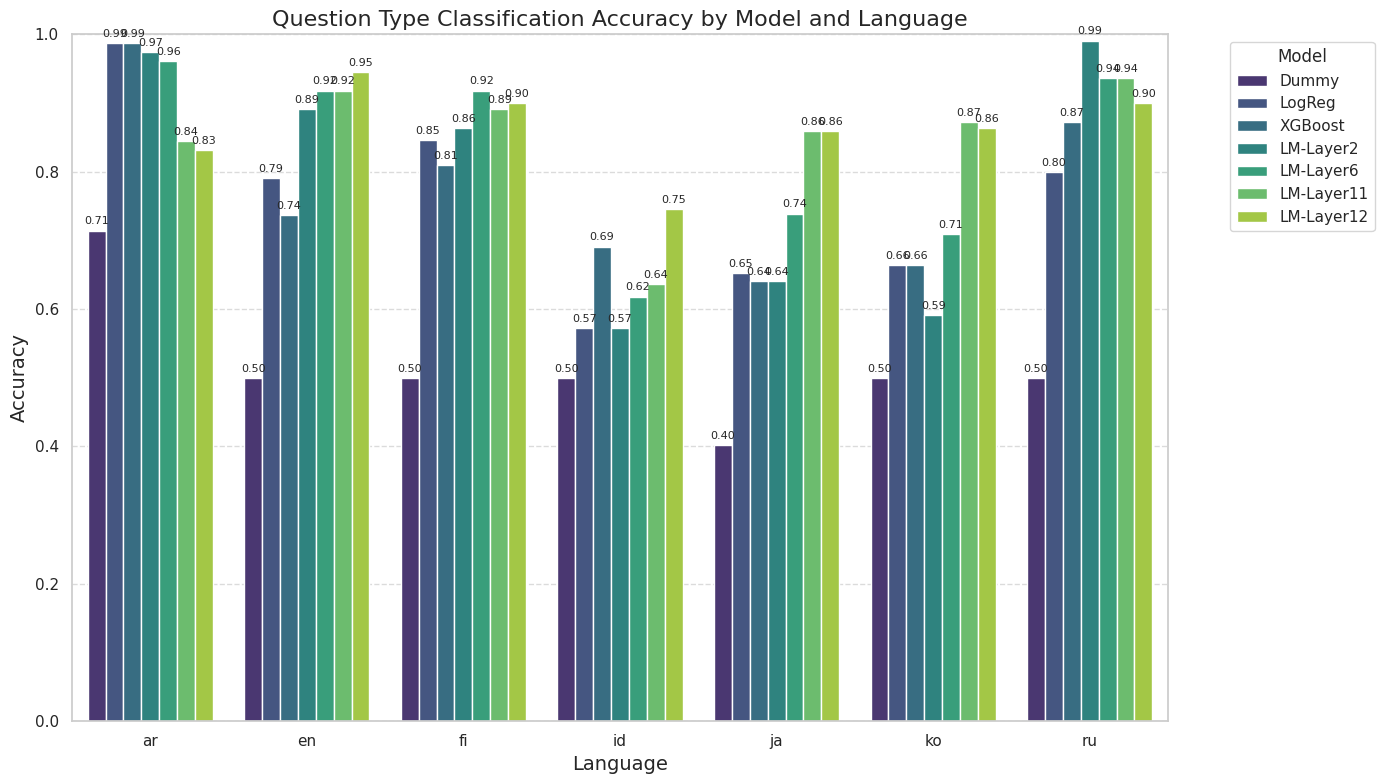

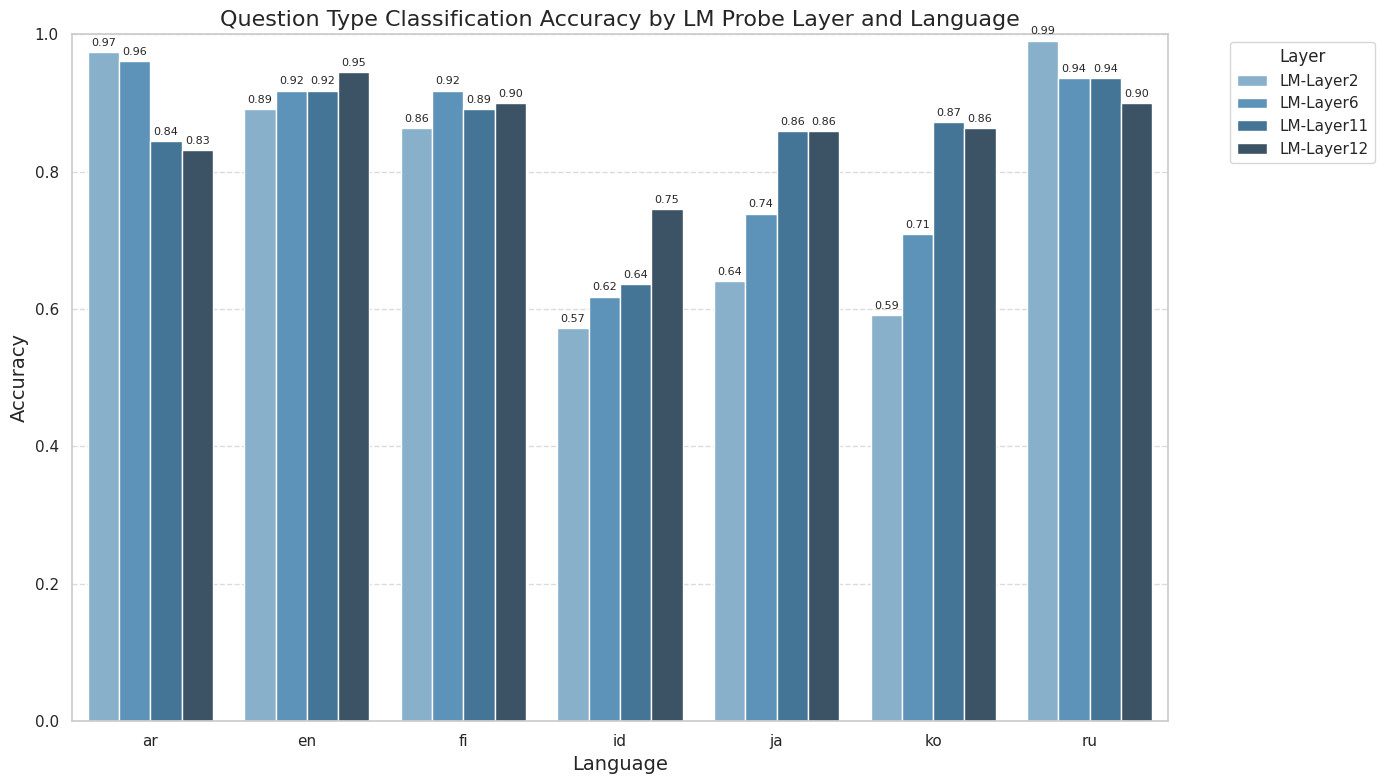

In [6]:

sns.set_theme(style="whitegrid")
plt.rcParams['figure.figsize'] = [14, 8]
plt.rcParams['font.size'] = 12

def read_csv_file(filepath):
    """Read a CSV file and handle potential errors"""
    try:
        # Try to read the file - adjust parameters as needed based on your CSV format
        df = pd.read_csv(filepath)
        print(f"Successfully read {filepath}")
        return df
    except Exception as e:
        print(f"Error reading {filepath}: {e}")
        return None

def extract_results_from_df(df, model_name):
    """Extract results from a dataframe in a consistent format"""
    if df is None:
        return {}
    
    # Print column names for debugging
    print(f"Columns in {model_name} dataframe: {df.columns.tolist()}")
    
    # Check if the expected columns exist
    if 'language' not in df.columns or 'real' not in df.columns:
        print(f"Warning: Required columns not found in {model_name} dataframe")
        return {}
    
    # Extract language and real score columns
    results = {}
    for _, row in df.iterrows():
        lang = row['language']
        score = row['real']
        results[lang] = score
    
    return results

def create_question_type_performance_table():
    """Create a performance table by reading specific CSV files"""
    # List of files to read - adjust paths as needed
    file_paths = {
        'Dummy': '/home/robin/Research/qtype-eval/scripts/analysis/question_type_DummyClassifier_accuracy_test_table.csv',
        'LogReg': '/home/robin/Research/qtype-eval/scripts/analysis/question_type_LogisticRegression_accuracy_test_table.csv',
        'XGBoost': '/home/robin/Research/qtype-eval/scripts/analysis/question_type_XGBClassifier_accuracy_test_table.csv',
        'LM-Layer2': '/home/robin/Research/qtype-eval/scripts/analysis/question_type_lm_probe_accuracy_test_overall_layer2_table.csv',
        'LM-Layer6': '/home/robin/Research/qtype-eval/scripts/analysis/question_type_lm_probe_accuracy_test_overall_layer6_table.csv',
        'LM-Layer11': '/home/robin/Research/qtype-eval/scripts/analysis/question_type_lm_probe_accuracy_test_overall_layer11_table.csv',
        'LM-Layer12': '/home/robin/Research/qtype-eval/scripts/analysis/question_type_lm_probe_accuracy_test_overall_layer12_table.csv'
    }
    
    # Read each file
    results = {}
    for model, filepath in file_paths.items():
        df = read_csv_file(filepath)
        results[model] = extract_results_from_df(df, model)
    
    # Get all unique languages across all files
    all_languages = set()
    for model_results in results.values():
        all_languages.update(model_results.keys())
    
    all_languages = sorted(list(all_languages))
    print(f"Found languages: {all_languages}")
    
    # Create a unified dataframe
    data = {'Language': all_languages}
    for model in file_paths.keys():
        data[model] = [results[model].get(lang, np.nan) for lang in all_languages]
    
    result_df = pd.DataFrame(data)
    return result_df

# Create the performance table
df = create_question_type_performance_table()

# Print the full table
print("\nQuestion Type Classification Performance Table:")
print(df.round(3))

# Save the table to CSV
df.round(3).to_csv('question_type_performance_summary.csv', index=False)

# Create a plot focusing on model performance comparison
# Determine which columns to use (excluding Language column)
plot_columns = [col for col in df.columns if col != 'Language']

# Reshape the dataframe for plotting
plot_df = df[['Language'] + plot_columns]
plot_df_melted = pd.melt(plot_df, id_vars=['Language'], 
                          var_name='Model', value_name='Accuracy')

# Create the plot
plt.figure(figsize=(14, 8))
ax = sns.barplot(x='Language', y='Accuracy', hue='Model', data=plot_df_melted, palette='viridis')

# Customize the plot
plt.title('Question Type Classification Accuracy by Model and Language', fontsize=16)
plt.xlabel('Language', fontsize=14)
plt.ylabel('Accuracy', fontsize=14)
plt.ylim(None, 1.0)  # Setting y-axis to start from 0.4 for better visibility of differences
plt.legend(title='Model', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Add value labels on the bars
for container in ax.containers:
    ax.bar_label(container, fmt='%.2f', padding=3, fontsize=8)

plt.tight_layout()

# Save the figure
plt.savefig('question_type_performance.png', dpi=300, bbox_inches='tight')

print("Figure saved as 'question_type_performance.png'")
print("Table saved as 'question_type_performance_summary.csv'")

# Create a more formal publication-ready table for LaTeX
latex_output = df.round(3).to_latex(index=False)
with open('question_type_performance_latex.tex', 'w') as f:
    f.write(latex_output)

print("LaTeX table saved as 'question_type_performance_latex.tex'")

# Create a new figure focusing on LM probe layers only
plt.figure(figsize=(14, 8))

# Filter for LM Probe layers only
lm_columns = [col for col in df.columns if col.startswith('LM-Layer')]
lm_plot_df = df[['Language'] + lm_columns]
lm_plot_df_melted = pd.melt(lm_plot_df, id_vars=['Language'], 
                          var_name='Layer', value_name='Accuracy')

# Create the plot
ax = sns.barplot(x='Language', y='Accuracy', hue='Layer', data=lm_plot_df_melted, palette='Blues_d')

# Customize the plot
plt.title('Question Type Classification Accuracy by LM Probe Layer and Language', fontsize=16)
plt.xlabel('Language', fontsize=14)
plt.ylabel('Accuracy', fontsize=14)
plt.ylim(None, 1.0)  # Adjusted for LM probe scores (likely to be higher)
plt.legend(title='Layer', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Add value labels on the bars
for container in ax.containers:
    ax.bar_label(container, fmt='%.2f', padding=3, fontsize=8)

plt.tight_layout()

# Save the figure
plt.savefig('question_type_lm_layers_performance.png', dpi=300, bbox_inches='tight')

print("LM Layers comparison figure saved as 'question_type_lm_layers_performance.png'")

Successfully read /home/robin/Research/qtype-eval/scripts/analysis/complexity_DummyRegressor_mse_test_table.csv
Columns in Dummy dataframe: ['language', 'real', 'control1', 'control2', 'control3']
Successfully read /home/robin/Research/qtype-eval/scripts/analysis/complexity_Ridge_mse_test_table.csv
Columns in Ridge dataframe: ['language', 'real', 'control1', 'control2', 'control3']
Successfully read /home/robin/Research/qtype-eval/scripts/analysis/complexity_XGBRegressor_rmse_test_table.csv
Columns in XGBoost dataframe: ['language', 'real', 'control1', 'control2', 'control3']
Successfully read /home/robin/Research/qtype-eval/scripts/analysis/complexity_lm_probe_mse_test_complexity_layer2_table.csv
Columns in LM-Layer2 dataframe: ['language', 'real', 'control1', 'control2', 'control3']
Successfully read /home/robin/Research/qtype-eval/scripts/analysis/complexity_lm_probe_mse_test_complexity_layer6_table.csv
Columns in LM-Layer6 dataframe: ['language', 'real', 'control1', 'control2', 'co

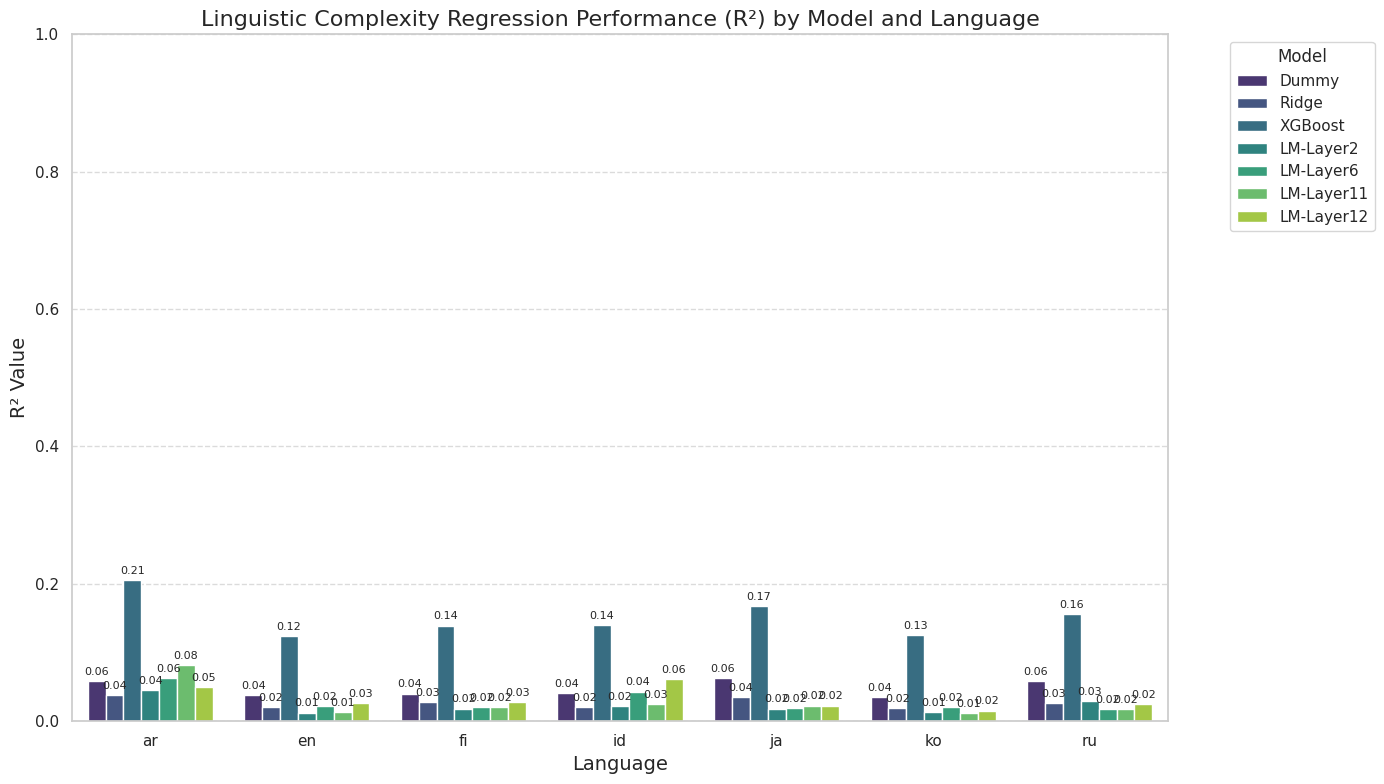

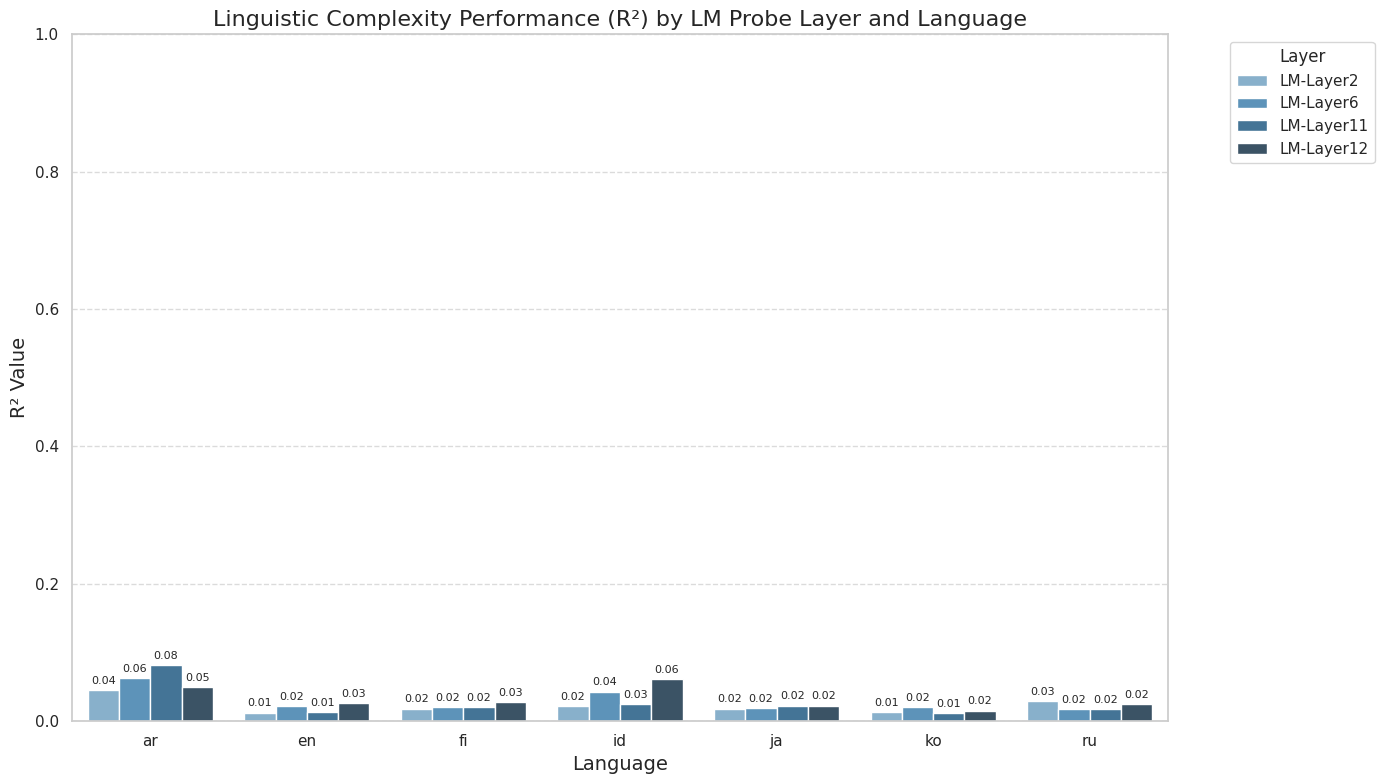

In [7]:

sns.set_theme(style="whitegrid")
plt.rcParams['figure.figsize'] = [14, 8]
plt.rcParams['font.size'] = 12

def read_csv_file(filepath):
    """Read a CSV file and handle potential errors"""
    try:
        # Try to read the file - adjust parameters as needed based on your CSV format
        df = pd.read_csv(filepath)
        print(f"Successfully read {filepath}")
        return df
    except Exception as e:
        print(f"Error reading {filepath}: {e}")
        return None

def extract_results_from_df(df, model_name):
    """Extract results from a dataframe in a consistent format"""
    if df is None:
        return {}
    
    # Print column names for debugging
    print(f"Columns in {model_name} dataframe: {df.columns.tolist()}")
    
    # For complexity tasks, we expect MSE values or R² values
    # Adjust column names based on your actual CSV structure
    score_column = 'real'  # Change this if your column is different
    if score_column not in df.columns:
        print(f"Warning: Required column '{score_column}' not found in {model_name} dataframe")
        return {}
    
    # Extract language and score columns
    results = {}
    for _, row in df.iterrows():
        lang = row['language']
        score = row[score_column]
        results[lang] = score
    
    return results

def create_complexity_performance_table():
    """Create a performance table by reading complexity metric CSV files"""
    # List of files to read - adjust paths as needed based on your actual filenames
    # For complexity tasks, we expect files for different regression models
    file_paths = {
        'Dummy': '/home/robin/Research/qtype-eval/scripts/analysis/complexity_DummyRegressor_mse_test_table.csv',
        'Ridge': '/home/robin/Research/qtype-eval/scripts/analysis/complexity_Ridge_mse_test_table.csv',
        'XGBoost': '/home/robin/Research/qtype-eval/scripts/analysis/complexity_XGBRegressor_rmse_test_table.csv',
        'LM-Layer2': '/home/robin/Research/qtype-eval/scripts/analysis/complexity_lm_probe_mse_test_complexity_layer2_table.csv',
        'LM-Layer6': '/home/robin/Research/qtype-eval/scripts/analysis/complexity_lm_probe_mse_test_complexity_layer6_table.csv',
        'LM-Layer11': '/home/robin/Research/qtype-eval/scripts/analysis/complexity_lm_probe_mse_test_complexity_layer11_table.csv',
        'LM-Layer12': '/home/robin/Research/qtype-eval/scripts/analysis/complexity_lm_probe_mse_test_complexity_layer12_table.csv'
    }
    
    # Read each file
    results = {}
    for model, filepath in file_paths.items():
        df = read_csv_file(filepath)
        results[model] = extract_results_from_df(df, model)
    
    # Get all unique languages across all files
    all_languages = set()
    for model_results in results.values():
        all_languages.update(model_results.keys())
    
    all_languages = sorted(list(all_languages))
    print(f"Found languages: {all_languages}")
    
    # Create a unified dataframe
    data = {'Language': all_languages}
    for model in file_paths.keys():
        data[model] = [results[model].get(lang, np.nan) for lang in all_languages]
    
    result_df = pd.DataFrame(data)
    return result_df

# Create the performance table
df = create_complexity_performance_table()

# Print the full table
print("\nLinguistic Complexity Performance Table (R² values):")
print(df.round(3))

# Save the table to CSV
df.round(3).to_csv('complexity_performance_summary.csv', index=False)

# Create a plot focusing on model performance comparison
# Determine which columns to use (excluding Language column)
plot_columns = [col for col in df.columns if col != 'Language']

# Reshape the dataframe for plotting
plot_df = df[['Language'] + plot_columns]
plot_df_melted = pd.melt(plot_df, id_vars=['Language'], 
                          var_name='Model', value_name='R²')

# Create the plot
plt.figure(figsize=(14, 8))
ax = sns.barplot(x='Language', y='R²', hue='Model', data=plot_df_melted, palette='viridis')

# Customize the plot
plt.title('Linguistic Complexity Regression Performance (R²) by Model and Language', fontsize=16)
plt.xlabel('Language', fontsize=14)
plt.ylabel('R² Value', fontsize=14)
plt.ylim(None, 1.0)  # R² values range from 0 to 1
plt.legend(title='Model', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Add value labels on the bars
for container in ax.containers:
    ax.bar_label(container, fmt='%.2f', padding=3, fontsize=8)

plt.tight_layout()

# Save the figure
plt.savefig('complexity_performance.png', dpi=300, bbox_inches='tight')

print("Figure saved as 'complexity_performance.png'")
print("Table saved as 'complexity_performance_summary.csv'")

# Create a more formal publication-ready table for LaTeX
latex_output = df.round(3).to_latex(index=False)
with open('complexity_performance_latex.tex', 'w') as f:
    f.write(latex_output)

print("LaTeX table saved as 'complexity_performance_latex.tex'")

# Create a new figure focusing on LM probe layers only
plt.figure(figsize=(14, 8))

# Filter for LM Probe layers only
lm_columns = [col for col in df.columns if col.startswith('LM-Layer')]
lm_plot_df = df[['Language'] + lm_columns]
lm_plot_df_melted = pd.melt(lm_plot_df, id_vars=['Language'], 
                          var_name='Layer', value_name='R²')

# Create the plot
ax = sns.barplot(x='Language', y='R²', hue='Layer', data=lm_plot_df_melted, palette='Blues_d')

# Customize the plot
plt.title('Linguistic Complexity Performance (R²) by LM Probe Layer and Language', fontsize=16)
plt.xlabel('Language', fontsize=14)
plt.ylabel('R² Value', fontsize=14)
plt.ylim(None, 1.0)  # R² values range from 0 to 1
plt.legend(title='Layer', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Add value labels on the bars
for container in ax.containers:
    ax.bar_label(container, fmt='%.2f', padding=3, fontsize=8)

plt.tight_layout()

# Save the figure
plt.savefig('complexity_lm_layers_performance.png', dpi=300, bbox_inches='tight')

print("LM Layers comparison figure saved as 'complexity_lm_layers_performance.png'")




=== Processing Question Type Classification ===
Successfully read /home/robin/Research/qtype-eval/scripts/analysis/question_type_DummyClassifier_accuracy_test_table.csv
Columns in Dummy dataframe: ['language', 'real', 'control1', 'control2', 'control3']
Successfully read /home/robin/Research/qtype-eval/scripts/analysis/question_type_LogisticRegression_accuracy_test_table.csv
Columns in LogReg dataframe: ['language', 'real', 'control1', 'control2', 'control3']
Successfully read /home/robin/Research/qtype-eval/scripts/analysis/question_type_XGBClassifier_accuracy_test_table.csv
Columns in XGBoost dataframe: ['language', 'real', 'control1', 'control2', 'control3']
Successfully read /home/robin/Research/qtype-eval/scripts/analysis/question_type_lm_probe_accuracy_test_overall_layer2_table.csv
Columns in LM-Layer2 dataframe: ['language', 'real', 'control1', 'control2', 'control3']
Successfully read /home/robin/Research/qtype-eval/scripts/analysis/question_type_lm_probe_accuracy_test_overall

/tmp/ipykernel_1199925/4036199569.py:259: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[0, i].set_xticklabels(axes[0, i].get_xticklabels(), rotation=45, ha='right')
/tmp/ipykernel_1199925/4036199569.py:269: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[1, i].set_xticklabels(axes[1, i].get_xticklabels(), rotation=45, ha='right')
/tmp/ipykernel_1199925/4036199569.py:259: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[0, i].set_xticklabels(axes[0, i].get_xticklabels(), rotation=45, ha='right')
/tmp/ipykernel_1199925/4036199569.py:269: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[1, i].set_xticklabels(axes[1, i].get_xticklabels(), rotation=

Figure saved as 'question_type_real_vs_control.png'

=== Processing Linguistic Complexity Regression ===
Successfully read /home/robin/Research/qtype-eval/scripts/analysis/complexity_DummyRegressor_rmse_test_table.csv
Columns in Dummy dataframe: ['language', 'real', 'control1', 'control2', 'control3']
Successfully read /home/robin/Research/qtype-eval/scripts/analysis/complexity_Ridge_rmse_test_table.csv
Columns in Ridge dataframe: ['language', 'real', 'control1', 'control2', 'control3']
Successfully read /home/robin/Research/qtype-eval/scripts/analysis/complexity_XGBRegressor_rmse_test_table.csv
Columns in XGBoost dataframe: ['language', 'real', 'control1', 'control2', 'control3']
Successfully read /home/robin/Research/qtype-eval/scripts/analysis/complexity_lm_probe_rmse_test_complexity_layer2_table.csv
Columns in LM-Layer2 dataframe: ['language', 'real', 'control1', 'control2', 'control3']
Successfully read /home/robin/Research/qtype-eval/scripts/analysis/complexity_lm_probe_rmse_test

/tmp/ipykernel_1199925/4036199569.py:259: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[0, i].set_xticklabels(axes[0, i].get_xticklabels(), rotation=45, ha='right')
/tmp/ipykernel_1199925/4036199569.py:269: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[1, i].set_xticklabels(axes[1, i].get_xticklabels(), rotation=45, ha='right')
/tmp/ipykernel_1199925/4036199569.py:259: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[0, i].set_xticklabels(axes[0, i].get_xticklabels(), rotation=45, ha='right')
/tmp/ipykernel_1199925/4036199569.py:269: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[1, i].set_xticklabels(axes[1, i].get_xticklabels(), rotation=

Figure saved as 'complexity_real_vs_control.png'
LaTeX table saved as 'question_type_real_performance_latex.tex'
LaTeX table saved as 'question_type_control_avg_latex.tex'
LaTeX table saved as 'question_type_selectivity_latex.tex'
LaTeX table saved as 'complexity_real_performance_latex.tex'
LaTeX table saved as 'complexity_control_avg_latex.tex'
LaTeX table saved as 'complexity_selectivity_latex.tex'

All analyses completed successfully!


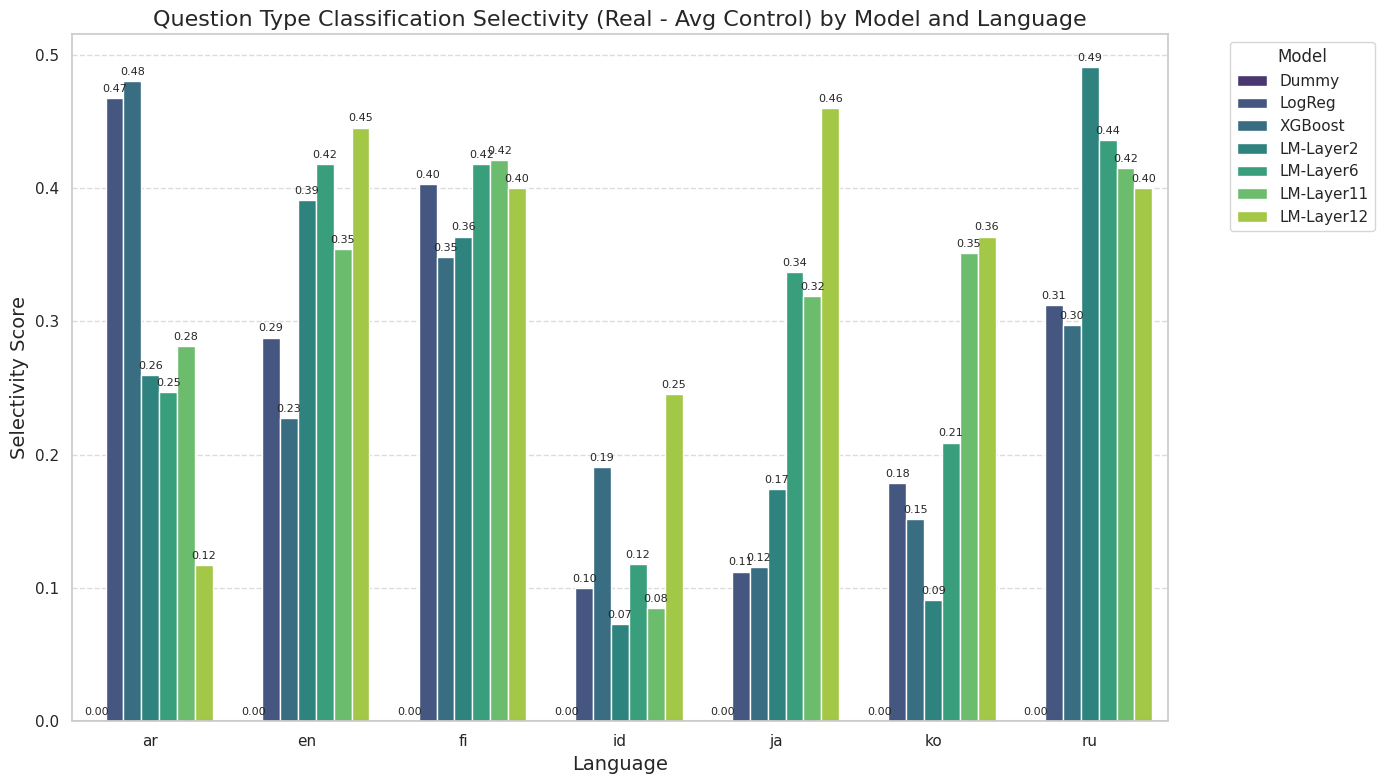

<Figure size 1600x1000 with 0 Axes>

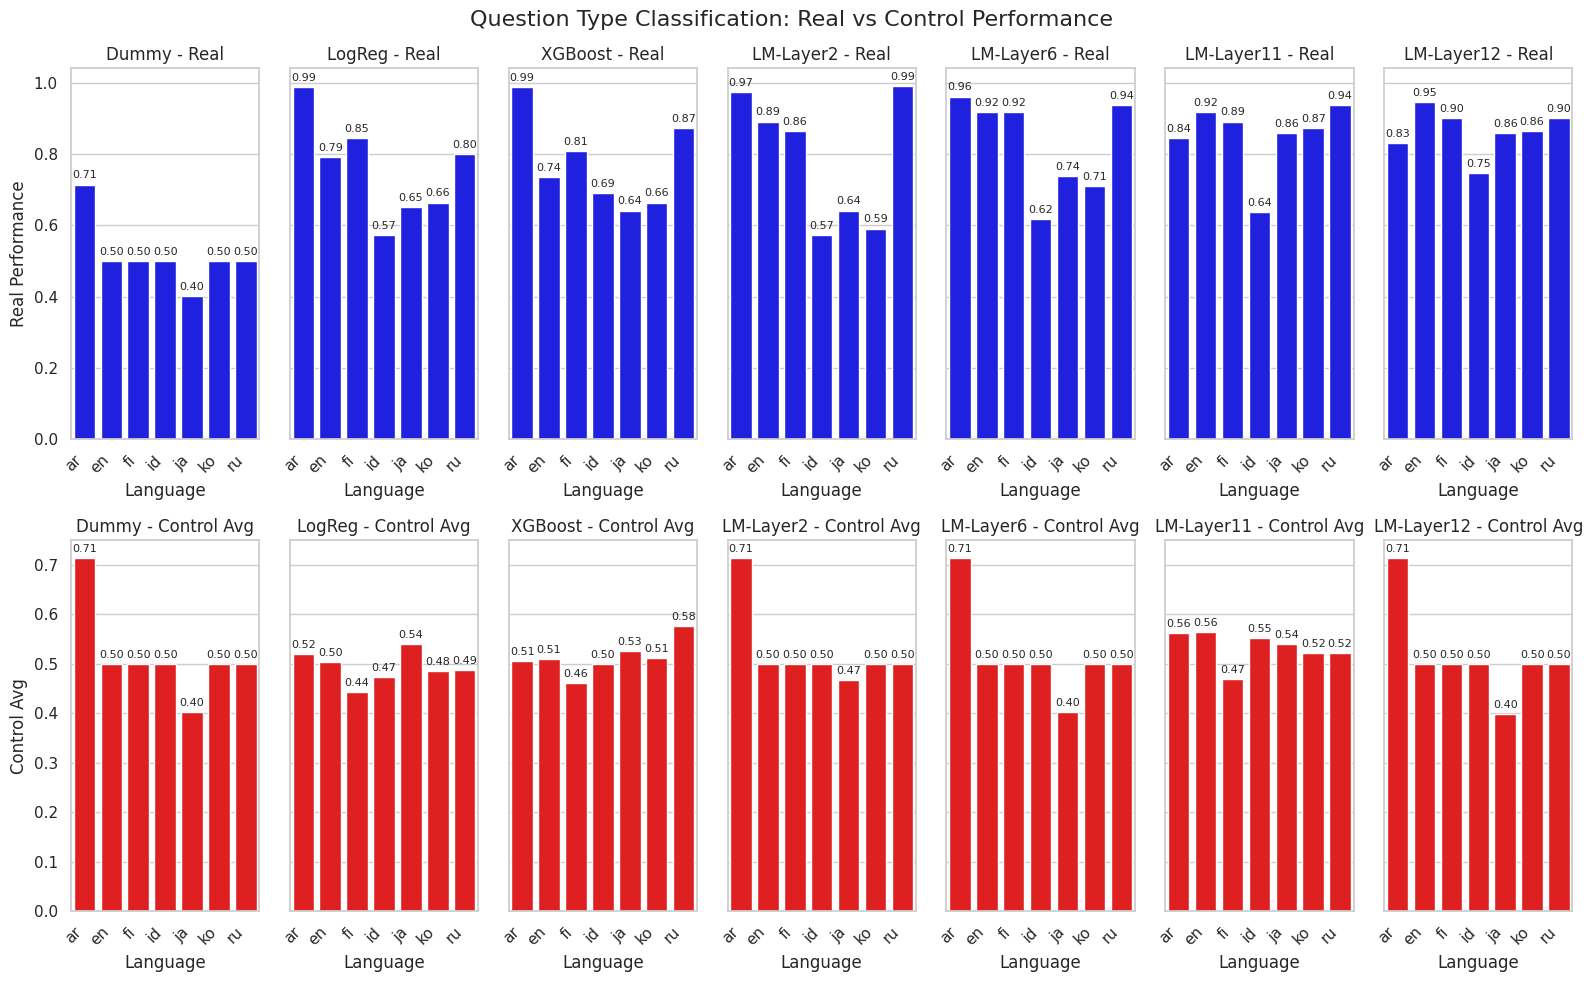

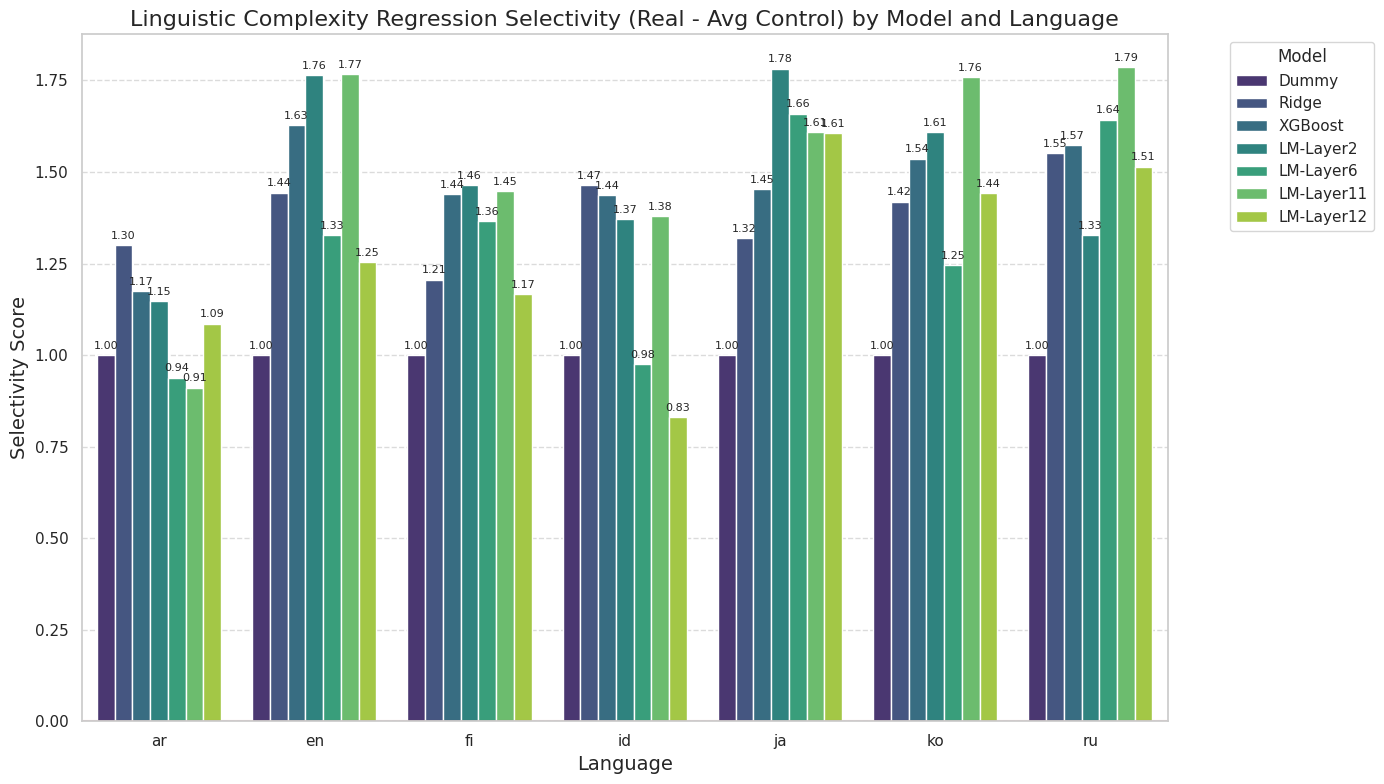

<Figure size 1600x1000 with 0 Axes>

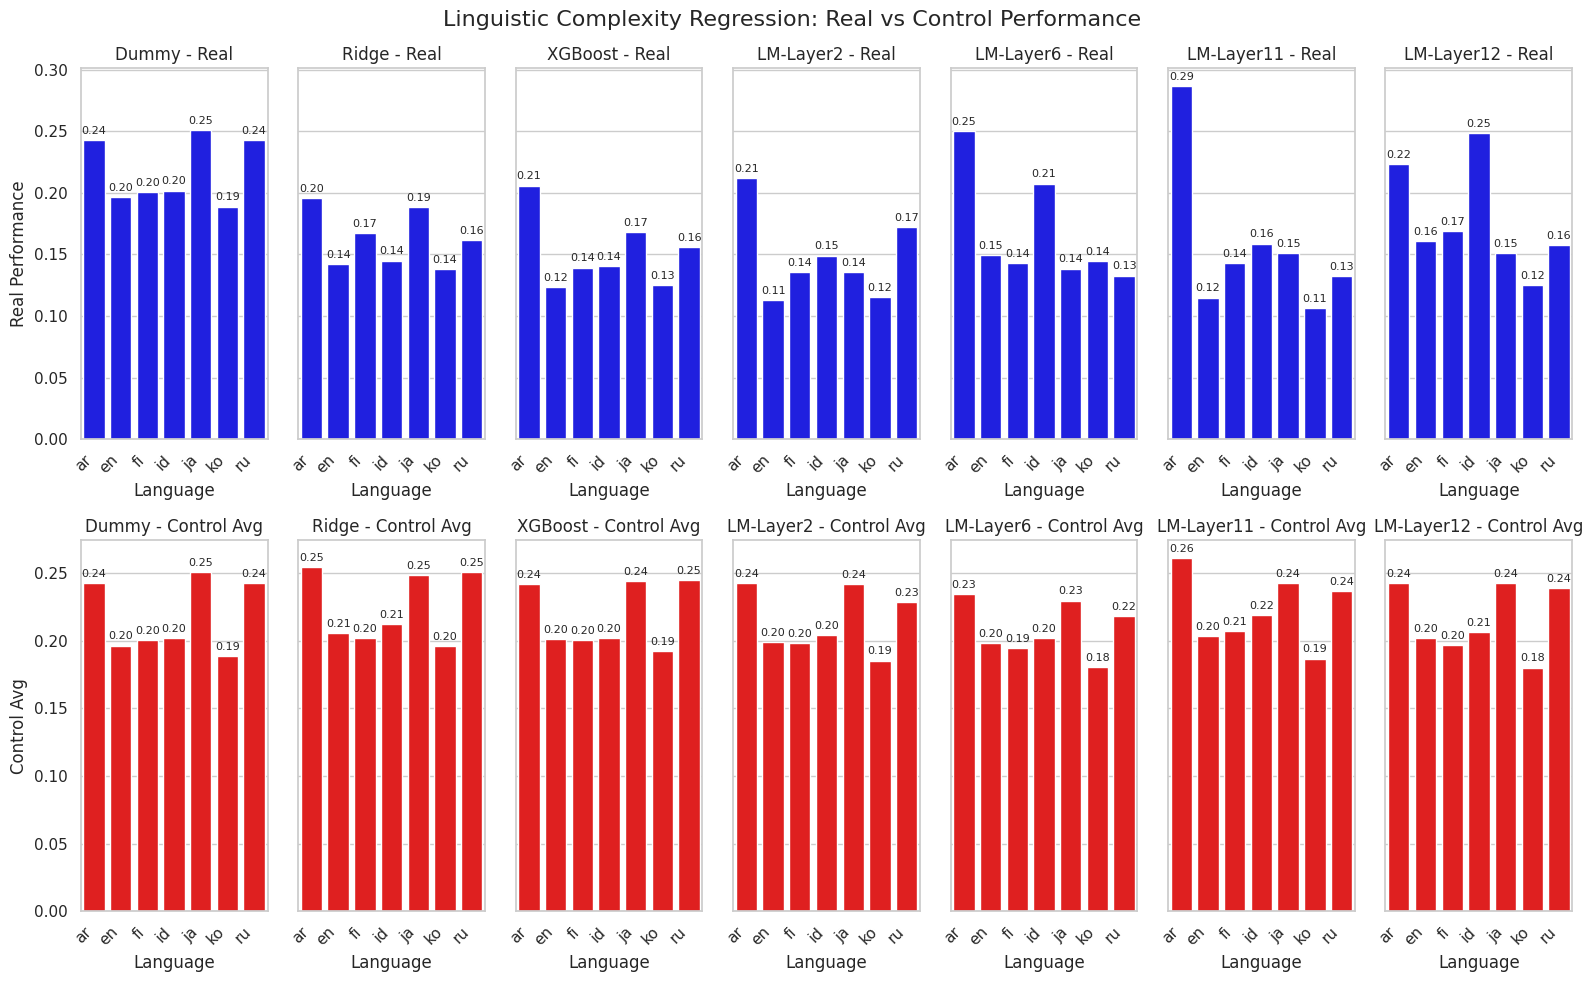

In [ ]:


def read_csv_file(filepath):
    """Read a CSV file and handle potential errors"""
    try:
        # Try to read the file - adjust parameters as needed based on your CSV format
        df = pd.read_csv(filepath)
        print(f"Successfully read {filepath}")
        return df
    except Exception as e:
        print(f"Error reading {filepath}: {e}")
        return None

def extract_results_with_controls(df, model_name):
    """Extract results including control tasks from a dataframe"""
    if df is None:
        return {}
    
    # Print column names for debugging
    print(f"Columns in {model_name} dataframe: {df.columns.tolist()}")
    
    # Check if the expected columns exist
    expected_columns = ['language', 'real', 'control1', 'control2', 'control3']
    missing_columns = [col for col in expected_columns if col not in df.columns]
    
    if missing_columns:
        print(f"Warning: Missing columns in {model_name} dataframe: {missing_columns}")
        # Try alternative column names (depends on your actual data format)
        alt_names = {'control1': 'control_1', 'control2': 'control_2', 'control3': 'control_3'}
        for col in missing_columns:
            if col in alt_names and alt_names[col] in df.columns:
                print(f"Using alternative column name {alt_names[col]} for {col}")
                df[col] = df[alt_names[col]]
            else:
                print(f"Cannot find alternative for column {col}")
                return {}
    
    # Extract results
    results = {}
    for _, row in df.iterrows():
        lang = row['language']
        results[lang] = {
            'real': row['real'],
            'control1': row['control1'],
            'control2': row['control2'],
            'control3': row['control3']
        }
    
    return results

def create_question_type_selectivity_table():
    """Create a selectivity performance table for question type task"""
    # List of files to read - adjust paths as needed
    file_paths = {
        'Dummy': '/home/robin/Research/qtype-eval/scripts/analysis/question_type_DummyClassifier_accuracy_test_table.csv',
        'LogReg': '/home/robin/Research/qtype-eval/scripts/analysis/question_type_LogisticRegression_accuracy_test_table.csv',
        'XGBoost': '/home/robin/Research/qtype-eval/scripts/analysis/question_type_XGBClassifier_accuracy_test_table.csv',
        'LM-Layer2': '/home/robin/Research/qtype-eval/scripts/analysis/question_type_lm_probe_accuracy_test_overall_layer2_table.csv',
        'LM-Layer6': '/home/robin/Research/qtype-eval/scripts/analysis/question_type_lm_probe_accuracy_test_overall_layer6_table.csv',
        'LM-Layer11': '/home/robin/Research/qtype-eval/scripts/analysis/question_type_lm_probe_accuracy_test_overall_layer11_table.csv',
        'LM-Layer12': '/home/robin/Research/qtype-eval/scripts/analysis/question_type_lm_probe_accuracy_test_overall_layer12_table.csv'
    }
    
    # Read each file
    results = {}
    for model, filepath in file_paths.items():
        df = read_csv_file(filepath)
        results[model] = extract_results_with_controls(df, model)
    
    # Get all unique languages across all files
    all_languages = set()
    for model_results in results.values():
        all_languages.update(model_results.keys())
    
    all_languages = sorted(list(all_languages))
    print(f"Found languages: {all_languages}")
    
    # Create dataframes for performance metrics
    data_real = {'Language': all_languages}
    data_control_avg = {'Language': all_languages}
    data_selectivity = {'Language': all_languages}
    
    for model in file_paths.keys():
        # Real performance
        data_real[model] = []
        # Average control performance
        data_control_avg[model] = []
        # Selectivity (real - avg_control)
        data_selectivity[model] = []
        
        for lang in all_languages:
            if lang in results[model]:
                real_val = results[model][lang]['real']
                control1 = results[model][lang]['control1']
                control2 = results[model][lang]['control2']
                control3 = results[model][lang]['control3']
                
                avg_control = (control1 + control2 + control3) / 3
                selectivity = real_val - avg_control
                
                data_real[model].append(real_val)
                data_control_avg[model].append(avg_control)
                data_selectivity[model].append(selectivity)
            else:
                data_real[model].append(np.nan)
                data_control_avg[model].append(np.nan)
                data_selectivity[model].append(np.nan)
    
    # Create DataFrames
    df_real = pd.DataFrame(data_real)
    df_control_avg = pd.DataFrame(data_control_avg)
    df_selectivity = pd.DataFrame(data_selectivity)
    
    return df_real, df_control_avg, df_selectivity

def create_complexity_selectivity_table():
    """Create a selectivity performance table for complexity task"""
    # List of files to read - adjust paths as needed
    file_paths = {
        'Dummy': '/home/robin/Research/qtype-eval/scripts/analysis/complexity_DummyRegressor_rmse_test_table.csv',
        'Ridge': '/home/robin/Research/qtype-eval/scripts/analysis/complexity_Ridge_rmse_test_table.csv',
        'XGBoost': '/home/robin/Research/qtype-eval/scripts/analysis/complexity_XGBRegressor_rmse_test_table.csv',
        'LM-Layer2': '/home/robin/Research/qtype-eval/scripts/analysis/complexity_lm_probe_rmse_test_complexity_layer2_table.csv',
        'LM-Layer6': '/home/robin/Research/qtype-eval/scripts/analysis/complexity_lm_probe_rmse_test_complexity_layer6_table.csv',
        'LM-Layer11': '/home/robin/Research/qtype-eval/scripts/analysis/complexity_lm_probe_rmse_test_complexity_layer11_table.csv',
        'LM-Layer12': '/home/robin/Research/qtype-eval/scripts/analysis/complexity_lm_probe_rmse_test_complexity_layer12_table.csv'
    }
    
    # Read each file
    results = {}
    for model, filepath in file_paths.items():
        df = read_csv_file(filepath)
        results[model] = extract_results_with_controls(df, model)
    
    # Get all unique languages across all files
    all_languages = set()
    for model_results in results.values():
        all_languages.update(model_results.keys())
    
    all_languages = sorted(list(all_languages))
    print(f"Found languages: {all_languages}")
    
    # Create dataframes for performance metrics
    data_real = {'Language': all_languages}
    data_control_avg = {'Language': all_languages}
    data_selectivity = {'Language': all_languages}
    
    for model in file_paths.keys():
        # Real performance
        data_real[model] = []
        # Average control performance
        data_control_avg[model] = []
        # Selectivity (real - avg_control) for R², higher is better
        data_selectivity[model] = []
        
        for lang in all_languages:
            if lang in results[model]:
                real_val = results[model][lang]['real']
                control1 = results[model][lang]['control1']
                control2 = results[model][lang]['control2']
                control3 = results[model][lang]['control3']
                
                avg_control = (control1 + control2 + control3) / 3
                selectivity = avg_control / real_val
                
                data_real[model].append(real_val)
                data_control_avg[model].append(avg_control)
                data_selectivity[model].append(selectivity)
            else:
                data_real[model].append(np.nan)
                data_control_avg[model].append(np.nan)
                data_selectivity[model].append(np.nan)
    
    # Create DataFrames
    df_real = pd.DataFrame(data_real)
    df_control_avg = pd.DataFrame(data_control_avg)
    df_selectivity = pd.DataFrame(data_selectivity)
    
    return df_real, df_control_avg, df_selectivity

def plot_selectivity(df_selectivity, task_name, filename_prefix):
    """Plot selectivity scores"""
    plt.figure(figsize=(14, 8))
    
    # Determine which columns to use (excluding Language column)
    plot_columns = [col for col in df_selectivity.columns if col != 'Language']
    
    # Reshape the dataframe for plotting
    plot_df = df_selectivity[['Language'] + plot_columns]
    plot_df_melted = pd.melt(plot_df, id_vars=['Language'], 
                              var_name='Model', value_name='Selectivity')
    
    # Create the plot
    ax = sns.barplot(x='Language', y='Selectivity', hue='Model', data=plot_df_melted, palette='viridis')
    
    # Customize the plot
    plt.title(f'{task_name} Selectivity (Real - Avg Control) by Model and Language', fontsize=16)
    plt.xlabel('Language', fontsize=14)
    plt.ylabel('Selectivity Score', fontsize=14)
    plt.ylim(None, None)  # Auto-adjust both limits based on data
    plt.legend(title='Model', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    
    # Add value labels on the bars
    for container in ax.containers:
        ax.bar_label(container, fmt='%.2f', padding=3, fontsize=8)
    
    # Add a zero line to highlight positive vs negative selectivity
    plt.axhline(y=0, color='r', linestyle='-', alpha=0.3)
    
    plt.tight_layout()
    
    # Save the figure
    plt.savefig(f'{filename_prefix}_selectivity.png', dpi=300, bbox_inches='tight')
    
    print(f"Figure saved as '{filename_prefix}_selectivity.png'")

def plot_real_vs_control(df_real, df_control_avg, task_name, filename_prefix):
    """Plot real vs control performance"""
    # Let's focus on a subset of models for clarity
    focus_models = ['Dummy', 'LogReg', 'Ridge', 
                   'XGBoost', 'LM-Layer2', 'LM-Layer6', 'LM-Layer11', 'LM-Layer12']
    
    # Filter for only available models
    focus_models = [m for m in focus_models if m in df_real.columns]
    
    plt.figure(figsize=(16, 10))
    
    # Create a 2 x len(focus_models) grid of subplots
    fig, axes = plt.subplots(2, len(focus_models), figsize=(16, 10), sharey='row')
    
    # Plot each model in its own column
    for i, model in enumerate(focus_models):
        # Real performance on top row
        plot_data_real = pd.DataFrame({
            'Language': df_real['Language'],
            'Real': df_real[model]
        })
        
        # Control performance on bottom row
        plot_data_control = pd.DataFrame({
            'Language': df_control_avg['Language'],
            'Control Avg': df_control_avg[model]
        })
        
        # Plot real performance
        sns.barplot(x='Language', y='Real', data=plot_data_real, 
                   color='blue', ax=axes[0, i])
        axes[0, i].set_title(f'{model} - Real', fontsize=12)
        axes[0, i].set_xticklabels(axes[0, i].get_xticklabels(), rotation=45, ha='right')
        if i == 0:
            axes[0, i].set_ylabel('Real Performance', fontsize=12)
        else:
            axes[0, i].set_ylabel('')
        
        # Plot control performance
        sns.barplot(x='Language', y='Control Avg', data=plot_data_control, 
                   color='red', ax=axes[1, i])
        axes[1, i].set_title(f'{model} - Control Avg', fontsize=12)
        axes[1, i].set_xticklabels(axes[1, i].get_xticklabels(), rotation=45, ha='right')
        if i == 0:
            axes[1, i].set_ylabel('Control Avg', fontsize=12)
        else:
            axes[1, i].set_ylabel('')
        
        # Add value labels
        for container in axes[0, i].containers:
            axes[0, i].bar_label(container, fmt='%.2f', padding=3, fontsize=8)
        for container in axes[1, i].containers:
            axes[1, i].bar_label(container, fmt='%.2f', padding=3, fontsize=8)
    
    plt.suptitle(f'{task_name}: Real vs Control Performance', fontsize=16)
    plt.tight_layout()
    
    # Save the figure
    plt.savefig(f'{filename_prefix}_real_vs_control.png', dpi=300, bbox_inches='tight')
    
    print(f"Figure saved as '{filename_prefix}_real_vs_control.png'")

# Process Question Type Classification
print("\n=== Processing Question Type Classification ===")
qt_real, qt_control_avg, qt_selectivity = create_question_type_selectivity_table()

# Print tables
print("\nQuestion Type - Real Performance:")
print(qt_real.round(3))

print("\nQuestion Type - Control Average:")
print(qt_control_avg.round(3))

print("\nQuestion Type - Selectivity (Real - Avg Control):")
print(qt_selectivity.round(3))

# Save tables
qt_real.round(3).to_csv('question_type_real_performance.csv', index=False)
qt_control_avg.round(3).to_csv('question_type_control_avg.csv', index=False)
qt_selectivity.round(3).to_csv('question_type_selectivity.csv', index=False)

# Create plots
plot_selectivity(qt_selectivity, 'Question Type Classification', 'question_type')
plot_real_vs_control(qt_real, qt_control_avg, 'Question Type Classification', 'question_type')

# Process Complexity Regression
print("\n=== Processing Linguistic Complexity Regression ===")
comp_real, comp_control_avg, comp_selectivity = create_complexity_selectivity_table()

# Print tables
print("\nComplexity - Real Performance:")
print(comp_real.round(3))

print("\nComplexity - Control Average:")
print(comp_control_avg.round(3))

print("\nComplexity - Selectivity (Avg Control - Real):")
print(comp_selectivity.round(3))

# Save tables
comp_real.round(3).to_csv('complexity_real_performance.csv', index=False)
comp_control_avg.round(3).to_csv('complexity_control_avg.csv', index=False)
comp_selectivity.round(3).to_csv('complexity_selectivity.csv', index=False)

# Create plots
plot_selectivity(comp_selectivity, 'Linguistic Complexity Regression', 'complexity')
plot_real_vs_control(comp_real, comp_control_avg, 'Linguistic Complexity Regression', 'complexity')

# Create latex tables for publication
for df, name in [
    (qt_real, 'question_type_real_performance'), 
    (qt_control_avg, 'question_type_control_avg'),
    (qt_selectivity, 'question_type_selectivity'),
    (comp_real, 'complexity_real_performance'),
    (comp_control_avg, 'complexity_control_avg'),
    (comp_selectivity, 'complexity_selectivity')
]:
    latex_output = df.round(3).to_latex(index=False)
    with open(f'{name}_latex.tex', 'w') as f:
        f.write(latex_output)
    print(f"LaTeX table saved as '{name}_latex.tex'")

print("\nAll analyses completed successfully!")


=== Processing Submetric Selectivity Analysis ===
Successfully read /home/robin/Research/qtype-eval/scripts/analysis/complexity_Ridge_mse_test_avg_links_len_table.csv
Columns in Ridge_avg_links_len dataframe: ['language', 'real', 'control1', 'control2', 'control3']
Successfully read /home/robin/Research/qtype-eval/scripts/analysis/complexity_XGBRegressor_mse_test_avg_links_len_table.csv
Columns in XGBRegressor_avg_links_len dataframe: ['language', 'real', 'control1', 'control2', 'control3']
Successfully read /home/robin/Research/qtype-eval/scripts/analysis/single_submetric_lm_probe_mse_test_avg_links_len_layer2_table.csv
Columns in lm_probe_layer2 dataframe: ['language', 'real', 'control1', 'control2', 'control3']
Successfully read /home/robin/Research/qtype-eval/scripts/analysis/single_submetric_lm_probe_mse_test_avg_links_len_layer6_table.csv
Columns in lm_probe_layer6 dataframe: ['language', 'real', 'control1', 'control2', 'control3']
Successfully read /home/robin/Research/qtype-ev

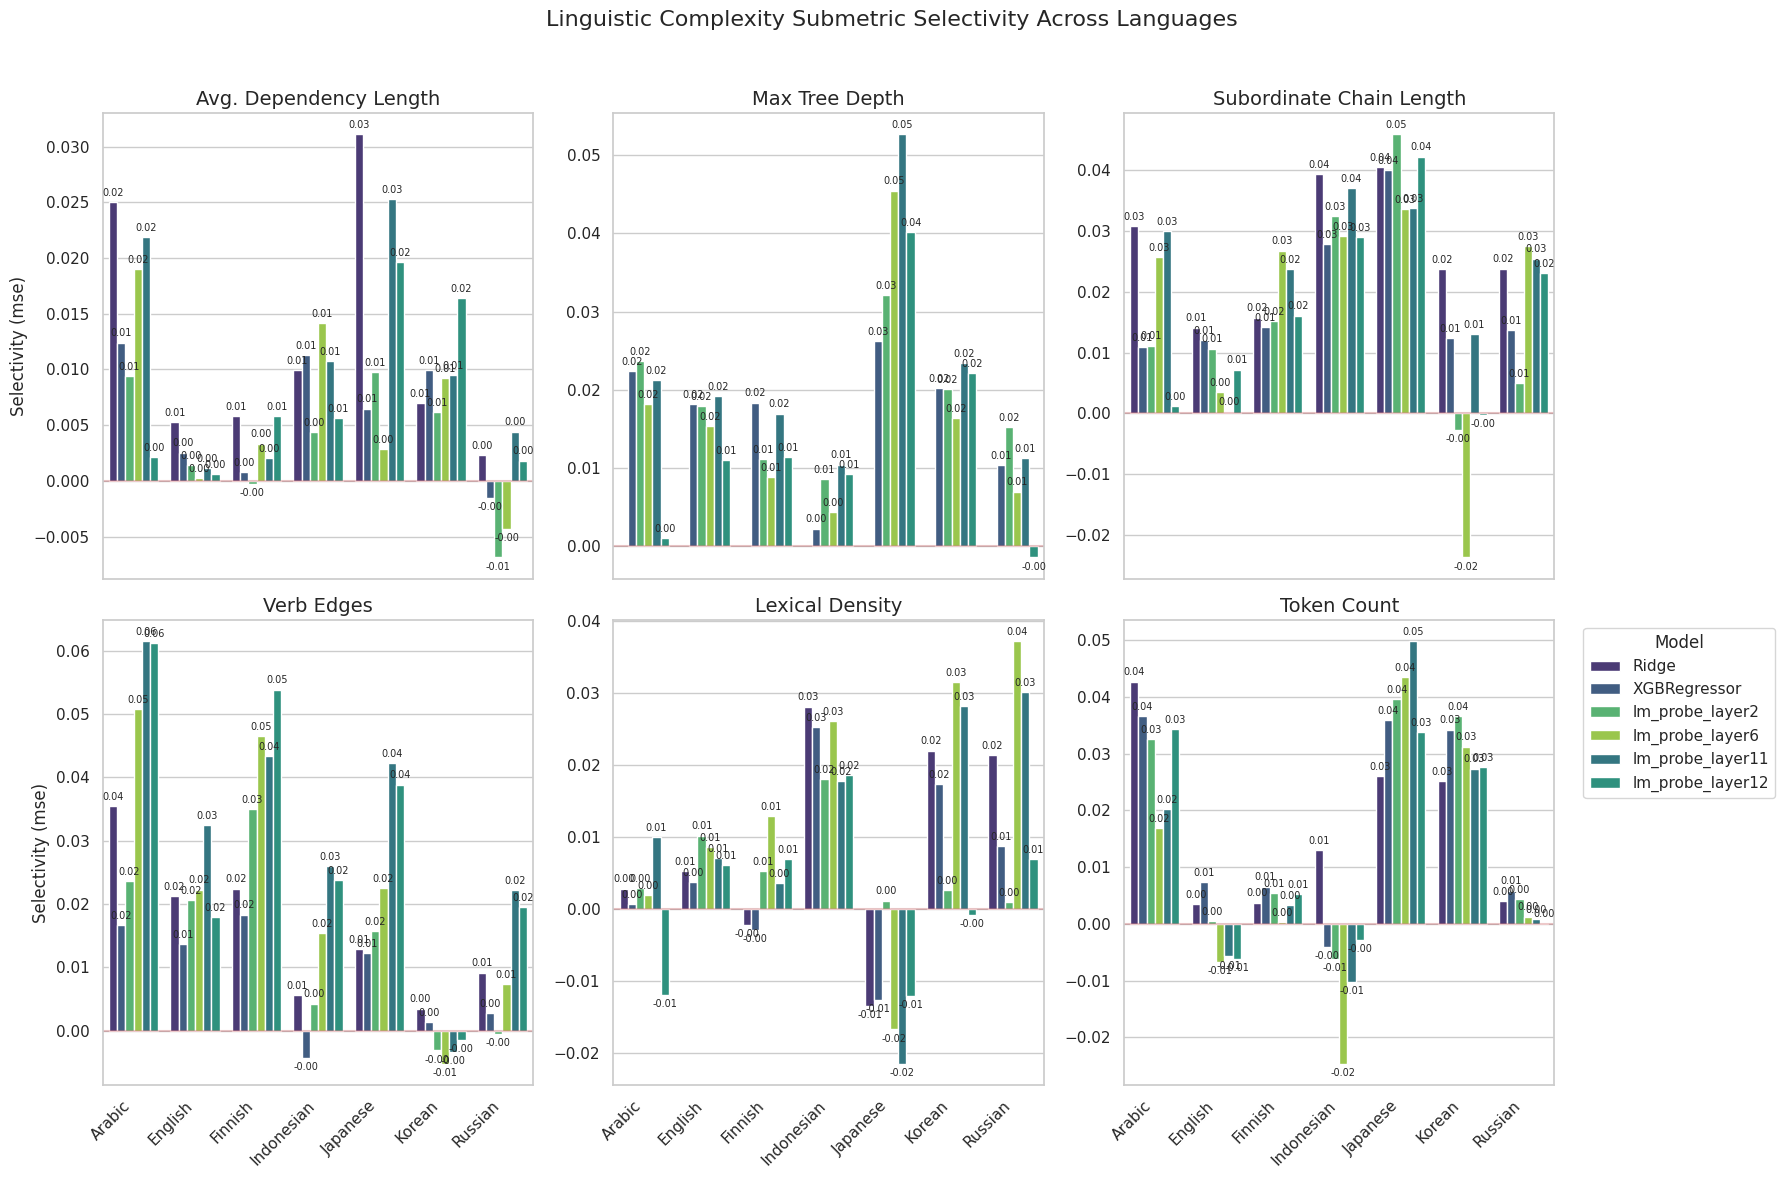

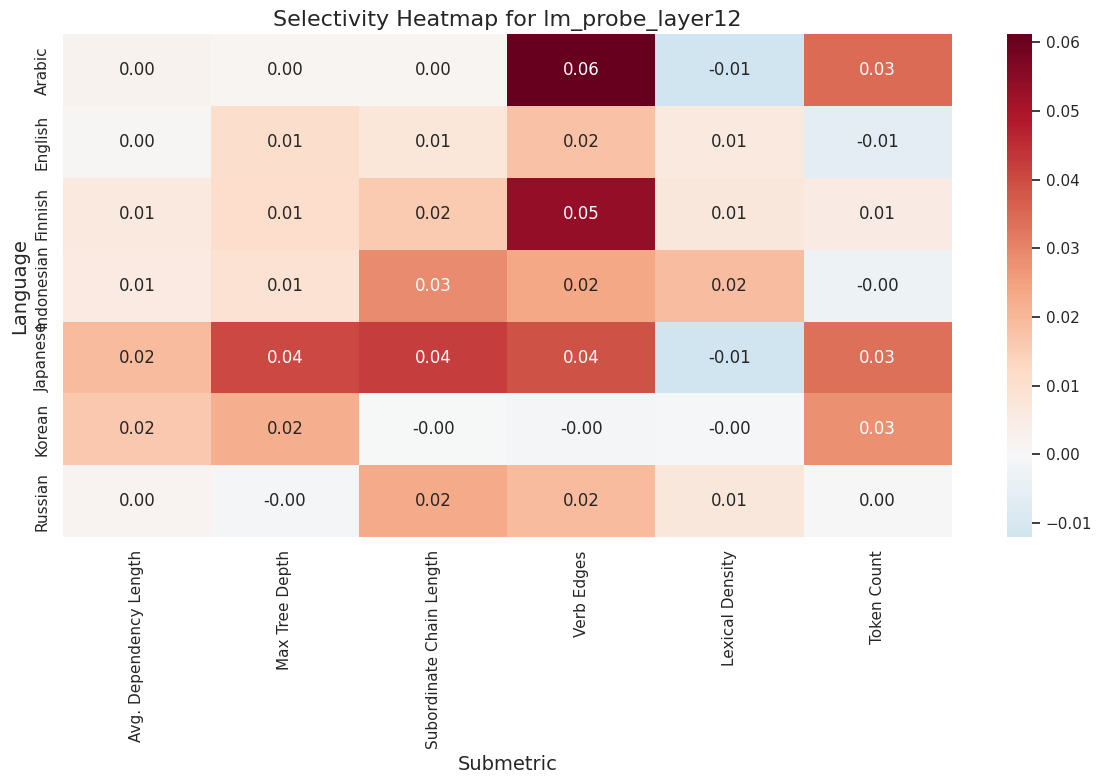

In [8]:
sns.set_theme(style="whitegrid")
plt.rcParams['figure.figsize'] = [16, 12]
plt.rcParams['font.size'] = 12

SUBMETRIC_NAMES = {
    'avg_links_len': 'Avg. Dependency Length',
    'avg_max_depth': 'Max Tree Depth',
    'avg_subordinate_chain_len': 'Subordinate Chain Length',
    'avg_verb_edges': 'Verb Edges',
    'lexical_density': 'Lexical Density',
    'n_tokens': 'Token Count'
}

LANGUAGE_NAMES = {'ar': 'Arabic', 'en': 'English', 'fi': 'Finnish', 'id': 'Indonesian', 'ja': 'Japanese', 'ko': 'Korean', 'ru': 'Russian'}

def read_csv_file(filepath):
    try:
        df = pd.read_csv(filepath)
        print(f"Successfully read {filepath}")
        return df
    except Exception as e:
        print(f"Error reading {filepath}: {e}")
        return None

def extract_results_with_controls(df, model_name):
    if df is None:
        return {}

    print(f"Columns in {model_name} dataframe: {df.columns.tolist()}")

    expected_columns = ['language', 'real', 'control1', 'control2', 'control3']
    alt_names = {'control1': 'control_1', 'control2': 'control_2', 'control3': 'control_3'}

    for col in expected_columns:
        if col not in df.columns and col in alt_names and alt_names[col] in df.columns:
            df[col] = df[alt_names[col]]

    missing = [col for col in expected_columns if col not in df.columns]
    if missing:
        print(f"Missing columns: {missing}")
        return {}

    results = {}
    for _, row in df.iterrows():
        lang = row['language']
        results[lang] = {
            'real': row['real'],
            'control1': row['control1'],
            'control2': row['control2'],
            'control3': row['control3']
        }
    return results

def compute_mse_selectivity(real, control1, control2, control3):
    avg_control = (control1 + control2 + control3) / 3
    return avg_control - real

def create_submetric_selectivity_tables():
    submetrics = list(SUBMETRIC_NAMES.keys())
    models = ['Ridge', 'XGBRegressor', 'lm_probe']
    layers = ['2', '6', '11', '12']

    all_results = {}
    for submetric in submetrics:
        submetric_results = {}
        for model in models:
            if model == 'lm_probe':
                for layer in layers:
                    name = f"{model}_layer{layer}"
                    file_path = f"/home/robin/Research/qtype-eval/scripts/analysis/single_submetric_lm_probe_mse_test_{submetric}_layer{layer}_table.csv"
                    df = read_csv_file(file_path)
                    submetric_results[name] = extract_results_with_controls(df, name)
            else:
                file_path = f"/home/robin/Research/qtype-eval/scripts/analysis/complexity_{model}_mse_test_{submetric}_table.csv"
                df = read_csv_file(file_path)
                submetric_results[model] = extract_results_with_controls(df, f"{model}_{submetric}")
        all_results[submetric] = submetric_results

    submetric_dataframes = {}
    for submetric, results in all_results.items():
        all_langs = sorted(set(lang for model in results.values() for lang in model.keys()))
        real_data, control_data, selectivity_data = {'Language': all_langs}, {'Language': all_langs}, {'Language': all_langs}
        for model, langscores in results.items():
            real_col, control_col, select_col = [], [], []
            for lang in all_langs:
                if lang in langscores:
                    vals = langscores[lang]
                    real = vals['real']
                    c1, c2, c3 = vals['control1'], vals['control2'], vals['control3']
                    avg = (c1 + c2 + c3) / 3
                    sel = compute_mse_selectivity(real, c1, c2, c3)
                    real_col.append(real)
                    control_col.append(avg)
                    select_col.append(sel)
                else:
                    real_col.append(np.nan)
                    control_col.append(np.nan)
                    select_col.append(np.nan)
            real_data[model] = real_col
            control_data[model] = control_col
            selectivity_data[model] = select_col

        submetric_dataframes[submetric] = {
            'real': pd.DataFrame(real_data),
            'control_avg': pd.DataFrame(control_data),
            'selectivity': pd.DataFrame(selectivity_data)
        }
    return submetric_dataframes



def plot_submetric_selectivity_grid(submetric_dataframes):
    n_submetrics = len(submetric_dataframes)
    
    n_rows = 2
    n_cols = 3
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, 12), sharex=True)
    
    axes_flat = axes.flatten()
    
    all_models = set()
    for submetric_data in submetric_dataframes.values():
        all_models.update([col for col in submetric_data['selectivity'].columns if col != 'Language'])
    
    model_colors = sns.color_palette('viridis', len(all_models))
    model_color_dict = dict(zip(sorted(all_models), model_colors))
    
    for i, (submetric, data) in enumerate(submetric_dataframes.items()):
        if i < len(axes_flat):
            ax = axes_flat[i]
            
            df_selectivity = data['selectivity']
            
            plot_columns = [col for col in df_selectivity.columns if col != 'Language']
            
            plot_df = df_selectivity[['Language'] + plot_columns].copy()
            
            if 'Language' in plot_df.columns:
                plot_df['Language'] = plot_df['Language'].map(lambda x: LANGUAGE_NAMES.get(x, x))
                
            plot_df_melted = pd.melt(plot_df, id_vars=['Language'], 
                                    var_name='Model', value_name='Selectivity')
            
            sns.barplot(x='Language', y='Selectivity', hue='Model', data=plot_df_melted, 
                       palette=model_color_dict, ax=ax)
            
            ax.set_title(SUBMETRIC_NAMES.get(submetric, submetric), fontsize=14)
            
            ax.set_xlabel('')
            if i % n_cols == 0:  # First column
                ax.set_ylabel('Selectivity (mse)', fontsize=12)
            else:
                ax.set_ylabel('')
            
            plt.setp(ax.get_xticklabels(), rotation=45, ha='right')
            
            # Add a horizontal line at y=0
            ax.axhline(y=0, color='r', linestyle='-', alpha=0.3)
            ax.set_ylim(bottom=None)
            
            # Add value labels
            for container in ax.containers:
                ax.bar_label(container, fmt='%.2f', padding=3, fontsize=7)
            
            # Adjust legend - only show on the last plot to save space
            if i == len(submetric_dataframes) - 1:
                ax.legend(title='Model', bbox_to_anchor=(1.05, 1), loc='upper left')
            else:
                ax.legend().set_visible(False)
    
    # Remove any unused subplots
    for j in range(i + 1, len(axes_flat)):
        fig.delaxes(axes_flat[j])
    
    # Add a common title
    plt.suptitle('Linguistic Complexity Submetric Selectivity Across Languages', fontsize=16, y=0.98)
    
    # Adjust layout
    plt.tight_layout(rect=[0, 0, 1, 0.96])  # Make room for the suptitle
    
    # Save the figure
    plt.savefig('submetric_selectivity_grid.png', dpi=300, bbox_inches='tight')
    print("Faceted grid saved as 'submetric_selectivity_grid.png'")
    
    return fig

def create_submetrics_heatmap(submetric_dataframes):
    model_to_use = 'lm_probe_layer12'
    heatmap_data = {}
    
    for submetric, data in submetric_dataframes.items():
        df_selectivity = data['selectivity']
        
        if model_to_use in df_selectivity.columns:
            for i, lang in enumerate(df_selectivity['Language']):
                if lang not in heatmap_data:
                    heatmap_data[lang] = {}
                
                heatmap_data[lang][submetric] = df_selectivity.at[i, model_to_use]
    heatmap_df = pd.DataFrame(heatmap_data).T
    
    heatmap_df.index = [LANGUAGE_NAMES.get(lang, lang) for lang in heatmap_df.index]
    heatmap_df.columns = [SUBMETRIC_NAMES.get(subm, subm) for subm in heatmap_df.columns]
    
    # Create the heatmap
    plt.figure(figsize=(12, 8))
    ax = sns.heatmap(heatmap_df, annot=True, cmap='RdBu_r', center=0, fmt='.2f')
    
    # Set title and labels
    plt.title(f'Selectivity Heatmap for {model_to_use}', fontsize=16)
    plt.ylabel('Language', fontsize=14)
    plt.xlabel('Submetric', fontsize=14)
    
    # Adjust layout
    plt.tight_layout()
    
    # Save the figure
    plt.savefig('submetric_selectivity_heatmap.png', dpi=300, bbox_inches='tight')
    print("Heatmap saved as 'submetric_selectivity_heatmap.png'")
    
    return ax

# Main execution
if __name__ == "__main__":
    print("\n=== Processing Submetric Selectivity Analysis ===")
    
    # Create selectivity tables for all submetrics
    submetric_dataframes = create_submetric_selectivity_tables()
    
    # Plot faceted grid
    plot_submetric_selectivity_grid(submetric_dataframes)
    
    # Create heatmap for overall view
    create_submetrics_heatmap(submetric_dataframes)
    
    # Save tables to CSV and LaTeX
    for submetric, dataframes in submetric_dataframes.items():
        for metric_type, df in dataframes.items():
            # Save to CSV
            csv_filename = f"submetric_{submetric}_{metric_type}.csv"
            df.round(3).to_csv(csv_filename, index=False)
            print(f"Saved {csv_filename}")
            
            # Save to LaTeX
            latex_filename = f"submetric_{submetric}_{metric_type}_latex.tex"
            latex_content = df.round(3).to_latex(index=False)
            with open(latex_filename, 'w') as f:
                f.write(latex_content)
            print(f"Saved {latex_filename}")
    
    print("\nAll submetric analyses completed successfully!")

<Axes: title={'center': 'Selectivity Heatmap for lm_probe_layer6'}, xlabel='Submetric', ylabel='Language'>

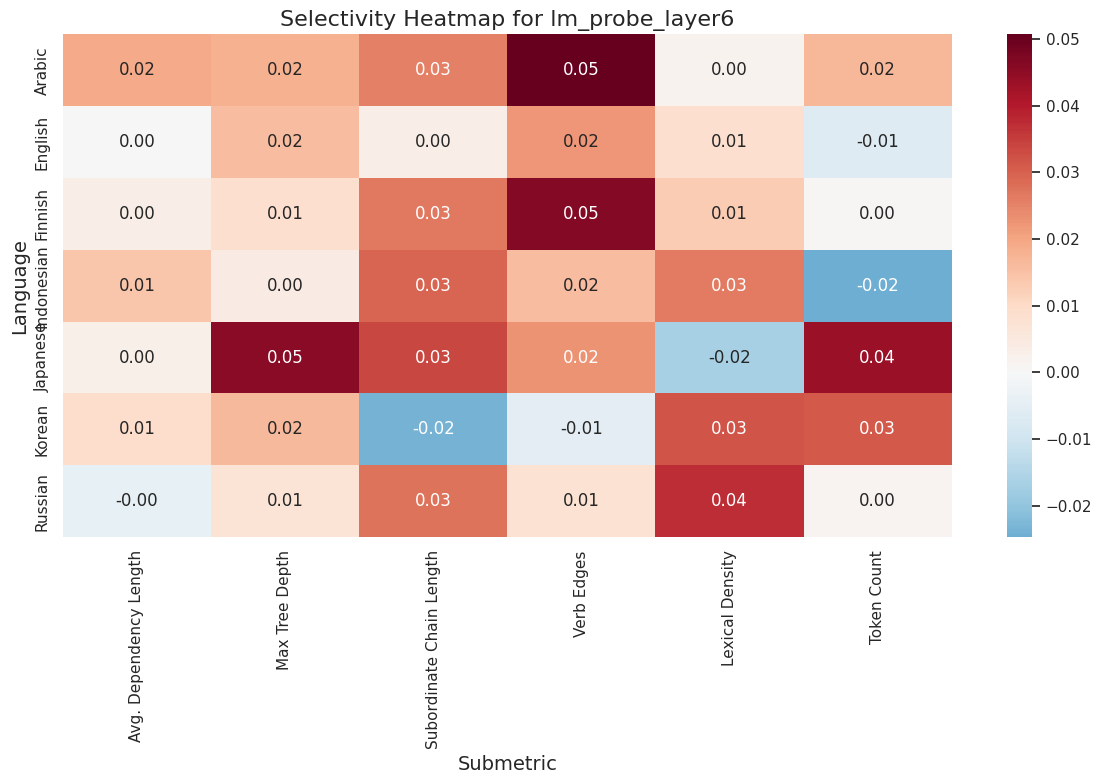

In [18]:
def create_submetrics_heatmap(submetric_dataframes):
    model_to_use = 'lm_probe_layer6'
    heatmap_data = {}
    
    for submetric, data in submetric_dataframes.items():
        df_selectivity = data['selectivity']
        
        if model_to_use in df_selectivity.columns:
            for i, lang in enumerate(df_selectivity['Language']):
                if lang not in heatmap_data:
                    heatmap_data[lang] = {}
                
                heatmap_data[lang][submetric] = df_selectivity.at[i, model_to_use]
    heatmap_df = pd.DataFrame(heatmap_data).T
    
    heatmap_df.index = [LANGUAGE_NAMES.get(lang, lang) for lang in heatmap_df.index]
    heatmap_df.columns = [SUBMETRIC_NAMES.get(subm, subm) for subm in heatmap_df.columns]
    
    # Create the heatmap
    plt.figure(figsize=(12, 8))
    ax = sns.heatmap(heatmap_df, annot=True, cmap='RdBu_r', center=0, fmt='.2f')
    
    # Set title and labels
    plt.title(f'Selectivity Heatmap for {model_to_use}', fontsize=16)
    plt.ylabel('Language', fontsize=14)
    plt.xlabel('Submetric', fontsize=14)
    
    # Adjust layout
    plt.tight_layout()
    
   
    return ax

create_submetrics_heatmap(submetric_dataframes)

<Axes: title={'center': 'Selectivity Heatmap for lm_probe_layer11'}, xlabel='Submetric', ylabel='Language'>

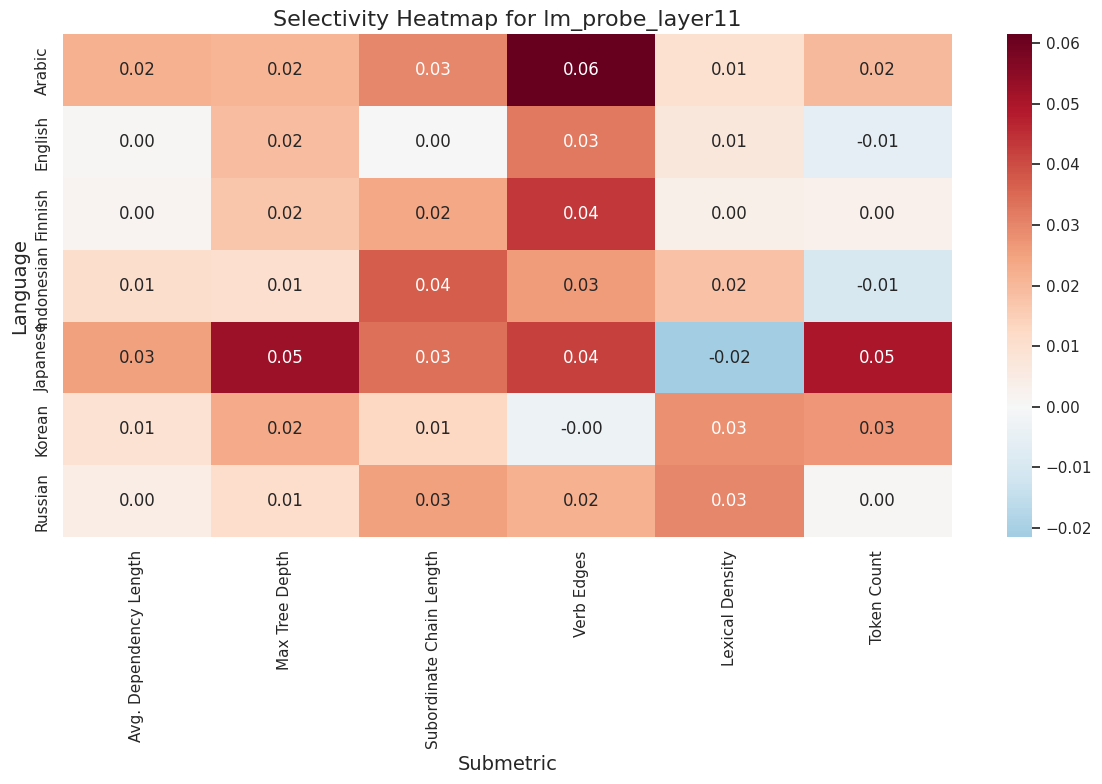

In [19]:
def create_submetrics_heatmap(submetric_dataframes):
    model_to_use = 'lm_probe_layer11'
    heatmap_data = {}
    
    for submetric, data in submetric_dataframes.items():
        df_selectivity = data['selectivity']
        
        if model_to_use in df_selectivity.columns:
            for i, lang in enumerate(df_selectivity['Language']):
                if lang not in heatmap_data:
                    heatmap_data[lang] = {}
                
                heatmap_data[lang][submetric] = df_selectivity.at[i, model_to_use]
    heatmap_df = pd.DataFrame(heatmap_data).T
    
    heatmap_df.index = [LANGUAGE_NAMES.get(lang, lang) for lang in heatmap_df.index]
    heatmap_df.columns = [SUBMETRIC_NAMES.get(subm, subm) for subm in heatmap_df.columns]
    
    # Create the heatmap
    plt.figure(figsize=(12, 8))
    ax = sns.heatmap(heatmap_df, annot=True, cmap='RdBu_r', center=0, fmt='.2f')
    
    # Set title and labels
    plt.title(f'Selectivity Heatmap for {model_to_use}', fontsize=16)
    plt.ylabel('Language', fontsize=14)
    plt.xlabel('Submetric', fontsize=14)
    
    # Adjust layout
    plt.tight_layout()
    
   
    return ax

create_submetrics_heatmap(submetric_dataframes)

<Axes: title={'center': 'Selectivity Heatmap for lm_probe_layer12'}, xlabel='Submetric', ylabel='Language'>

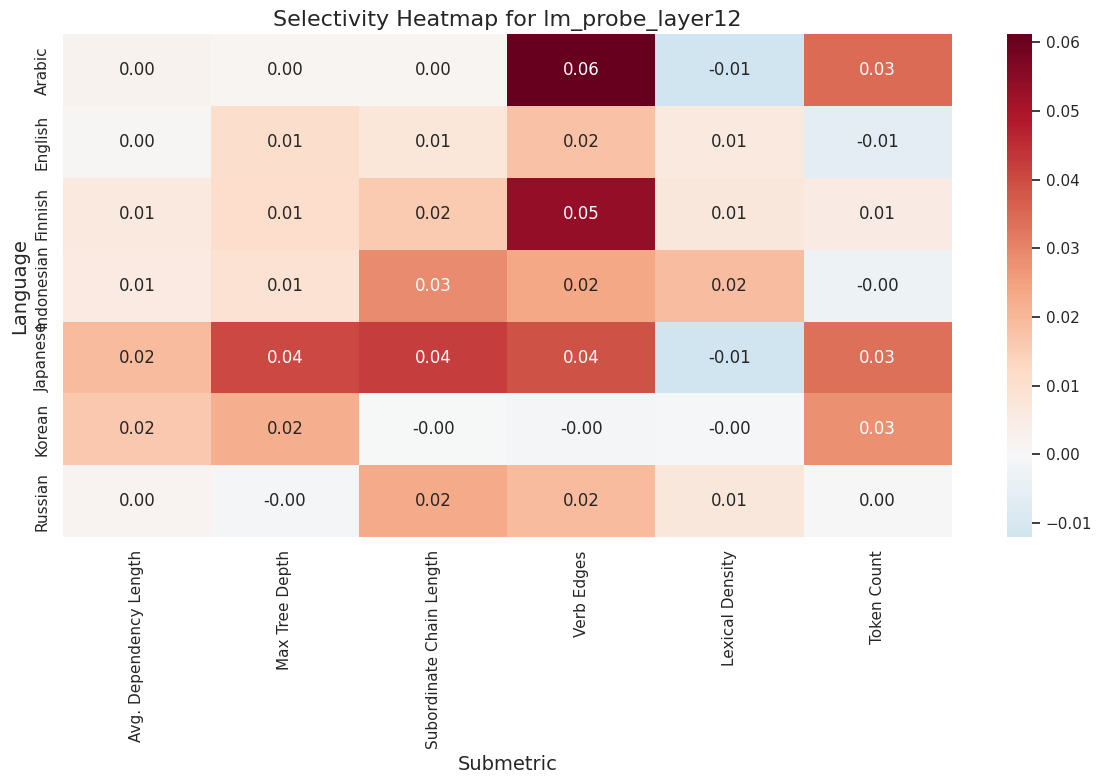

In [9]:
def create_submetrics_heatmap(submetric_dataframes):
    model_to_use = 'lm_probe_layer12'
    heatmap_data = {}
    
    for submetric, data in submetric_dataframes.items():
        df_selectivity = data['selectivity']
        
        if model_to_use in df_selectivity.columns:
            for i, lang in enumerate(df_selectivity['Language']):
                if lang not in heatmap_data:
                    heatmap_data[lang] = {}
                
                heatmap_data[lang][submetric] = df_selectivity.at[i, model_to_use]
    heatmap_df = pd.DataFrame(heatmap_data).T
    
    heatmap_df.index = [LANGUAGE_NAMES.get(lang, lang) for lang in heatmap_df.index]
    heatmap_df.columns = [SUBMETRIC_NAMES.get(subm, subm) for subm in heatmap_df.columns]
    
    # Create the heatmap
    plt.figure(figsize=(12, 8))
    ax = sns.heatmap(heatmap_df, annot=True, cmap='RdBu_r', center=0, fmt='.2f')
    
    # Set title and labels
    plt.title(f'Selectivity Heatmap for {model_to_use}', fontsize=16)
    plt.ylabel('Language', fontsize=14)
    plt.xlabel('Submetric', fontsize=14)
    
    # Adjust layout
    plt.tight_layout()
    
   
    return ax

create_submetrics_heatmap(submetric_dataframes)

In [4]:

plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['font.size'] = 12
sns.set_theme(style="whitegrid")

LANGUAGE_NAMES = {
    'ar': 'Arabic', 'en': 'English', 'fi': 'Finnish', 'id': 'Indonesian',
    'ja': 'Japanese', 'ko': 'Korean', 'ru': 'Russian'
}

SUBMETRIC_NAMES = {
    'avg_links_len': 'Avg. Dependency Length',
    'avg_max_depth': 'Max Tree Depth',
    'avg_subordinate_chain_len': 'Subordinate Chain Length',
    'avg_verb_edges': 'Verb Edges',
    'lexical_density': 'Lexical Density',
    'n_tokens': 'Token Count'
}

def safe_read_csv(path):
    try:
        return pd.read_csv(path)
    except Exception as e:
        print(f"Error reading {path}: {e}")
        return pd.DataFrame()

def compute_avg_control(row):
    return np.mean([row['control1'], row['control2'], row['control3']])

def safe_selectivity_rmse(row, epsilon=1e-3):
    if row['real'] < epsilon:
        return np.nan
    control_avg = compute_avg_control(row)
    return (control_avg - row['real']) / control_avg

# Table 1: Classification Accuracy (real values only)
def generate_table_classification_accuracy():
    models = [
        ('Dummy', '/home/robin/Research/qtype-eval/scripts/analysis/question_type_DummyClassifier_accuracy_test_table.csv'),
        ('LogReg', '/home/robin/Research/qtype-eval/scripts/analysis/question_type_LogisticRegression_accuracy_test_table.csv'),
        ('XGBoost', '/home/robin/Research/qtype-eval/scripts/analysis/question_type_XGBClassifier_accuracy_test_table.csv'),
        ('LM-L2', '/home/robin/Research/qtype-eval/scripts/analysis/question_type_lm_probe_accuracy_test_overall_layer2_table.csv'),
        ('LM-L6', '/home/robin/Research/qtype-eval/scripts/analysis/question_type_lm_probe_accuracy_test_overall_layer6_table.csv'),
        ('LM-L11', '/home/robin/Research/qtype-eval/scripts/analysis/question_type_lm_probe_accuracy_test_overall_layer11_table.csv'),
        ('LM-L12', '/home/robin/Research/qtype-eval/scripts/analysis/question_type_lm_probe_accuracy_test_overall_layer12_table.csv'),
    ]

    all_langs = set()
    accuracy = {}

    for model_name, file_path in models:
        df = safe_read_csv(file_path)
        if not df.empty:
            df['language'] = df['language'].map(lambda x: LANGUAGE_NAMES.get(x, x))
            accuracy[model_name] = dict(zip(df['language'], df['real']))
            all_langs.update(df['language'])

    all_langs = sorted(all_langs)
    table = pd.DataFrame({'Language': all_langs})

    for model in accuracy:
        table[model] = table['Language'].map(accuracy[model])

    table['Average'] = table.drop(columns=['Language']).mean(axis=1)

    print("\nTable 1: Classification Accuracy")
    print(table.round(3))
    table.to_csv("table_classification_accuracy.csv", index=False)
    print("Saved as table_classification_accuracy.csv")
    return table

# Run this cell:
generate_table_classification_accuracy()



# Table 2: Complexity RMSE (real values only)
def generate_table_complexity_rmse():
    models = [
        ('Dummy', '/home/robin/Research/qtype-eval/scripts/analysis/complexity_DummyRegressor_rmse_test_table.csv'),
        ('Ridge', '/home/robin/Research/qtype-eval/scripts/analysis/complexity_Ridge_rmse_test_table.csv'),
        ('XGBoost', '/home/robin/Research/qtype-eval/scripts/analysis/complexity_XGBRegressor_rmse_test_table.csv'),
        ('LM-L2', '/home/robin/Research/qtype-eval/scripts/analysis/complexity_lm_probe_rmse_test_complexity_layer2_table.csv'),
        ('LM-L6', '/home/robin/Research/qtype-eval/scripts/analysis/complexity_lm_probe_rmse_test_complexity_layer6_table.csv'),
        ('LM-L11', '/home/robin/Research/qtype-eval/scripts/analysis/complexity_lm_probe_rmse_test_complexity_layer11_table.csv'),
        ('LM-L12', '/home/robin/Research/qtype-eval/scripts/analysis/complexity_lm_probe_rmse_test_complexity_layer12_table.csv'),
    ]

    all_langs = set()
    rmse_vals = {}

    for model_name, file_path in models:
        df = safe_read_csv(file_path)
        if not df.empty:
            df['language'] = df['language'].map(lambda x: LANGUAGE_NAMES.get(x, x))
            rmse_vals[model_name] = dict(zip(df['language'], df['real']))
            all_langs.update(df['language'])

    all_langs = sorted(all_langs)
    table = pd.DataFrame({'Language': all_langs})

    for model in rmse_vals:
        table[model] = table['Language'].map(rmse_vals[model])

    table['Average'] = table.drop(columns=['Language']).mean(axis=1)

    print("\nTable 2: Complexity RMSE")
    print(table.round(3))
    table.to_csv("table_complexity_rmse.csv", index=False)
    print("Saved as table_complexity_rmse.csv")
    return table

generate_table_complexity_rmse()



def generate_table_submetric_rmse():
    submetrics = list(SUBMETRIC_NAMES.keys())
    models = ['Ridge', 'XGBRegressor']
    layers = ['2', '6', '11', '12']
    model_lookup = {'Ridge': 'complexity_Ridge_rmse_test_{}_table.csv',
                    'XGBRegressor': 'complexity_XGBRegressor_rmse_test_{}_table.csv',
                    'lm_probe_layer{}': 'single_submetric_lm_probe_rmse_test_{}_layer{}_table.csv'}

    full_table = []
    for submetric in submetrics:
        row = {'Submetric': SUBMETRIC_NAMES[submetric]}

        # ML models
        for model in models:
            path = f"/home/robin/Research/qtype-eval/scripts/analysis/" + model_lookup[model].format(submetric)
            df = safe_read_csv(path)
            row[model] = df['real'].mean() if 'real' in df else np.nan

        # LM probes
        for layer in layers:
            key = f"lm_probe_layer{layer}"
            path = f"/home/robin/Research/qtype-eval/scripts/analysis/" + model_lookup['lm_probe_layer{}'].format(submetric, layer)
            df = safe_read_csv(path)
            row[key] = df['real'].mean() if 'real' in df else np.nan

        full_table.append(row)

    table = pd.DataFrame(full_table)
    print("\nTable 3: RMSE per Submetric (averaged across languages)")
    print(table.round(3))
    table.to_csv("table_submetric_rmse.csv", index=False)
    print("Saved as table_submetric_rmse.csv")
    return table

generate_table_submetric_rmse()



Table 1: Classification Accuracy
     Language  Dummy  LogReg  XGBoost  LM-L2  LM-L6  LM-L11  LM-L12  Average
0      Arabic  0.714   0.987    0.987  0.974  0.961   0.844   0.831    0.900
1     English  0.500   0.791    0.736  0.891  0.918   0.918   0.945    0.814
2     Finnish  0.500   0.845    0.809  0.864  0.918   0.891   0.900    0.818
3  Indonesian  0.500   0.573    0.691  0.573  0.618   0.636   0.745    0.619
4    Japanese  0.402   0.652    0.641  0.641  0.739   0.859   0.859    0.685
5      Korean  0.500   0.664    0.664  0.591  0.709   0.873   0.864    0.695
6     Russian  0.500   0.800    0.873  0.991  0.936   0.936   0.900    0.848
Saved as table_classification_accuracy.csv

Table 2: Complexity RMSE
     Language  Dummy  Ridge  XGBoost  LM-L2  LM-L6  LM-L11  LM-L12  Average
0      Arabic  0.243  0.196    0.206  0.212  0.250   0.287   0.224    0.231
1     English  0.197  0.142    0.124  0.113  0.149   0.115   0.161    0.143
2     Finnish  0.201  0.168    0.139  0.136  0.143   

,Submetric,Ridge,XGBRegressor,lm_probe_layer2,lm_probe_layer6,lm_probe_layer11,lm_probe_layer12
0,Avg. Dependency Length,0.161238,0.172921,0.175680,0.163249,0.162869,0.172832
1,Max Tree Depth,0.155108,0.154980,0.144030,0.150878,0.136349,0.167631
2,Subordinate Chain Length,0.197365,0.211246,0.204169,0.200066,0.189735,0.206162
3,Verb Edges,0.248675,0.257828,0.244125,0.221072,0.207978,0.217620
4,Lexical Density,0.225748,0.232024,0.229293,0.209709,0.213844,0.226099
5,Token Count,0.162547,0.152645,0.154664,0.170762,0.167100,0.166594


In [4]:
LANGUAGE_NAMES = {
    'ar': 'Arabic', 'en': 'English', 'fi': 'Finnish', 'id': 'Indonesian',
    'ja': 'Japanese', 'ko': 'Korean', 'ru': 'Russian'
}

SUBMETRIC_NAMES = {
    'avg_links_len': 'Avg. Dependency Length',
    'avg_max_depth': 'Max Tree Depth',
    'avg_subordinate_chain_len': 'Subordinate Chain Length',
    'avg_verb_edges': 'Verb Edges',
    'lexical_density': 'Lexical Density',
    'n_tokens': 'Token Count'
}

def safe_read_csv(path):
    try:
        return pd.read_csv(path)
    except Exception as e:
        print(f"Error reading {path}: {e}")
        return pd.DataFrame()

def compute_avg_control(row):
    return np.mean([row['control1'], row['control2'], row['control3']])

def safe_selectivity_rmse(row, epsilon=1e-3):
    if abs(row['real']) < epsilon:
        return np.nan
    control_avg = compute_avg_control(row)
    if abs(control_avg) < epsilon:
        return np.nan
    return (control_avg - row['real']) / control_avg

# Table 1: Classification Accuracy (real values only)
def generate_table_classification_accuracy():
    """Generate a table with classification accuracy for each model and language."""
    models = [
        ('Dummy', '/home/robin/Research/qtype-eval/scripts/analysis/question_type_DummyClassifier_accuracy_test_table.csv'),
        ('LogReg', '/home/robin/Research/qtype-eval/scripts/analysis/question_type_LogisticRegression_accuracy_test_table.csv'),
        ('XGBoost', '/home/robin/Research/qtype-eval/scripts/analysis/question_type_XGBClassifier_accuracy_test_table.csv'),
        ('LM-L2', '/home/robin/Research/qtype-eval/scripts/analysis/question_type_lm_probe_accuracy_test_overall_layer2_table.csv'),
        ('LM-L6', '/home/robin/Research/qtype-eval/scripts/analysis/question_type_lm_probe_accuracy_test_overall_layer6_table.csv'),
        ('LM-L11', '/home/robin/Research/qtype-eval/scripts/analysis/question_type_lm_probe_accuracy_test_overall_layer11_table.csv'),
        ('LM-L12', '/home/robin/Research/qtype-eval/scripts/analysis/question_type_lm_probe_accuracy_test_overall_layer12_table.csv'),
    ]

    all_langs = set()
    accuracy = {}

    for model_name, file_path in models:
        df = safe_read_csv(file_path)
        if not df.empty:
            df['language'] = df['language'].map(lambda x: LANGUAGE_NAMES.get(x, x))
            accuracy[model_name] = dict(zip(df['language'], df['real']))
            all_langs.update(df['language'])

    all_langs = sorted(all_langs)
    table = pd.DataFrame({'Language': all_langs})

    for model in accuracy:
        table[model] = table['Language'].map(accuracy[model])

    table['Average'] = table.drop(columns=['Language']).mean(axis=1)

    print("\nTable 1: Classification Accuracy")
    print(table.round(3))
    table.to_csv("table_classification_accuracy.csv", index=False)
    print("Saved as table_classification_accuracy.csv")
    return table


generate_table_classification_accuracy()
    


Table 1: Classification Accuracy
     Language  Dummy  LogReg  XGBoost  LM-L2  LM-L6  LM-L11  LM-L12  Average
0      Arabic  0.714   0.987    0.987  0.974  0.961   0.844   0.831    0.900
1     English  0.500   0.791    0.736  0.891  0.918   0.918   0.945    0.814
2     Finnish  0.500   0.845    0.809  0.864  0.918   0.891   0.900    0.818
3  Indonesian  0.500   0.573    0.691  0.573  0.618   0.636   0.745    0.619
4    Japanese  0.402   0.652    0.641  0.641  0.739   0.859   0.859    0.685
5      Korean  0.500   0.664    0.664  0.591  0.709   0.873   0.864    0.695
6     Russian  0.500   0.800    0.873  0.991  0.936   0.936   0.900    0.848
Saved as table_classification_accuracy.csv


,Language,Dummy,LogReg,XGBoost,LM-L2,LM-L6,LM-L11,LM-L12,Average
0,Arabic,0.714286,0.987013,0.987013,0.974026,0.961039,0.844156,0.831169,0.899814
1,English,0.500000,0.790909,0.736364,0.890909,0.918182,0.918182,0.945455,0.814286
2,Finnish,0.500000,0.845455,0.809091,0.863636,0.918182,0.890909,0.900000,0.818182
3,Indonesian,0.500000,0.572727,0.690909,0.572727,0.618182,0.636364,0.745455,0.619481
4,Japanese,0.402174,0.652174,0.641304,0.641304,0.739130,0.858696,0.858696,0.684783
5,Korean,0.500000,0.663636,0.663636,0.590909,0.709091,0.872727,0.863636,0.694805
6,Russian,0.500000,0.800000,0.872727,0.990909,0.936364,0.936364,0.900000,0.848052


In [38]:
# Table 2: Complexity RMSE (real values only)
def generate_table_complexity_rmse():
    """Generate a table with complexity RMSE for each model and language."""
    models = [
        ('Dummy', '/home/robin/Research/qtype-eval/scripts/analysis/complexity_DummyRegressor_rmse_test_table.csv'),
        ('Ridge', '/home/robin/Research/qtype-eval/scripts/analysis/complexity_Ridge_rmse_test_table.csv'),
        ('XGBoost', '/home/robin/Research/qtype-eval/scripts/analysis/complexity_XGBRegressor_rmse_test_table.csv'),
        ('LM-L2', '/home/robin/Research/qtype-eval/scripts/analysis/complexity_lm_probe_rmse_test_complexity_layer2_table.csv'),
        ('LM-L6', '/home/robin/Research/qtype-eval/scripts/analysis/complexity_lm_probe_rmse_test_complexity_layer6_table.csv'),
        ('LM-L11', '/home/robin/Research/qtype-eval/scripts/analysis/complexity_lm_probe_rmse_test_complexity_layer11_table.csv'),
        ('LM-L12', '/home/robin/Research/qtype-eval/scripts/analysis/complexity_lm_probe_rmse_test_complexity_layer12_table.csv'),
    ]

    all_langs = set()
    rmse_vals = {}

    for model_name, file_path in models:
        df = safe_read_csv(file_path)
        if not df.empty:
            df['language'] = df['language'].map(lambda x: LANGUAGE_NAMES.get(x, x))
            rmse_vals[model_name] = dict(zip(df['language'], df['real']))
            all_langs.update(df['language'])

    all_langs = sorted(all_langs)
    table = pd.DataFrame({'Language': all_langs})

    for model in rmse_vals:
        table[model] = table['Language'].map(rmse_vals[model])

    table['Average'] = table.drop(columns=['Language']).mean(axis=1)

    print("\nTable 2: Complexity RMSE")
    print(table.round(3))
    table.to_csv("table_complexity_rmse.csv", index=False)
    print("Saved as table_complexity_rmse.csv")
    return table

# Table 3: Submetric RMSE (averaged across languages)
def generate_table_submetric_rmse(language='English'):
    """Generate a table with RMSE for each submetric and model, filtered by a specific language."""
    submetrics = list(SUBMETRIC_NAMES.keys())
    models = ['Ridge', 'XGBRegressor']
    layers = ['2', '6', '11', '12']
    model_lookup = {'Ridge': 'complexity_Ridge_rmse_test_{}_table.csv',
                    'XGBRegressor': 'complexity_XGBRegressor_rmse_test_{}_table.csv',
                    'lm_probe_layer{}': 'single_submetric_lm_probe_rmse_test_{}_layer{}_table.csv'}

    full_table = []
    for submetric in submetrics:
        row = {'Submetric': SUBMETRIC_NAMES[submetric]}

        # ML models
        for model in models:
            path = f"/home/robin/Research/qtype-eval/scripts/analysis/" + model_lookup[model].format(submetric)
            df = safe_read_csv(path)
            if not df.empty:
                # Filter for the specific language if requested
                if language:
                    df = df[df['language'] == language.lower()[:2]]
                row[model] = df['real'].mean() if 'real' in df.columns and not df.empty else np.nan

        # LM probes
        for layer in layers:
            key = f"lm_probe_layer{layer}"
            path = f"/home/robin/Research/qtype-eval/scripts/analysis/" + model_lookup['lm_probe_layer{}'].format(submetric, layer)
            df = safe_read_csv(path)
            if not df.empty:
                # Filter for the specific language if requested
                if language:
                    df = df[df['language'] == language.lower()[:2]]
                row[key] = df['real'].mean() if 'real' in df.columns and not df.empty else np.nan

        full_table.append(row)

    table = pd.DataFrame(full_table)
    print(f"\nTable 3: RMSE per Submetric for {language}")
    print(table.round(3))
    table.to_csv(f"table_submetric_rmse_{language.lower()}.csv", index=False)
    print(f"Saved as table_submetric_rmse_{language.lower()}.csv")
    return table

generate_table_complexity_rmse()
generate_table_submetric_rmse(language='English')

    


Table 2: Complexity RMSE
     Language  Dummy  Ridge  XGBoost  LM-L2  LM-L6  LM-L11  LM-L12  Average
0      Arabic  0.243  0.196    0.206  0.212  0.250   0.287   0.224    0.231
1     English  0.197  0.142    0.124  0.113  0.149   0.115   0.161    0.143
2     Finnish  0.201  0.168    0.139  0.136  0.143   0.143   0.169    0.157
3  Indonesian  0.202  0.145    0.141  0.149  0.208   0.159   0.249    0.179
4    Japanese  0.251  0.188    0.168  0.136  0.139   0.151   0.151    0.169
5      Korean  0.189  0.138    0.125  0.115  0.145   0.106   0.125    0.135
6     Russian  0.243  0.161    0.156  0.172  0.133   0.132   0.158    0.165
Saved as table_complexity_rmse.csv

Table 3: RMSE per Submetric for English
                  Submetric  Ridge  XGBRegressor  lm_probe_layer2  \
0    Avg. Dependency Length  0.080         0.097            0.089   
1            Max Tree Depth  0.113         0.108            0.102   
2  Subordinate Chain Length  0.124         0.128            0.126   
3             

,Submetric,Ridge,XGBRegressor,lm_probe_layer2,lm_probe_layer6,lm_probe_layer11,lm_probe_layer12
0,Avg. Dependency Length,0.079556,0.096695,0.089321,0.093152,0.102325,0.095137
1,Max Tree Depth,0.113142,0.107987,0.101529,0.106666,0.101045,0.131377
2,Subordinate Chain Length,0.124350,0.127741,0.126489,0.151617,0.161095,0.140763
3,Verb Edges,0.212820,0.224012,0.202279,0.195522,0.170309,0.207807
4,Lexical Density,0.155255,0.168179,0.136796,0.140956,0.151606,0.151676
5,Token Count,0.163828,0.135375,0.161038,0.183837,0.181761,0.175308


Complexity RMSE plot saved as 'plot_complexity_rmse.png'
Complexity RMSE comparison plot saved as 'plot_complexity_rmse_with_controls.png'
Submetric RMSE grid saved as 'submetric_rmse_grid.png'


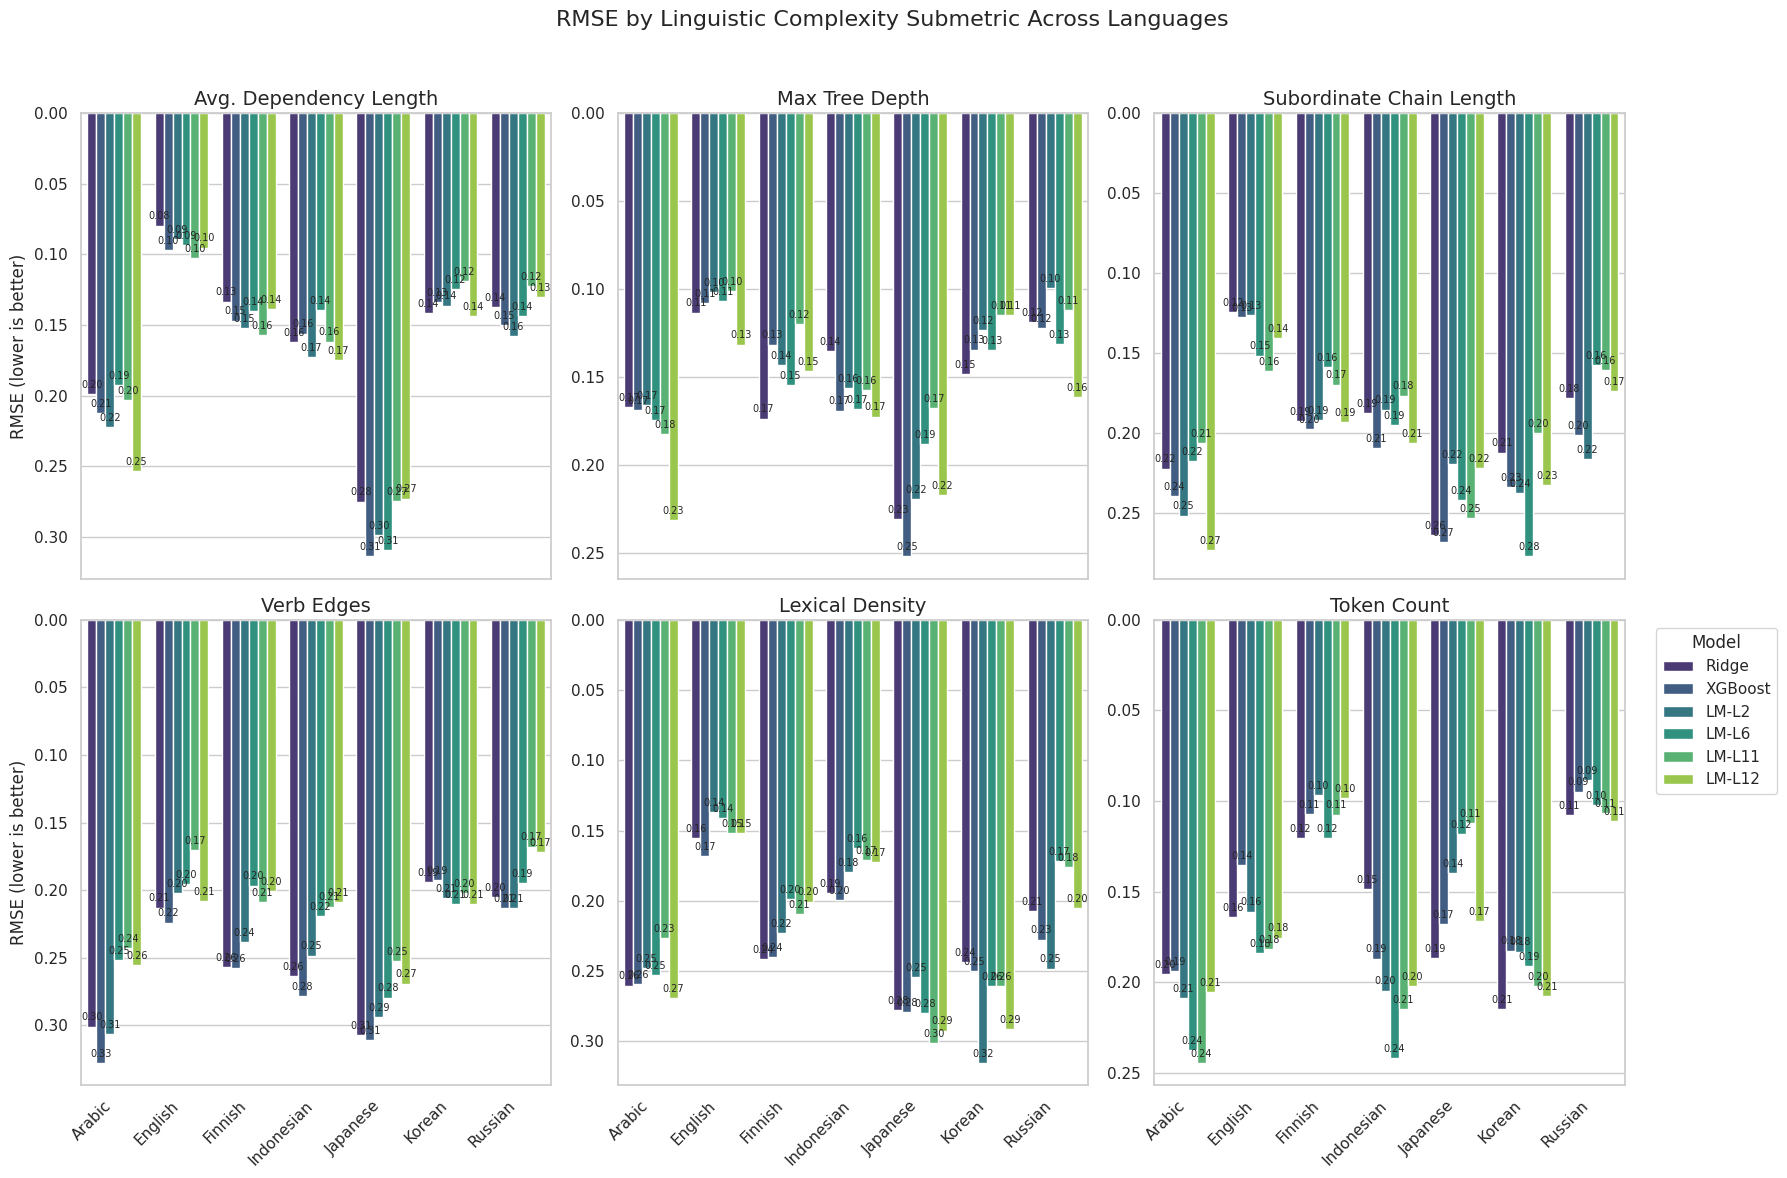

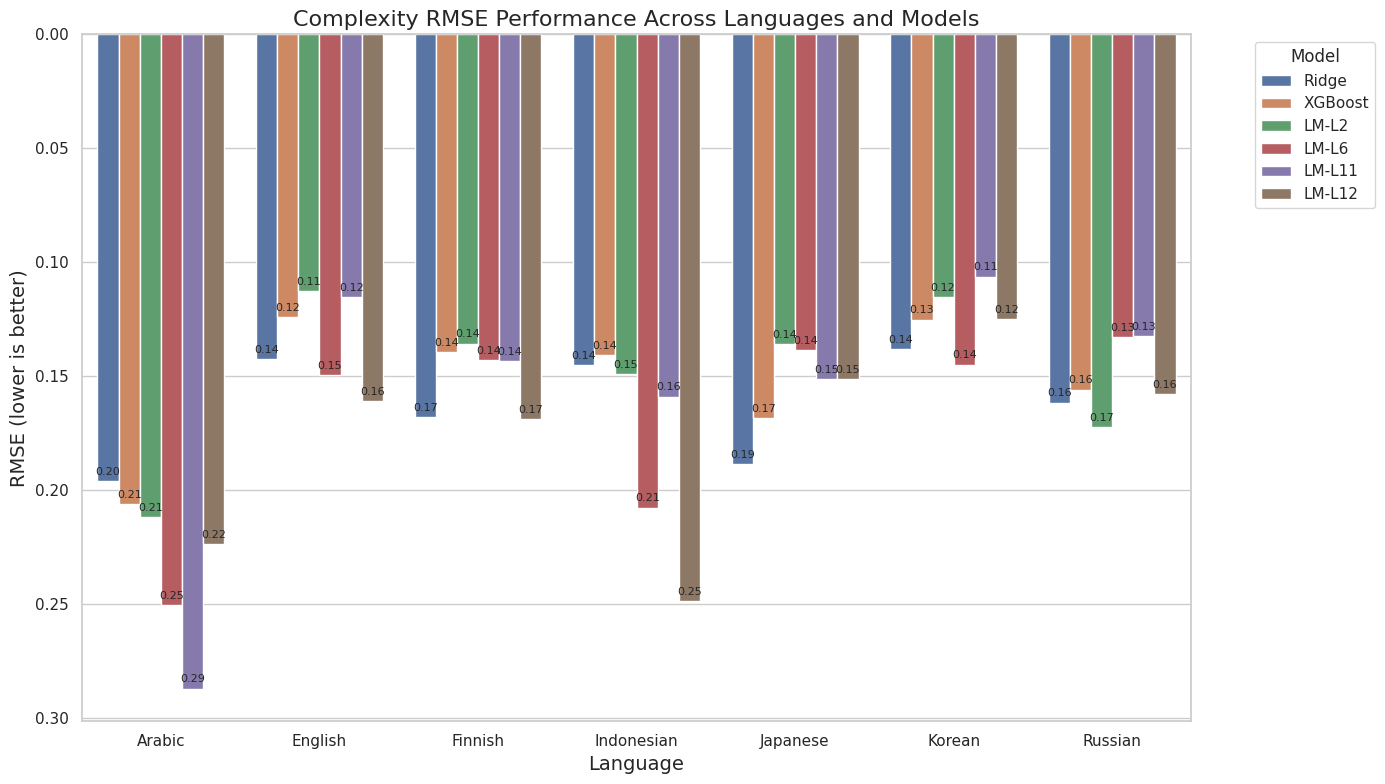

<Figure size 1600x1000 with 0 Axes>

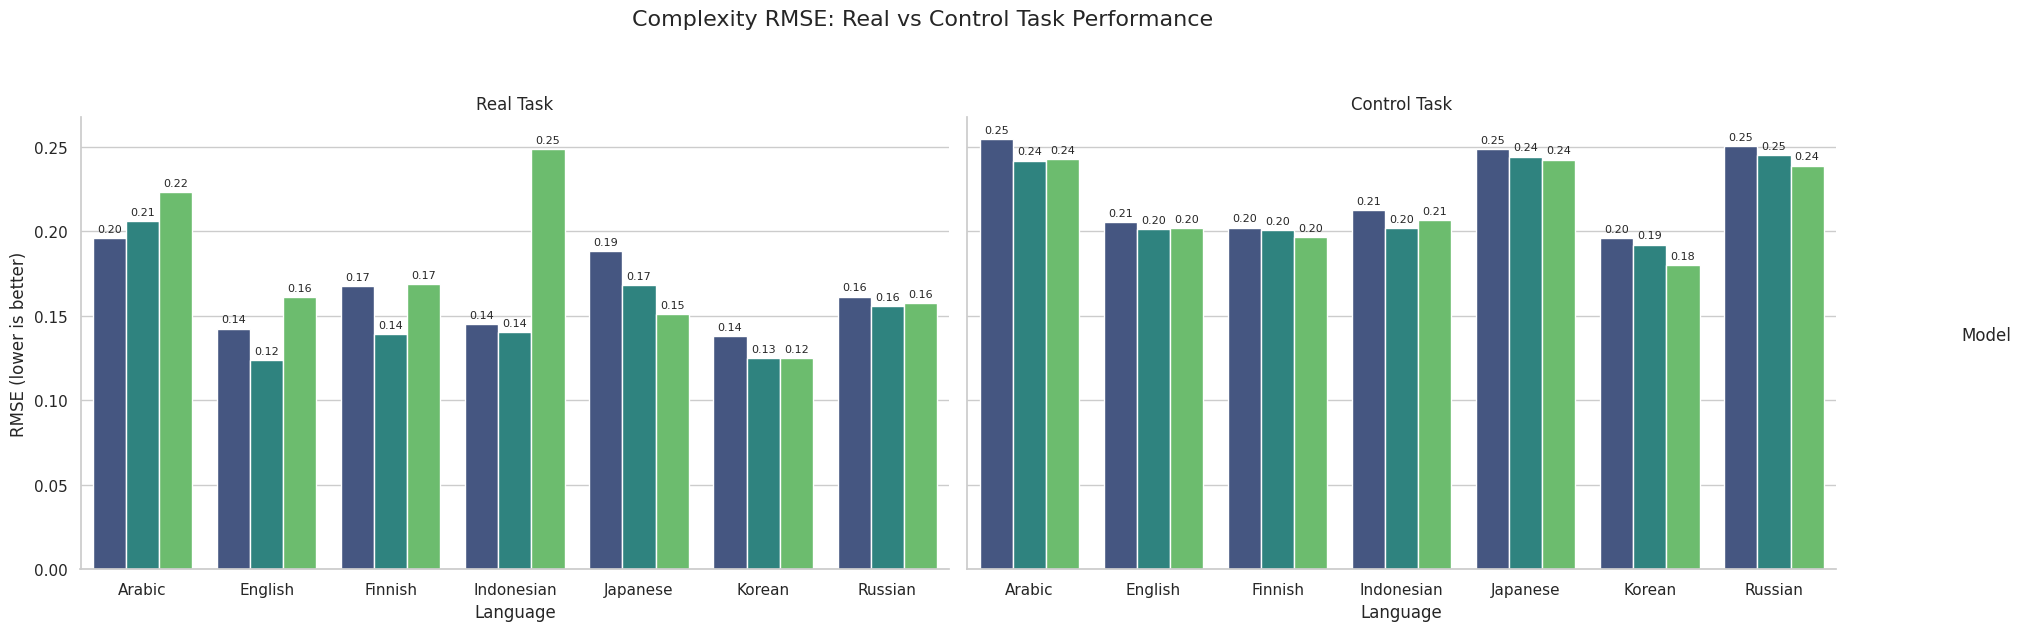

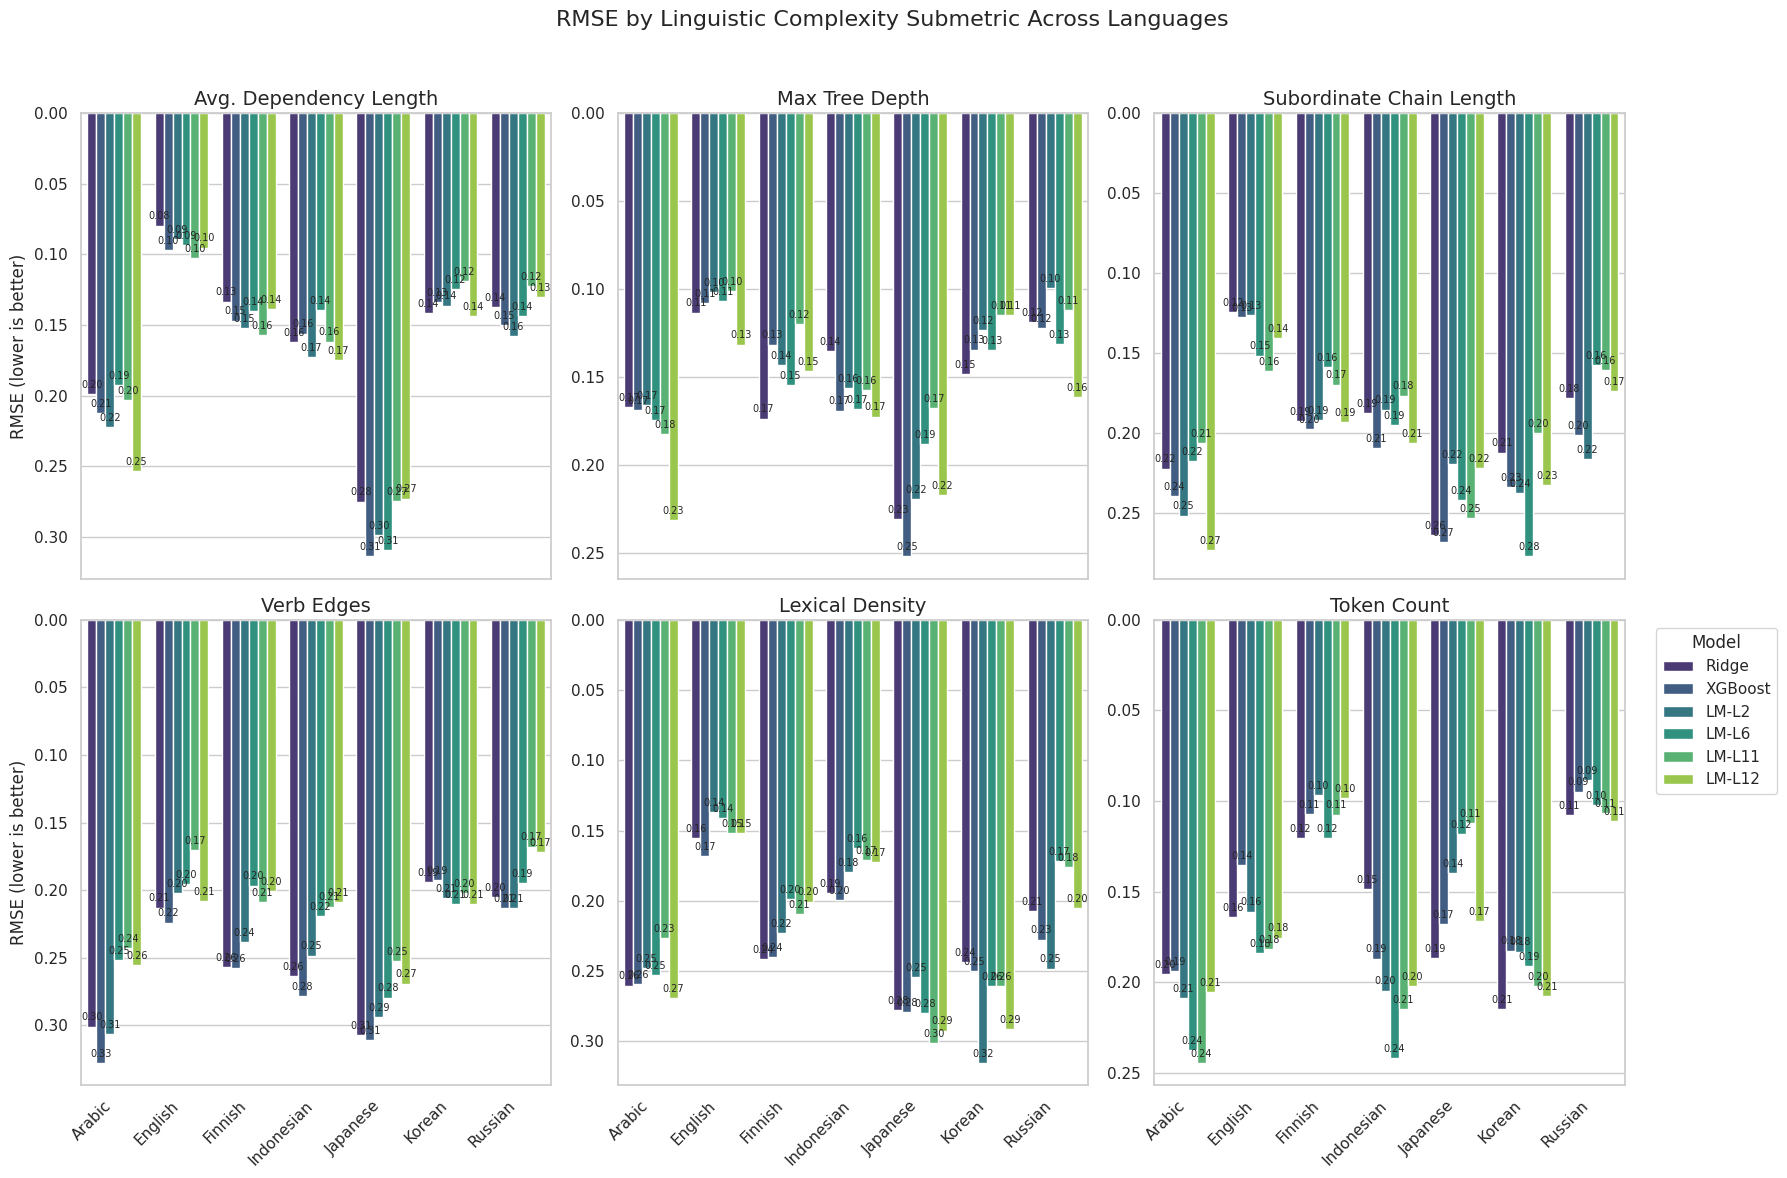

In [13]:
def plot_complexity_rmse():
    """Create a bar plot of actual RMSE performance for complexity prediction."""
    models = [
        ('Ridge', '/home/robin/Research/qtype-eval/scripts/analysis/complexity_Ridge_rmse_test_table.csv'),
        ('XGBoost', '/home/robin/Research/qtype-eval/scripts/analysis/complexity_XGBRegressor_rmse_test_table.csv'),
        ('LM-L2', '/home/robin/Research/qtype-eval/scripts/analysis/complexity_lm_probe_rmse_test_complexity_layer2_table.csv'),
        ('LM-L6', '/home/robin/Research/qtype-eval/scripts/analysis/complexity_lm_probe_rmse_test_complexity_layer6_table.csv'),
        ('LM-L11', '/home/robin/Research/qtype-eval/scripts/analysis/complexity_lm_probe_rmse_test_complexity_layer11_table.csv'),
        ('LM-L12', '/home/robin/Research/qtype-eval/scripts/analysis/complexity_lm_probe_rmse_test_complexity_layer12_table.csv'),
    ]
    
    # Process data for plotting - just using 'real' RMSE values
    data = []
    for model_name, file_path in models:
        df = safe_read_csv(file_path)
        if not df.empty and 'language' in df.columns and 'real' in df.columns:
            df['language'] = df['language'].map(lambda x: LANGUAGE_NAMES.get(x, x))
            for _, row in df.iterrows():
                data.append({
                    'Language': row['language'],
                    'Model': model_name,
                    'RMSE': row['real']
                })
    
    plot_df = pd.DataFrame(data)
    
    # Create the plot
    plt.figure(figsize=(14, 8))
    ax = sns.barplot(x='Language', y='RMSE', hue='Model', data=plot_df)
    plt.title('Complexity RMSE Performance Across Languages and Models', fontsize=16)
    plt.xlabel('Language', fontsize=14)
    plt.ylabel('RMSE (lower is better)', fontsize=14)
    plt.legend(title='Model', bbox_to_anchor=(1.05, 1), loc='upper left')
    
    # Add value labels
    for container in ax.containers:
        ax.bar_label(container, fmt='%.2f', padding=3, fontsize=8)
    
    # For RMSE, lower is better, so we invert the y-axis
    plt.gca().invert_yaxis()
    
    plt.tight_layout()
    plt.savefig('plot_complexity_rmse.png', dpi=300, bbox_inches='tight')
    print("Complexity RMSE plot saved as 'plot_complexity_rmse.png'")
    return ax

def plot_complexity_rmse_with_controls():
    """Create a bar plot comparing real and control RMSE values."""
    models = [
        ('Ridge', '/home/robin/Research/qtype-eval/scripts/analysis/complexity_Ridge_rmse_test_table.csv'),
        ('XGBoost', '/home/robin/Research/qtype-eval/scripts/analysis/complexity_XGBRegressor_rmse_test_table.csv'),
        ('LM-L12', '/home/robin/Research/qtype-eval/scripts/analysis/complexity_lm_probe_rmse_test_complexity_layer12_table.csv'),
    ]
    
    # Process data for plotting - using both 'real' and average control RMSE values
    data = []
    for model_name, file_path in models:
        df = safe_read_csv(file_path)
        if not df.empty and all(col in df.columns for col in ['language', 'real', 'control1', 'control2', 'control3']):
            df['language'] = df['language'].map(lambda x: LANGUAGE_NAMES.get(x, x))
            for _, row in df.iterrows():
                # Add real performance
                data.append({
                    'Language': row['language'],
                    'Model': model_name,
                    'Type': 'Real Task',
                    'RMSE': row['real']
                })
                
                # Add control performance (average of controls)
                control_avg = np.mean([row['control1'], row['control2'], row['control3']])
                data.append({
                    'Language': row['language'],
                    'Model': model_name,
                    'Type': 'Control Task',
                    'RMSE': control_avg
                })
    
    plot_df = pd.DataFrame(data)
    
    # Create side-by-side grouped bar plot
    plt.figure(figsize=(16, 10))
    
    # Group by Model and Language
    ax = sns.catplot(
        data=plot_df,
        kind="bar",
        x="Language", y="RMSE", hue="Model", col="Type",
        palette="viridis", height=6, aspect=1.5, legend=False
    )
    
    # Add titles
    ax.set_titles("{col_name}")
    ax.fig.suptitle('Complexity RMSE: Real vs Control Task Performance', fontsize=16, y=1.05)
    
    # Add a common y-label
    ax.set_axis_labels("Language", "RMSE (lower is better)")
    
    # Add a shared legend
    ax.add_legend(title="Model", bbox_to_anchor=(1.05, 0.5), loc="center left")
    
    # Add value labels
    for axes in ax.axes.flat:
        for container in axes.containers:
            axes.bar_label(container, fmt='%.2f', padding=3, fontsize=8)
    
    # Invert y-axis (lower RMSE is better)
    for axes in ax.axes.flat:
        axes.invert_yaxis()
    
    plt.tight_layout()
    plt.savefig('plot_complexity_rmse_with_controls.png', dpi=300, bbox_inches='tight')
    print("Complexity RMSE comparison plot saved as 'plot_complexity_rmse_with_controls.png'")
    return ax

# Function to plot RMSE for individual submetrics
def plot_submetric_rmse():
    """Create a grid of plots showing RMSE for each submetric."""
    submetrics = list(SUBMETRIC_NAMES.keys())
    models = [
        ('Ridge', 'complexity_Ridge_rmse_test_{}_table.csv'),
        ('XGBoost', 'complexity_XGBRegressor_rmse_test_{}_table.csv'),
        ('LM-L2', 'single_submetric_lm_probe_rmse_test_{}_layer2_table.csv'),
        ('LM-L6', 'single_submetric_lm_probe_rmse_test_{}_layer6_table.csv'),
        ('LM-L11', 'single_submetric_lm_probe_rmse_test_{}_layer11_table.csv'),
        ('LM-L12', 'single_submetric_lm_probe_rmse_test_{}_layer12_table.csv'),
    ]
    
    # Set up the grid
    n_rows = 2
    n_cols = 3
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, 12), sharex=True)
    axes_flat = axes.flatten()
    
    # Use a consistent color scheme
    model_colors = sns.color_palette('viridis', len(models))
    model_color_dict = dict(zip([m[0] for m in models], model_colors))
    
    # Process and plot each submetric
    for i, submetric in enumerate(submetrics):
        if i < len(axes_flat):
            ax = axes_flat[i]
            
            # Collect data for this submetric
            data = []
            for model_name, file_template in models:
                path = f"/home/robin/Research/qtype-eval/scripts/analysis/{file_template.format(submetric)}"
                df = safe_read_csv(path)
                
                if not df.empty and 'language' in df.columns and 'real' in df.columns:
                    df['language'] = df['language'].map(lambda x: LANGUAGE_NAMES.get(x, x))
                    for _, row in df.iterrows():
                        data.append({
                            'Language': row['language'],
                            'Model': model_name,
                            'RMSE': row['real']
                        })
            
            # Create the plot for this submetric
            if data:
                plot_df = pd.DataFrame(data)
                sns.barplot(x='Language', y='RMSE', hue='Model', 
                           data=plot_df, palette=model_color_dict, ax=ax)
                
                ax.set_title(SUBMETRIC_NAMES.get(submetric, submetric), fontsize=14)
                ax.set_xlabel('')
                
                if i % n_cols == 0:  # First column
                    ax.set_ylabel('RMSE (lower is better)', fontsize=12)
                else:
                    ax.set_ylabel('')
                
                plt.setp(ax.get_xticklabels(), rotation=45, ha='right')
                
                # Add value labels
                for container in ax.containers:
                    ax.bar_label(container, fmt='%.2f', padding=3, fontsize=7)
                
                # Invert y-axis (lower RMSE is better)
                ax.invert_yaxis()
                
                # Adjust legend - only show on the last plot
                if i == len(submetrics) - 1:
                    ax.legend(title='Model', bbox_to_anchor=(1.05, 1), loc='upper left')
                else:
                    ax.legend().set_visible(False)
    
    # Add a common title
    plt.suptitle('RMSE by Linguistic Complexity Submetric Across Languages', fontsize=16, y=0.98)
    
    # Adjust layout
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    
    # Save the figure
    plt.savefig('submetric_rmse_grid.png', dpi=300, bbox_inches='tight')
    print("Submetric RMSE grid saved as 'submetric_rmse_grid.png'")
    return fig

plot_complexity_rmse()

# Compare real and control performance
plot_complexity_rmse_with_controls()

# Detailed breakdown by submetric
plot_submetric_rmse()



Selectivity metrics comparison saved as 'selectivity_metrics_comparison.png'
Metrics data saved as 'selectivity_metrics_data.csv'


(<Figure size 1600x1200 with 4 Axes>,
       Language    Model  Raw_Difference  Normalized_Difference
 0       Arabic    Ridge        0.026603               0.409585
 1      English    Ridge        0.021996               0.520155
 2      Finnish    Ridge        0.012844               0.313478
 3   Indonesian    Ridge        0.024125               0.534406
 4     Japanese    Ridge        0.026511               0.427446
 5       Korean    Ridge        0.019336               0.503609
 6      Russian    Ridge        0.036803               0.585345
 7       Arabic  XGBoost        0.016130               0.275477
 8      English  XGBoost        0.025279               0.622495
 9      Finnish  XGBoost        0.020889               0.518115
 10  Indonesian  XGBoost        0.021055               0.515990
 11    Japanese  XGBoost        0.031455               0.526746
 12      Korean  XGBoost        0.021311               0.576587
 13     Russian  XGBoost        0.035811               0.596145
 1

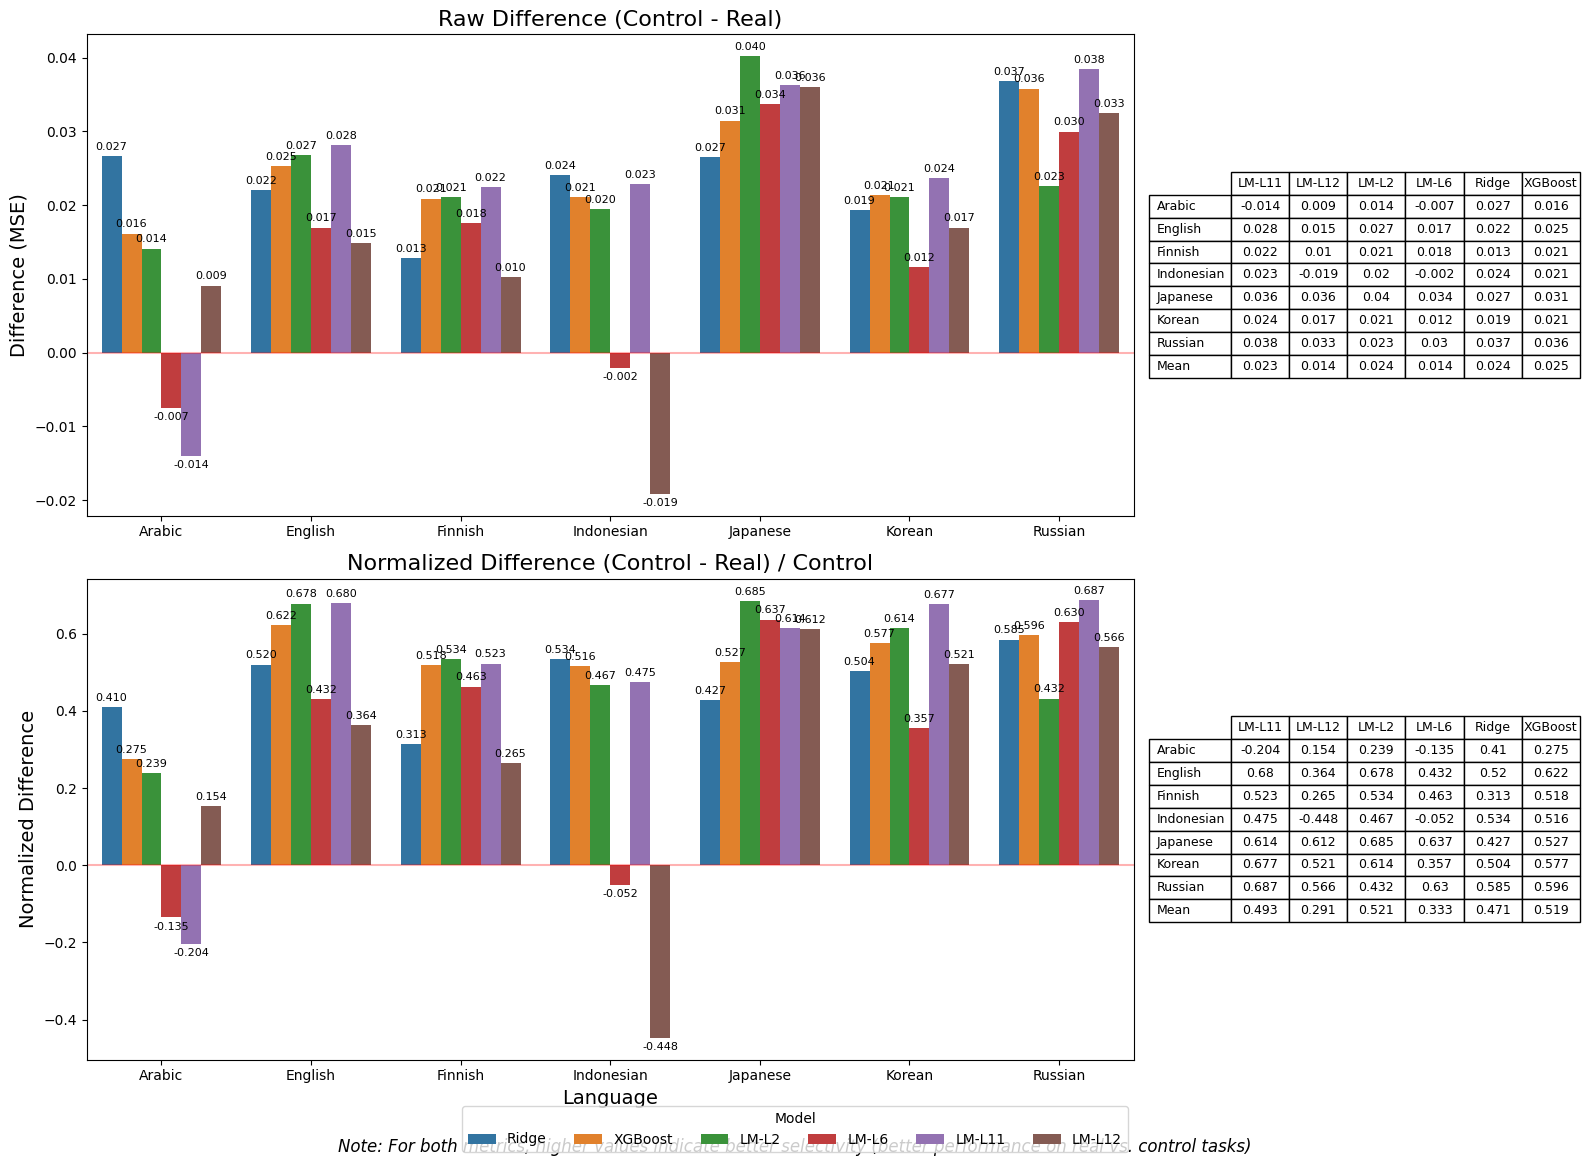

In [ ]:
def plot_selectivity_metrics_comparison():
 
    models = [
        ('Ridge', '/home/robin/Research/qtype-eval/scripts/analysis/complexity_Ridge_mse_test_table.csv'),
        ('XGBoost', '/home/robin/Research/qtype-eval/scripts/analysis/complexity_XGBRegressor_mse_test_table.csv'),
        ('LM-L2', '/home/robin/Research/qtype-eval/scripts/analysis/complexity_lm_probe_mse_test_complexity_layer2_table.csv'),
        ('LM-L6', '/home/robin/Research/qtype-eval/scripts/analysis/complexity_lm_probe_mse_test_complexity_layer6_table.csv'),
        ('LM-L11', '/home/robin/Research/qtype-eval/scripts/analysis/complexity_lm_probe_mse_test_complexity_layer11_table.csv'),
        ('LM-L12', '/home/robin/Research/qtype-eval/scripts/analysis/complexity_lm_probe_mse_test_complexity_layer12_table.csv'),
    ]
    
    # Process data for metrics
    metrics_data = []
    for model_name, file_path in models:
        df = safe_read_csv(file_path)
        if not df.empty and all(col in df.columns for col in ['language', 'real', 'control1', 'control2', 'control3']):
            df['language'] = df['language'].map(lambda x: LANGUAGE_NAMES.get(x, x))
            for _, row in df.iterrows():
                # Get values
                real = row['real']
                controls = [row['control1'], row['control2'], row['control3']]
                control_mean = np.mean(controls)
                
                # Calculate metrics - CORRECTED
                raw_diff = control_mean - real  # Simply the difference
                norm_diff = (control_mean - real) / control_mean if control_mean != 0 else np.nan  # Relative difference
                
                metrics_data.append({
                    'Language': row['language'],
                    'Model': model_name,
                    'Raw_Difference': raw_diff,
                    'Normalized_Difference': norm_diff
                })
    
    metrics_df = pd.DataFrame(metrics_data)
    
    # Create a figure with 2 subplots (one for each metric) plus tables
    fig, axes = plt.subplots(2, 2, figsize=(16, 12), 
                          gridspec_kw={'width_ratios': [3, 1], 'height_ratios': [1, 1]})
    
    # 1. Raw Difference
    metric = 'Raw_Difference'
    ax_plot = axes[0, 0]
    ax_table = axes[0, 1]
    
    sns.barplot(x='Language', y=metric, hue='Model', data=metrics_df, ax=ax_plot)
    ax_plot.set_title('Raw Difference (Control - Real)', fontsize=16)
    ax_plot.set_xlabel('')  # Hide for non-bottom plots
    ax_plot.set_ylabel('Difference (MSE)', fontsize=14)
    ax_plot.axhline(y=0, color='r', linestyle='-', alpha=0.3)
    
    # Add value labels
    for container in ax_plot.containers:
        ax_plot.bar_label(container, fmt='%.3f', padding=3, fontsize=8)
    
    # Hide legend for now, will add a common one later
    ax_plot.get_legend().remove()
    
    # Create table
    pivot = metrics_df.pivot_table(index='Language', columns='Model', values=metric)
    pivot.loc['Mean'] = pivot.mean()
    
    # Display the table
    table = ax_table.table(
        cellText=np.round(pivot.values, 3),
        rowLabels=pivot.index,
        colLabels=pivot.columns,
        cellLoc='center',
        loc='center'
    )
    
    table.auto_set_font_size(False)
    table.set_fontsize(9)
    table.scale(1, 1.2)
    ax_table.axis('off')
    
    # 2. Normalized Difference
    metric = 'Normalized_Difference'
    ax_plot = axes[1, 0]
    ax_table = axes[1, 1]
    
    sns.barplot(x='Language', y=metric, hue='Model', data=metrics_df, ax=ax_plot)
    ax_plot.set_title('Normalized Difference (Control - Real) / Control', fontsize=16)
    ax_plot.set_xlabel('Language', fontsize=14)  # Include label for bottom plot
    ax_plot.set_ylabel('Normalized Difference', fontsize=14)
    ax_plot.axhline(y=0, color='r', linestyle='-', alpha=0.3)
    
    # Add value labels
    for container in ax_plot.containers:
        ax_plot.bar_label(container, fmt='%.3f', padding=3, fontsize=8)
    
    # Create a common legend
    handles, labels = ax_plot.get_legend_handles_labels()
    ax_plot.get_legend().remove()
    
    # Create table
    pivot = metrics_df.pivot_table(index='Language', columns='Model', values=metric)
    pivot.loc['Mean'] = pivot.mean()
    
    # Display the table
    table = ax_table.table(
        cellText=np.round(pivot.values, 3),
        rowLabels=pivot.index,
        colLabels=pivot.columns,
        cellLoc='center',
        loc='center'
    )
    
    table.auto_set_font_size(False)
    table.set_fontsize(9)
    table.scale(1, 1.2)
    ax_table.axis('off')
    
    # Add a common legend
    fig.legend(handles, labels, title='Model', loc='lower center', 
               bbox_to_anchor=(0.5, 0), ncol=len(models))
    
    # Add note about interpretation
    fig.text(0.5, 0.01, 
             'Note: For both metrics, higher values indicate better selectivity (better performance on real vs. control tasks)', 
             ha='center', va='center', fontsize=12, style='italic')
    
    plt.tight_layout(rect=[0, 0.03, 1, 0.97])
    
    try:
        plt.savefig('selectivity_metrics_comparison.png', dpi=200, bbox_inches='tight')
        print("Selectivity metrics comparison saved as 'selectivity_metrics_comparison.png'")
    except Exception as e:
        print(f"Error saving plot: {e}")
        
    # Save metrics data for reference
    try:
        metrics_df.to_csv('selectivity_metrics_data.csv', index=False)
        print("Metrics data saved as 'selectivity_metrics_data.csv'")
    except Exception as e:
        print(f"Error saving CSV: {e}")
    
    return fig, metrics_df


plot_selectivity_metrics_comparison()

In [17]:
def create_submetrics_heatmap(model_to_use='lm_probe_layer12'):
    """Create a heatmap showing selectivity across languages and submetrics for a specific model."""
    submetrics = list(SUBMETRIC_NAMES.keys())
    model_lookup = {
        'lm_probe_layer2': 'single_submetric_lm_probe_mse_test_{}_layer2_table.csv',
        'lm_probe_layer6': 'single_submetric_lm_probe_mse_test_{}_layer6_table.csv',
        'lm_probe_layer11': 'single_submetric_lm_probe_mse_test_{}_layer11_table.csv',
        'lm_probe_layer12': 'single_submetric_lm_probe_mse_test_{}_layer12_table.csv',
    }
    
    if model_to_use not in model_lookup:
        print(f"Error: Model {model_to_use} not recognized. Using lm_probe_layer12 instead.")
        model_to_use = 'lm_probe_layer12'
    
    # Collect data for all submetrics
    heatmap_data = {}
    
    for submetric in submetrics:
        path_template = model_lookup[model_to_use]
        path = f"/home/robin/Research/qtype-eval/scripts/analysis/{path_template.format(submetric)}"
        df = safe_read_csv(path)
        
        if not df.empty and all(col in df.columns for col in ['language', 'real', 'control1', 'control2', 'control3']):
            df['selectivity'] = df.apply(safe_selectivity_mse, axis=1)
            
            for _, row in df.iterrows():
                lang = row['language']
                if lang not in heatmap_data:
                    heatmap_data[lang] = {}
                
                heatmap_data[lang][submetric] = row['selectivity']
    
    # Convert to dataframe
    if not heatmap_data:
        print("No data available for heatmap.")
        return None
        
    heatmap_df = pd.DataFrame(heatmap_data).T
    
    # Rename index and columns for readability
    heatmap_df.index = [LANGUAGE_NAMES.get(lang, lang) for lang in heatmap_df.index]
    heatmap_df.columns = [SUBMETRIC_NAMES.get(subm, subm) for subm in heatmap_df.columns]
    
    # Create the heatmap
    plt.figure(figsize=(12, 8))
    ax = sns.heatmap(heatmap_df, annot=True, cmap='RdBu_r', center=0, fmt='.2f')
    
    # Set title and labels
    plt.title(f'Selectivity Heatmap for {model_to_use}', fontsize=16)
    plt.ylabel('Language', fontsize=14)
    plt.xlabel('Submetric', fontsize=14)
    
    # Adjust layout
    plt.tight_layout()
    
    # Save the figure
    plt.savefig(f'selectivity_heatmap_{model_to_use}.png', dpi=300, bbox_inches='tight')
    print(f"Heatmap saved as 'selectivity_heatmap_{model_to_use}.png'")
    
    return ax

create_submetrics_heatmap()

NameError: name 'safe_selectivity_mse' is not defined

In [33]:

# Table 4: Best Layer for Classification by Language
def table_best_layer_classification():
    """Create a table showing the best performing LM probe layer for classification by language."""
    layers = ['2', '6', '11', '12']
    layer_files = [
        f'/home/robin/Research/qtype-eval/scripts/analysis/question_type_lm_probe_accuracy_test_overall_layer{layer}_table.csv'
        for layer in layers
    ]
    
    # Collect data
    languages = []
    layer_data = {f'Layer {layer}': {} for layer in layers}
    
    for i, file_path in enumerate(layer_files):
        layer = layers[i]
        df = safe_read_csv(file_path)
        
        if not df.empty and 'language' in df.columns and 'real' in df.columns:
            for _, row in df.iterrows():
                lang = LANGUAGE_NAMES.get(row['language'], row['language'])
                if lang not in languages:
                    languages.append(lang)
                layer_data[f'Layer {layer}'][lang] = row['real']
    
    # Create the dataframe
    if not languages:
        print("No data available for best layer classification table.")
        return None
        
    best_layer_data = {'Language': languages}
    
    # For each language, find the layer with the best performance
    for lang in languages:
        layer_accuracies = {}
        for layer_key, lang_dict in layer_data.items():
            if lang in lang_dict:
                layer_accuracies[layer_key] = lang_dict[lang]
        
        if layer_accuracies:
            best_layer = max(layer_accuracies, key=layer_accuracies.get)
            best_accuracy = layer_accuracies[best_layer]
            best_layer_data[lang] = {'BestLayer': best_layer, 'Accuracy': best_accuracy}
    
    # Format the table
    best_layer_table = pd.DataFrame({
        'Language': languages,
        'BestLayer': [best_layer_data[lang]['BestLayer'] if lang in best_layer_data else 'N/A' for lang in languages],
        'Accuracy': [best_layer_data[lang]['Accuracy'] if lang in best_layer_data else np.nan for lang in languages]
    })
    
    print("\nTable 4: Best Layer for Classification by Language")
    print(best_layer_table)
    best_layer_table.to_csv('table_best_layer_classification.csv', index=False)
    print("Saved as table_best_layer_classification.csv")
    
    return best_layer_table

# Table 5: Best Layer for Complexity by Submetric
def table_best_layer_complexity():
    """Create a table showing the best performing layer for each complexity submetric."""
    submetrics = list(SUBMETRIC_NAMES.keys())
    layers = ['2', '6', '11', '12']
    
    # Collect data
    submetric_data = {}
    
    for submetric in submetrics:
        submetric_name = SUBMETRIC_NAMES.get(submetric, submetric)
        submetric_data[submetric_name] = {}
        
        for layer in layers:
            file_path = f'/home/robin/Research/qtype-eval/scripts/analysis/single_submetric_lm_probe_rmse_test_{submetric}_layer{layer}_table.csv'
            df = safe_read_csv(file_path)
            
            if not df.empty and 'real' in df.columns:
                # Calculate average RMSE across languages
                avg_rmse = df['real'].mean()
                submetric_data[submetric_name][f'Layer {layer}'] = avg_rmse
    
    # Create the dataframe
    if not submetric_data:
        print("No data available for best layer complexity table.")
        return None
        
    best_layer_rows = []
    
    for submetric_name, layer_scores in submetric_data.items():
        if layer_scores:
            # For RMSE, the lower the better
            best_layer = min(layer_scores, key=layer_scores.get)
            best_rmse = layer_scores[best_layer]
            
            row = {
                'Submetric': submetric_name, 
                'BestLayer': best_layer, 
                'RMSE': best_rmse
            }
            
            # Add all layer scores for reference
            for layer in [f'Layer {l}' for l in layers]:
                if layer in layer_scores:
                    row[layer] = layer_scores[layer]
            
            best_layer_rows.append(row)
    
    # Format the table
    best_layer_table = pd.DataFrame(best_layer_rows)
    
    print("\nTable 5: Best Layer for Complexity by Submetric")
    print(best_layer_table.round(3))
    best_layer_table.to_csv('table_best_layer_complexity.csv', index=False)
    print("Saved as table_best_layer_complexity.csv")
    
    return best_layer_table

table_best_layer_classification()
table_best_layer_complexity()



Table 4: Best Layer for Classification by Language
     Language BestLayer  Accuracy
0      Arabic   Layer 2  0.974026
1     English  Layer 12  0.945455
2     Finnish   Layer 6  0.918182
3  Indonesian  Layer 12  0.745455
4    Japanese  Layer 11  0.858696
5      Korean  Layer 11  0.872727
6     Russian   Layer 2  0.990909
Saved as table_best_layer_classification.csv

Table 5: Best Layer for Complexity by Submetric
                  Submetric BestLayer   RMSE  Layer 2  Layer 6  Layer 11  \
0    Avg. Dependency Length  Layer 11  0.163    0.176    0.163     0.163   
1            Max Tree Depth  Layer 11  0.136    0.144    0.151     0.136   
2  Subordinate Chain Length  Layer 11  0.190    0.204    0.200     0.190   
3                Verb Edges  Layer 11  0.208    0.244    0.221     0.208   
4           Lexical Density   Layer 6  0.210    0.229    0.210     0.214   
5               Token Count   Layer 2  0.155    0.155    0.171     0.167   

   Layer 12  
0     0.173  
1     0.168  
2     0

,Submetric,BestLayer,RMSE,Layer 2,Layer 6,Layer 11,Layer 12
0,Avg. Dependency Length,Layer 11,0.162869,0.175680,0.163249,0.162869,0.172832
1,Max Tree Depth,Layer 11,0.136349,0.144030,0.150878,0.136349,0.167631
2,Subordinate Chain Length,Layer 11,0.189735,0.204169,0.200066,0.189735,0.206162
3,Verb Edges,Layer 11,0.207978,0.244125,0.221072,0.207978,0.217620
4,Lexical Density,Layer 6,0.209709,0.229293,0.209709,0.213844,0.226099
5,Token Count,Layer 2,0.154664,0.154664,0.170762,0.167100,0.166594


In [ ]:
# Table: Best Model for Classification by Language
def table_best_model_classification():
    """Create a table showing the best performing model for classification by language."""
    models = [
        ('Dummy', '/home/robin/Research/qtype-eval/scripts/analysis/question_type_DummyClassifier_accuracy_test_table.csv'),
        ('LogReg', '/home/robin/Research/qtype-eval/scripts/analysis/question_type_LogisticRegression_accuracy_test_table.csv'),
        ('XGBoost', '/home/robin/Research/qtype-eval/scripts/analysis/question_type_XGBClassifier_accuracy_test_table.csv'),
        ('LM-L2', '/home/robin/Research/qtype-eval/scripts/analysis/question_type_lm_probe_accuracy_test_overall_layer2_table.csv'),
        ('LM-L6', '/home/robin/Research/qtype-eval/scripts/analysis/question_type_lm_probe_accuracy_test_overall_layer6_table.csv'),
        ('LM-L11', '/home/robin/Research/qtype-eval/scripts/analysis/question_type_lm_probe_accuracy_test_overall_layer11_table.csv'),
        ('LM-L12', '/home/robin/Research/qtype-eval/scripts/analysis/question_type_lm_probe_accuracy_test_overall_layer12_table.csv'),
    ]
    
    # Collect data
    languages = []
    model_data = {model_name: {} for model_name, _ in models}
    
    for model_name, file_path in models:
        df = safe_read_csv(file_path)
        
        if not df.empty and 'language' in df.columns and 'real' in df.columns:
            for _, row in df.iterrows():
                lang = LANGUAGE_NAMES.get(row['language'], row['language'])
                if lang not in languages:
                    languages.append(lang)
                model_data[model_name][lang] = row['real']
    
    # Create the dataframe
    if not languages:
        print("No data available for best model classification table.")
        return None
        
    best_model_data = {'Language': languages}
    
    # For each language, find the model with the best performance
    for lang in languages:
        model_accuracies = {}
        for model_name, lang_dict in model_data.items():
            if lang in lang_dict:
                model_accuracies[model_name] = lang_dict[lang]
        
        if model_accuracies:
            best_model = max(model_accuracies, key=model_accuracies.get)
            best_accuracy = model_accuracies[best_model]
            best_model_data[lang] = {'BestModel': best_model, 'Accuracy': best_accuracy}
    
    # Format the table
    best_model_table = pd.DataFrame({
        'Language': languages,
        'BestModel': [best_model_data[lang]['BestModel'] if lang in best_model_data else 'N/A' for lang in languages],
        'Accuracy': [best_model_data[lang]['Accuracy'] if lang in best_model_data else np.nan for lang in languages]
    })
    
    # Add all model scores for reference
    for model_name, _ in models:
        best_model_table[model_name] = best_model_table['Language'].apply(
            lambda lang: model_data[model_name].get(lang, np.nan)
        )
    
    print("\nTable: Best Model for Classification by Language")
    print(best_model_table[['Language', 'BestModel', 'Accuracy']].round(3))
    best_model_table.to_csv('table_best_model_classification.csv', index=False)
    print("Saved as table_best_model_classification.csv")
    
    return best_model_table

# Table: Best Model for Complexity by Submetric
def table_best_model_complexity():
    """Create a table showing the best performing model for each complexity submetric."""
    submetrics = list(SUBMETRIC_NAMES.keys())
    models = [
        ('Ridge', 'complexity_Ridge_rmse_test_{}_table.csv'),
        ('XGBoost', 'complexity_XGBRegressor_rmse_test_{}_table.csv'),
        ('LM-L2', 'single_submetric_lm_probe_rmse_test_{}_layer2_table.csv'),
        ('LM-L6', 'single_submetric_lm_probe_rmse_test_{}_layer6_table.csv'),
        ('LM-L11', 'single_submetric_lm_probe_rmse_test_{}_layer11_table.csv'),
        ('LM-L12', 'single_submetric_lm_probe_rmse_test_{}_layer12_table.csv'),
    ]
    
    # Collect data
    submetric_data = {}
    
    for submetric in submetrics:
        submetric_name = SUBMETRIC_NAMES.get(submetric, submetric)
        submetric_data[submetric_name] = {}
        
        for model_name, file_template in models:
            file_path = f'/home/robin/Research/qtype-eval/scripts/analysis/{file_template.format(submetric)}'
            df = safe_read_csv(file_path)
            
            if not df.empty and 'real' in df.columns:
                # Calculate average RMSE across languages
                avg_rmse = df['real'].mean()
                submetric_data[submetric_name][model_name] = avg_rmse
    
    # Create the dataframe
    if not submetric_data:
        print("No data available for best model complexity table.")
        return None
        
    best_model_rows = []
    
    for submetric_name, model_scores in submetric_data.items():
        if model_scores:
            # For RMSE, the lower the better
            best_model = min(model_scores, key=model_scores.get)
            best_rmse = model_scores[best_model]
            
            row = {
                'Submetric': submetric_name, 
                'BestModel': best_model, 
                'RMSE': best_rmse
            }
            
            # Add all model scores for reference
            for model_name, _ in models:
                if model_name in model_scores:
                    row[model_name] = model_scores[model_name]
            
            best_model_rows.append(row)
    
    # Format the table
    best_model_table = pd.DataFrame(best_model_rows)
    
    # Reorder columns to put BestModel and RMSE at the beginning
    cols = ['Submetric', 'BestModel', 'RMSE'] + [m for m, _ in models if m in best_model_table.columns]
    best_model_table = best_model_table[cols]
    
    print("\nTable: Best Model for Complexity by Submetric")
    print(best_model_table[['Submetric', 'BestModel', 'RMSE']].round(3))
    best_model_table.to_csv('table_best_model_complexity.csv', index=False)
    print("Saved as table_best_model_complexity.csv")
    
    return best_model_table

# Table: Best Model for Each Submetric and Language
def table_best_model_per_language_submetric():
    """Create a detailed table showing the best performing model for each submetric and language combination."""
    submetrics = list(SUBMETRIC_NAMES.keys())
    models = [
        ('Ridge', 'complexity_Ridge_rmse_test_{}_table.csv'),
        ('XGBoost', 'complexity_XGBRegressor_rmse_test_{}_table.csv'),
        ('LM-L2', 'single_submetric_lm_probe_rmse_test_{}_layer2_table.csv'),
        ('LM-L6', 'single_submetric_lm_probe_rmse_test_{}_layer6_table.csv'),
        ('LM-L11', 'single_submetric_lm_probe_rmse_test_{}_layer11_table.csv'),
        ('LM-L12', 'single_submetric_lm_probe_rmse_test_{}_layer12_table.csv'),
    ]
    
    # Collect data - structure: {submetric -> {language -> {model -> score}}}
    data = {}
    
    for submetric in submetrics:
        data[submetric] = {}
        
        for model_name, file_template in models:
            file_path = f'/home/robin/Research/qtype-eval/scripts/analysis/{file_template.format(submetric)}'
            df = safe_read_csv(file_path)
            
            if not df.empty and all(col in df.columns for col in ['language', 'real']):
                for _, row in df.iterrows():
                    lang_code = row['language']
                    lang_name = LANGUAGE_NAMES.get(lang_code, lang_code)
                    
                    if lang_name not in data[submetric]:
                        data[submetric][lang_name] = {}
                    
                    data[submetric][lang_name][model_name] = row['real']
    
    # Create rows for the detailed table
    detailed_rows = []
    
    for submetric, lang_data in data.items():
        submetric_name = SUBMETRIC_NAMES.get(submetric, submetric)
        
        for lang_name, model_scores in lang_data.items():
            if model_scores:
                # For RMSE, the lower the better
                best_model = min(model_scores, key=model_scores.get)
                best_rmse = model_scores[best_model]
                
                row = {
                    'Submetric': submetric_name,
                    'Language': lang_name,
                    'BestModel': best_model,
                    'RMSE': best_rmse
                }
                
                detailed_rows.append(row)
    
    # Create the table
    if not detailed_rows:
        print("No data available for detailed best model table.")
        return None
    
    detailed_table = pd.DataFrame(detailed_rows)
    
    
    pivot_table = detailed_table.pivot(index='Language', columns='Submetric', values='BestModel')
    
    print("\nTable: Best Model for Each Submetric and Language")
    print(detailed_table.round(3))
    detailed_table.to_csv('table_best_model_detailed.csv', index=False)
    print("Saved as table_best_model_detailed.csv")
    
    print("\nPivot Table: Best Model for Each Language and Submetric")
    print(pivot_table)
    pivot_table.to_csv('table_best_model_pivot.csv')
    print("Saved as table_best_model_pivot.csv")
    
    return detailed_table, pivot_table


table_best_model_classification()
table_best_model_complexity()
table_best_model_per_language_submetric()


Table: Best Model for Classification by Language
     Language BestModel  Accuracy
0      Arabic    LogReg     0.987
1     English    LM-L12     0.945
2     Finnish     LM-L6     0.918
3  Indonesian    LM-L12     0.745
4    Japanese    LM-L11     0.859
5      Korean    LM-L11     0.873
6     Russian     LM-L2     0.991
Saved as table_best_model_classification.csv

Table: Best Model for Complexity by Submetric
                  Submetric BestModel   RMSE
0    Avg. Dependency Length     Ridge  0.161
1            Max Tree Depth    LM-L11  0.136
2  Subordinate Chain Length    LM-L11  0.190
3                Verb Edges    LM-L11  0.208
4           Lexical Density     LM-L6  0.210
5               Token Count   XGBoost  0.153
Saved as table_best_model_complexity.csv

Table: Best Model for Each Submetric and Language
                   Submetric    Language BestModel   RMSE
0     Avg. Dependency Length      Arabic     LM-L6  0.193
1     Avg. Dependency Length     English     Ridge  0.080
2    

(                   Submetric    Language BestModel      RMSE
 0     Avg. Dependency Length      Arabic     LM-L6  0.192556
 1     Avg. Dependency Length     English     Ridge  0.079556
 2     Avg. Dependency Length     Finnish     Ridge  0.133484
 3     Avg. Dependency Length  Indonesian     LM-L6  0.139297
 4     Avg. Dependency Length    Japanese    LM-L12  0.273108
 5     Avg. Dependency Length      Korean    LM-L11  0.118942
 6     Avg. Dependency Length     Russian    LM-L11  0.122305
 7             Max Tree Depth      Arabic     LM-L2  0.165800
 8             Max Tree Depth     English    LM-L11  0.101045
 9             Max Tree Depth     Finnish    LM-L11  0.119889
 10            Max Tree Depth  Indonesian     Ridge  0.135146
 11            Max Tree Depth    Japanese    LM-L11  0.167380
 12            Max Tree Depth      Korean    LM-L12  0.114438
 13            Max Tree Depth     Russian     LM-L2  0.099409
 14  Subordinate Chain Length      Arabic    LM-L11  0.206627
 15  Sub

In [ ]:
def table_best_model_complexity():      # Table: Best Model for Complexity by Submetric BY MSE
    submetrics = list(SUBMETRIC_NAMES.keys())
    models = [
        ('Ridge', 'complexity_Ridge_mse_test_{}_table.csv'),
        ('XGBoost', 'complexity_XGBRegressor_mse_test_{}_table.csv'),
        ('LM-L2', 'single_submetric_lm_probe_mse_test_{}_layer2_table.csv'),
        ('LM-L6', 'single_submetric_lm_probe_mse_test_{}_layer6_table.csv'),
        ('LM-L11', 'single_submetric_lm_probe_mse_test_{}_layer11_table.csv'),
        ('LM-L12', 'single_submetric_lm_probe_mse_test_{}_layer12_table.csv'),
    ]
    
    # Collect data
    submetric_data = {}
    
    for submetric in submetrics:
        submetric_name = SUBMETRIC_NAMES.get(submetric, submetric)
        submetric_data[submetric_name] = {}
        
        for model_name, file_template in models:
            file_path = f'/home/robin/Research/qtype-eval/scripts/analysis/{file_template.format(submetric)}'
            df = safe_read_csv(file_path)
            
            if not df.empty and 'real' in df.columns:
                # Calculate average RMSE across languages
                avg_mse = df['real'].mean()
                submetric_data[submetric_name][model_name] = avg_mse
    
    # Create the dataframe
    if not submetric_data:
        print("No data available for best model complexity table.")
        return None
        
    best_model_rows = []
    
    for submetric_name, model_scores in submetric_data.items():
        if model_scores:
            # For RMSE, the lower the better
            best_model = min(model_scores, key=model_scores.get)
            best_mse = model_scores[best_model]
            
            row = {
                'Submetric': submetric_name, 
                'BestModel': best_model, 
                'MSE': best_mse
            }
            
            # Add all model scores for reference
            for model_name, _ in models:
                if model_name in model_scores:
                    row[model_name] = model_scores[model_name]
            
            best_model_rows.append(row)
    
    # Format the table
    best_model_table = pd.DataFrame(best_model_rows)
    
    # Reorder columns to put BestModel and RMSE at the beginning
    cols = ['Submetric', 'BestModel', 'MSE'] + [m for m, _ in models if m in best_model_table.columns]
    best_model_table = best_model_table[cols]
    
    print("\nTable: Best Model for Complexity by Submetric")
    print(best_model_table[['Submetric', 'BestModel', 'MSE']].round(3))
    best_model_table.to_csv('table_best_model_complexity.csv', index=False)
    print("Saved as table_best_model_complexity.csv")
    
    return best_model_table

# Table: Best Model for Each Submetric and Language
def table_best_model_per_language_submetric():
    """Create a detailed table showing the best performing model for each submetric and language combination."""
    submetrics = list(SUBMETRIC_NAMES.keys())
    models = [
        ('Ridge', 'complexity_Ridge_mse_test_{}_table.csv'),
        ('XGBoost', 'complexity_XGBRegressor_mse_test_{}_table.csv'),
        ('LM-L2', 'single_submetric_lm_probe_mse_test_{}_layer2_table.csv'),
        ('LM-L6', 'single_submetric_lm_probe_mse_test_{}_layer6_table.csv'),
        ('LM-L11', 'single_submetric_lm_probe_mse_test_{}_layer11_table.csv'),
        ('LM-L12', 'single_submetric_lm_probe_mse_test_{}_layer12_table.csv'),
    ]
    
    # Collect data - structure: {submetric -> {language -> {model -> score}}}
    data = {}
    
    for submetric in submetrics:
        data[submetric] = {}
        
        for model_name, file_template in models:
            file_path = f'/home/robin/Research/qtype-eval/scripts/analysis/{file_template.format(submetric)}'
            df = safe_read_csv(file_path)
            
            if not df.empty and all(col in df.columns for col in ['language', 'real']):
                for _, row in df.iterrows():
                    lang_code = row['language']
                    lang_name = LANGUAGE_NAMES.get(lang_code, lang_code)
                    
                    if lang_name not in data[submetric]:
                        data[submetric][lang_name] = {}
                    
                    data[submetric][lang_name][model_name] = row['real']
    
    # Create rows for the detailed table
    detailed_rows = []
    
    for submetric, lang_data in data.items():
        submetric_name = SUBMETRIC_NAMES.get(submetric, submetric)
        
        for lang_name, model_scores in lang_data.items():
            if model_scores:
                # For RMSE, the lower the better
                best_model = min(model_scores, key=model_scores.get)
                best_rmse = model_scores[best_model]
                
                row = {
                    'Submetric': submetric_name,
                    'Language': lang_name,
                    'BestModel': best_model,
                    'MSE': best_rmse
                }
                
                detailed_rows.append(row)
    
    # Create the table
    if not detailed_rows:
        print("No data available for detailed best model table.")
        return None
    
    detailed_table = pd.DataFrame(detailed_rows)
    
    # Create a more readable view with languages as rows and submetrics as columns
    # This creates a table showing the best model for each language-submetric combination
    pivot_table = detailed_table.pivot(index='Language', columns='Submetric', values='BestModel')
    
    print("\nTable: Best Model for Each Submetric and Language")
    print(detailed_table.round(3))
    detailed_table.to_csv('table_best_model_detailed.csv', index=False)
    print("Saved as table_best_model_detailed.csv")
    
    print("\nPivot Table: Best Model for Each Language and Submetric")
    print(pivot_table)
    pivot_table.to_csv('table_best_model_pivot.csv')
    print("Saved as table_best_model_pivot.csv")
    
    return detailed_table, pivot_table


table_best_model_complexity()
table_best_model_per_language_submetric()


Table: Best Model for Complexity by Submetric
                  Submetric BestModel    MSE
0    Avg. Dependency Length     Ridge  0.029
1            Max Tree Depth    LM-L11  0.019
2  Subordinate Chain Length    LM-L11  0.037
3                Verb Edges    LM-L11  0.044
4           Lexical Density     LM-L6  0.047
5               Token Count   XGBoost  0.025
Saved as table_best_model_complexity.csv

Table: Best Model for Each Submetric and Language
                   Submetric    Language BestModel    MSE
0     Avg. Dependency Length      Arabic     LM-L6  0.037
1     Avg. Dependency Length     English     Ridge  0.006
2     Avg. Dependency Length     Finnish     Ridge  0.018
3     Avg. Dependency Length  Indonesian     LM-L6  0.019
4     Avg. Dependency Length    Japanese    LM-L12  0.075
5     Avg. Dependency Length      Korean    LM-L11  0.014
6     Avg. Dependency Length     Russian    LM-L11  0.015
7             Max Tree Depth      Arabic     LM-L2  0.027
8             Max Tree D

(                   Submetric    Language BestModel       MSE
 0     Avg. Dependency Length      Arabic     LM-L6  0.037078
 1     Avg. Dependency Length     English     Ridge  0.006329
 2     Avg. Dependency Length     Finnish     Ridge  0.017818
 3     Avg. Dependency Length  Indonesian     LM-L6  0.019404
 4     Avg. Dependency Length    Japanese    LM-L12  0.074588
 5     Avg. Dependency Length      Korean    LM-L11  0.014147
 6     Avg. Dependency Length     Russian    LM-L11  0.014958
 7             Max Tree Depth      Arabic     LM-L2  0.027490
 8             Max Tree Depth     English    LM-L11  0.010210
 9             Max Tree Depth     Finnish    LM-L11  0.014373
 10            Max Tree Depth  Indonesian     Ridge  0.018265
 11            Max Tree Depth    Japanese    LM-L11  0.028016
 12            Max Tree Depth      Korean    LM-L12  0.013096
 13            Max Tree Depth     Russian     LM-L2  0.009882
 14  Subordinate Chain Length      Arabic    LM-L11  0.042695
 15  Sub

Selectivity metrics comparison saved as 'selectivity_metrics_comparison.png'
Metrics data saved as 'selectivity_metrics_data.csv'


(<Figure size 1600x1200 with 4 Axes>,
       Language    Model  Raw_Difference  Normalized_Difference
 0       Arabic    Ridge        0.458630               1.353347
 1      English    Ridge        0.570765               1.205502
 2      Finnish    Ridge        0.325260               1.130654
 3   Indonesian    Ridge        0.591675               1.221182
 4     Japanese    Ridge        0.509262               1.602183
 5       Korean    Ridge        0.600390               1.470768
 6      Russian    Ridge        0.930901               2.733467
 7       Arabic  XGBoost        0.278074               1.035087
 8      English  XGBoost        0.655951               1.089247
 9      Finnish  XGBoost        0.529010               1.041395
 10  Indonesian  XGBoost        0.516387               1.001495
 11    Japanese  XGBoost        0.604228               1.321774
 12      Korean  XGBoost        0.661708               1.287170
 13     Russian  XGBoost        0.905801               2.344389
 1

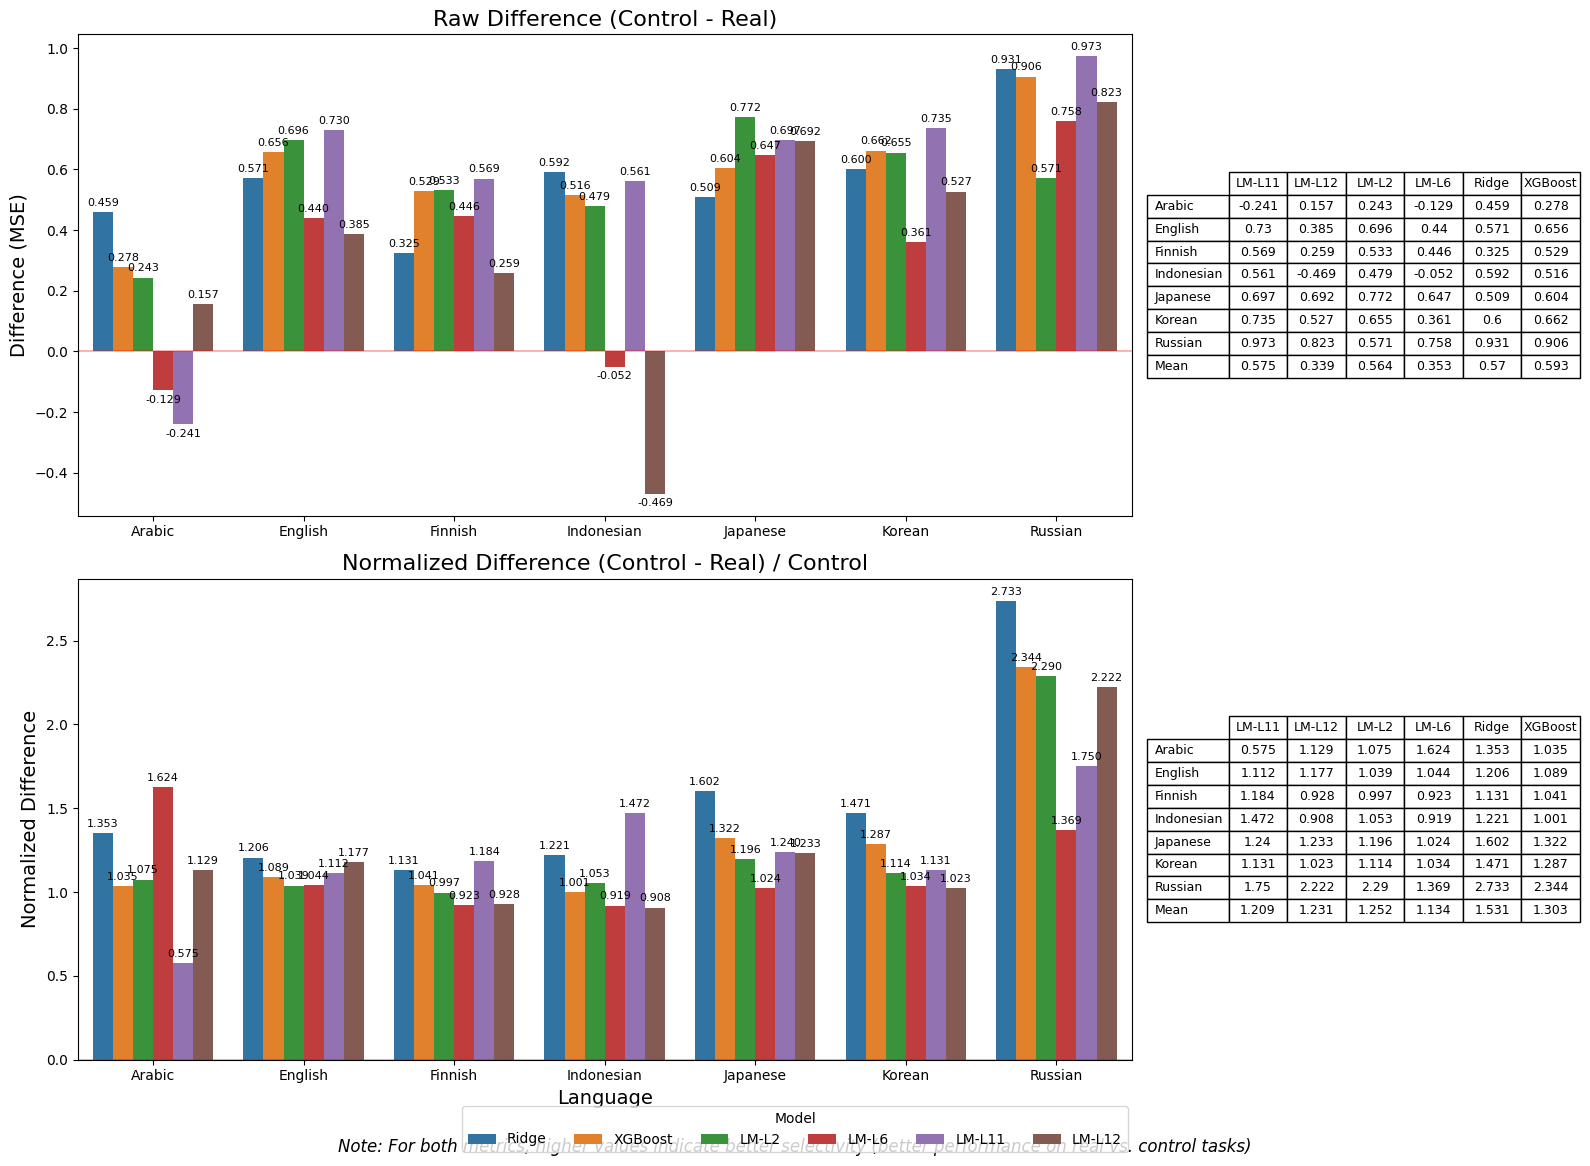

In [ ]:
def plot_selectivity_metrics_comparison():          # Selectivity comparison with R2
 
    models = [
        ('Ridge', '/home/robin/Research/qtype-eval/scripts/analysis/complexity_Ridge_r2_test_table.csv'),
        ('XGBoost', '/home/robin/Research/qtype-eval/scripts/analysis/complexity_XGBRegressor_r2_test_table.csv'),
        ('LM-L2', '/home/robin/Research/qtype-eval/scripts/analysis/complexity_lm_probe_r2_test_complexity_layer2_table.csv'),
        ('LM-L6', '/home/robin/Research/qtype-eval/scripts/analysis/complexity_lm_probe_r2_test_complexity_layer6_table.csv'),
        ('LM-L11', '/home/robin/Research/qtype-eval/scripts/analysis/complexity_lm_probe_r2_test_complexity_layer11_table.csv'),
        ('LM-L12', '/home/robin/Research/qtype-eval/scripts/analysis/complexity_lm_probe_r2_test_complexity_layer12_table.csv'),
    ]
    
    # Process data for metrics
    metrics_data = []
    for model_name, file_path in models:
        df = safe_read_csv(file_path)
        if not df.empty and all(col in df.columns for col in ['language', 'real', 'control1', 'control2', 'control3']):
            df['language'] = df['language'].map(lambda x: LANGUAGE_NAMES.get(x, x))
            for _, row in df.iterrows():
                # Get values
                real = row['real']
                controls = [row['control1'], row['control2'], row['control3']]
                control_mean = np.mean(controls)
                
                # Calculate metrics - CORRECTED
                raw_diff = real - control_mean  # Simply the difference
                norm_diff = (real - control_mean) / real if real != 0 else np.nan  # Relative difference
                
                metrics_data.append({
                    'Language': row['language'],
                    'Model': model_name,
                    'Raw_Difference': raw_diff,
                    'Normalized_Difference': norm_diff
                })
    
    metrics_df = pd.DataFrame(metrics_data)
    
    # Create a figure with 2 subplots (one for each metric) plus tables
    fig, axes = plt.subplots(2, 2, figsize=(16, 12), 
                          gridspec_kw={'width_ratios': [3, 1], 'height_ratios': [1, 1]})
    
    # 1. Raw Difference
    metric = 'Raw_Difference'
    ax_plot = axes[0, 0]
    ax_table = axes[0, 1]
    
    sns.barplot(x='Language', y=metric, hue='Model', data=metrics_df, ax=ax_plot)
    ax_plot.set_title('Raw Difference (Control - Real)', fontsize=16)
    ax_plot.set_xlabel('')  # Hide for non-bottom plots
    ax_plot.set_ylabel('Difference (MSE)', fontsize=14)
    ax_plot.axhline(y=0, color='r', linestyle='-', alpha=0.3)
    
    # Add value labels
    for container in ax_plot.containers:
        ax_plot.bar_label(container, fmt='%.3f', padding=3, fontsize=8)
    
    # Hide legend for now, will add a common one later
    ax_plot.get_legend().remove()
    
    # Create table
    pivot = metrics_df.pivot_table(index='Language', columns='Model', values=metric)
    pivot.loc['Mean'] = pivot.mean()
    
    # Display the table
    table = ax_table.table(
        cellText=np.round(pivot.values, 3),
        rowLabels=pivot.index,
        colLabels=pivot.columns,
        cellLoc='center',
        loc='center'
    )
    
    table.auto_set_font_size(False)
    table.set_fontsize(9)
    table.scale(1, 1.2)
    ax_table.axis('off')
    
    # 2. Normalized Difference
    metric = 'Normalized_Difference'
    ax_plot = axes[1, 0]
    ax_table = axes[1, 1]
    
    sns.barplot(x='Language', y=metric, hue='Model', data=metrics_df, ax=ax_plot)
    ax_plot.set_title('Normalized Difference (Control - Real) / Control', fontsize=16)
    ax_plot.set_xlabel('Language', fontsize=14)  # Include label for bottom plot
    ax_plot.set_ylabel('Normalized Difference', fontsize=14)
    ax_plot.axhline(y=0, color='r', linestyle='-', alpha=0.3)
    
    # Add value labels
    for container in ax_plot.containers:
        ax_plot.bar_label(container, fmt='%.3f', padding=3, fontsize=8)
    
    # Create a common legend
    handles, labels = ax_plot.get_legend_handles_labels()
    ax_plot.get_legend().remove()
    
    # Create table
    pivot = metrics_df.pivot_table(index='Language', columns='Model', values=metric)
    pivot.loc['Mean'] = pivot.mean()
    
    # Display the table
    table = ax_table.table(
        cellText=np.round(pivot.values, 3),
        rowLabels=pivot.index,
        colLabels=pivot.columns,
        cellLoc='center',
        loc='center'
    )
    
    table.auto_set_font_size(False)
    table.set_fontsize(9)
    table.scale(1, 1.2)
    ax_table.axis('off')
    
    # Add a common legend
    fig.legend(handles, labels, title='Model', loc='lower center', 
               bbox_to_anchor=(0.5, 0), ncol=len(models))
    
    # Add note about interpretation
    fig.text(0.5, 0.01, 
             'Note: For both metrics, higher values indicate better selectivity (better performance on real vs. control tasks)', 
             ha='center', va='center', fontsize=12, style='italic')
    
    plt.tight_layout(rect=[0, 0.03, 1, 0.97])
    
    try:
        plt.savefig('selectivity_metrics_comparison.png', dpi=200, bbox_inches='tight')
        print("Selectivity metrics comparison saved as 'selectivity_metrics_comparison.png'")
    except Exception as e:
        print(f"Error saving plot: {e}")
        
    # Save metrics data for reference
    try:
        metrics_df.to_csv('selectivity_metrics_data.csv', index=False)
        print("Metrics data saved as 'selectivity_metrics_data.csv'")
    except Exception as e:
        print(f"Error saving CSV: {e}")
    
    return fig, metrics_df

plot_selectivity_metrics_comparison()

Submetric selectivity comparison saved as 'submetric_selectivity_comparison.png'
Individual plot for Average Dependency Length saved
Individual plot for Maximum Tree Depth saved
Individual plot for Subordinate Chain Length saved
Individual plot for Lexical Density saved
Individual plot for Verbal Edges Count saved
Individual plot for Token Count saved
Submetric metrics data saved as 'submetric_selectivity_data.csv'


(<Figure size 1800x3600 with 12 Axes>,
        Language   Model      Submetric  Real_MSE  Control_MSE  Raw_Difference  \
 0        Arabic   Ridge  avg_links_len  0.039647     0.064634        0.024987   
 1       English   Ridge  avg_links_len  0.006329     0.011584        0.005254   
 2       Finnish   Ridge  avg_links_len  0.017818     0.023668        0.005850   
 3    Indonesian   Ridge  avg_links_len  0.026345     0.036264        0.009920   
 4      Japanese   Ridge  avg_links_len  0.075757     0.106843        0.031086   
 ..          ...     ...            ...       ...          ...             ...   
 247     Finnish  LM-L12       n_tokens  0.009694     0.014947        0.005253   
 248  Indonesian  LM-L12       n_tokens  0.040861     0.038064       -0.002796   
 249    Japanese  LM-L12       n_tokens  0.027588     0.061441        0.033853   
 250      Korean  LM-L12       n_tokens  0.043151     0.070862        0.027711   
 251     Russian  LM-L12       n_tokens  0.012308     0.012

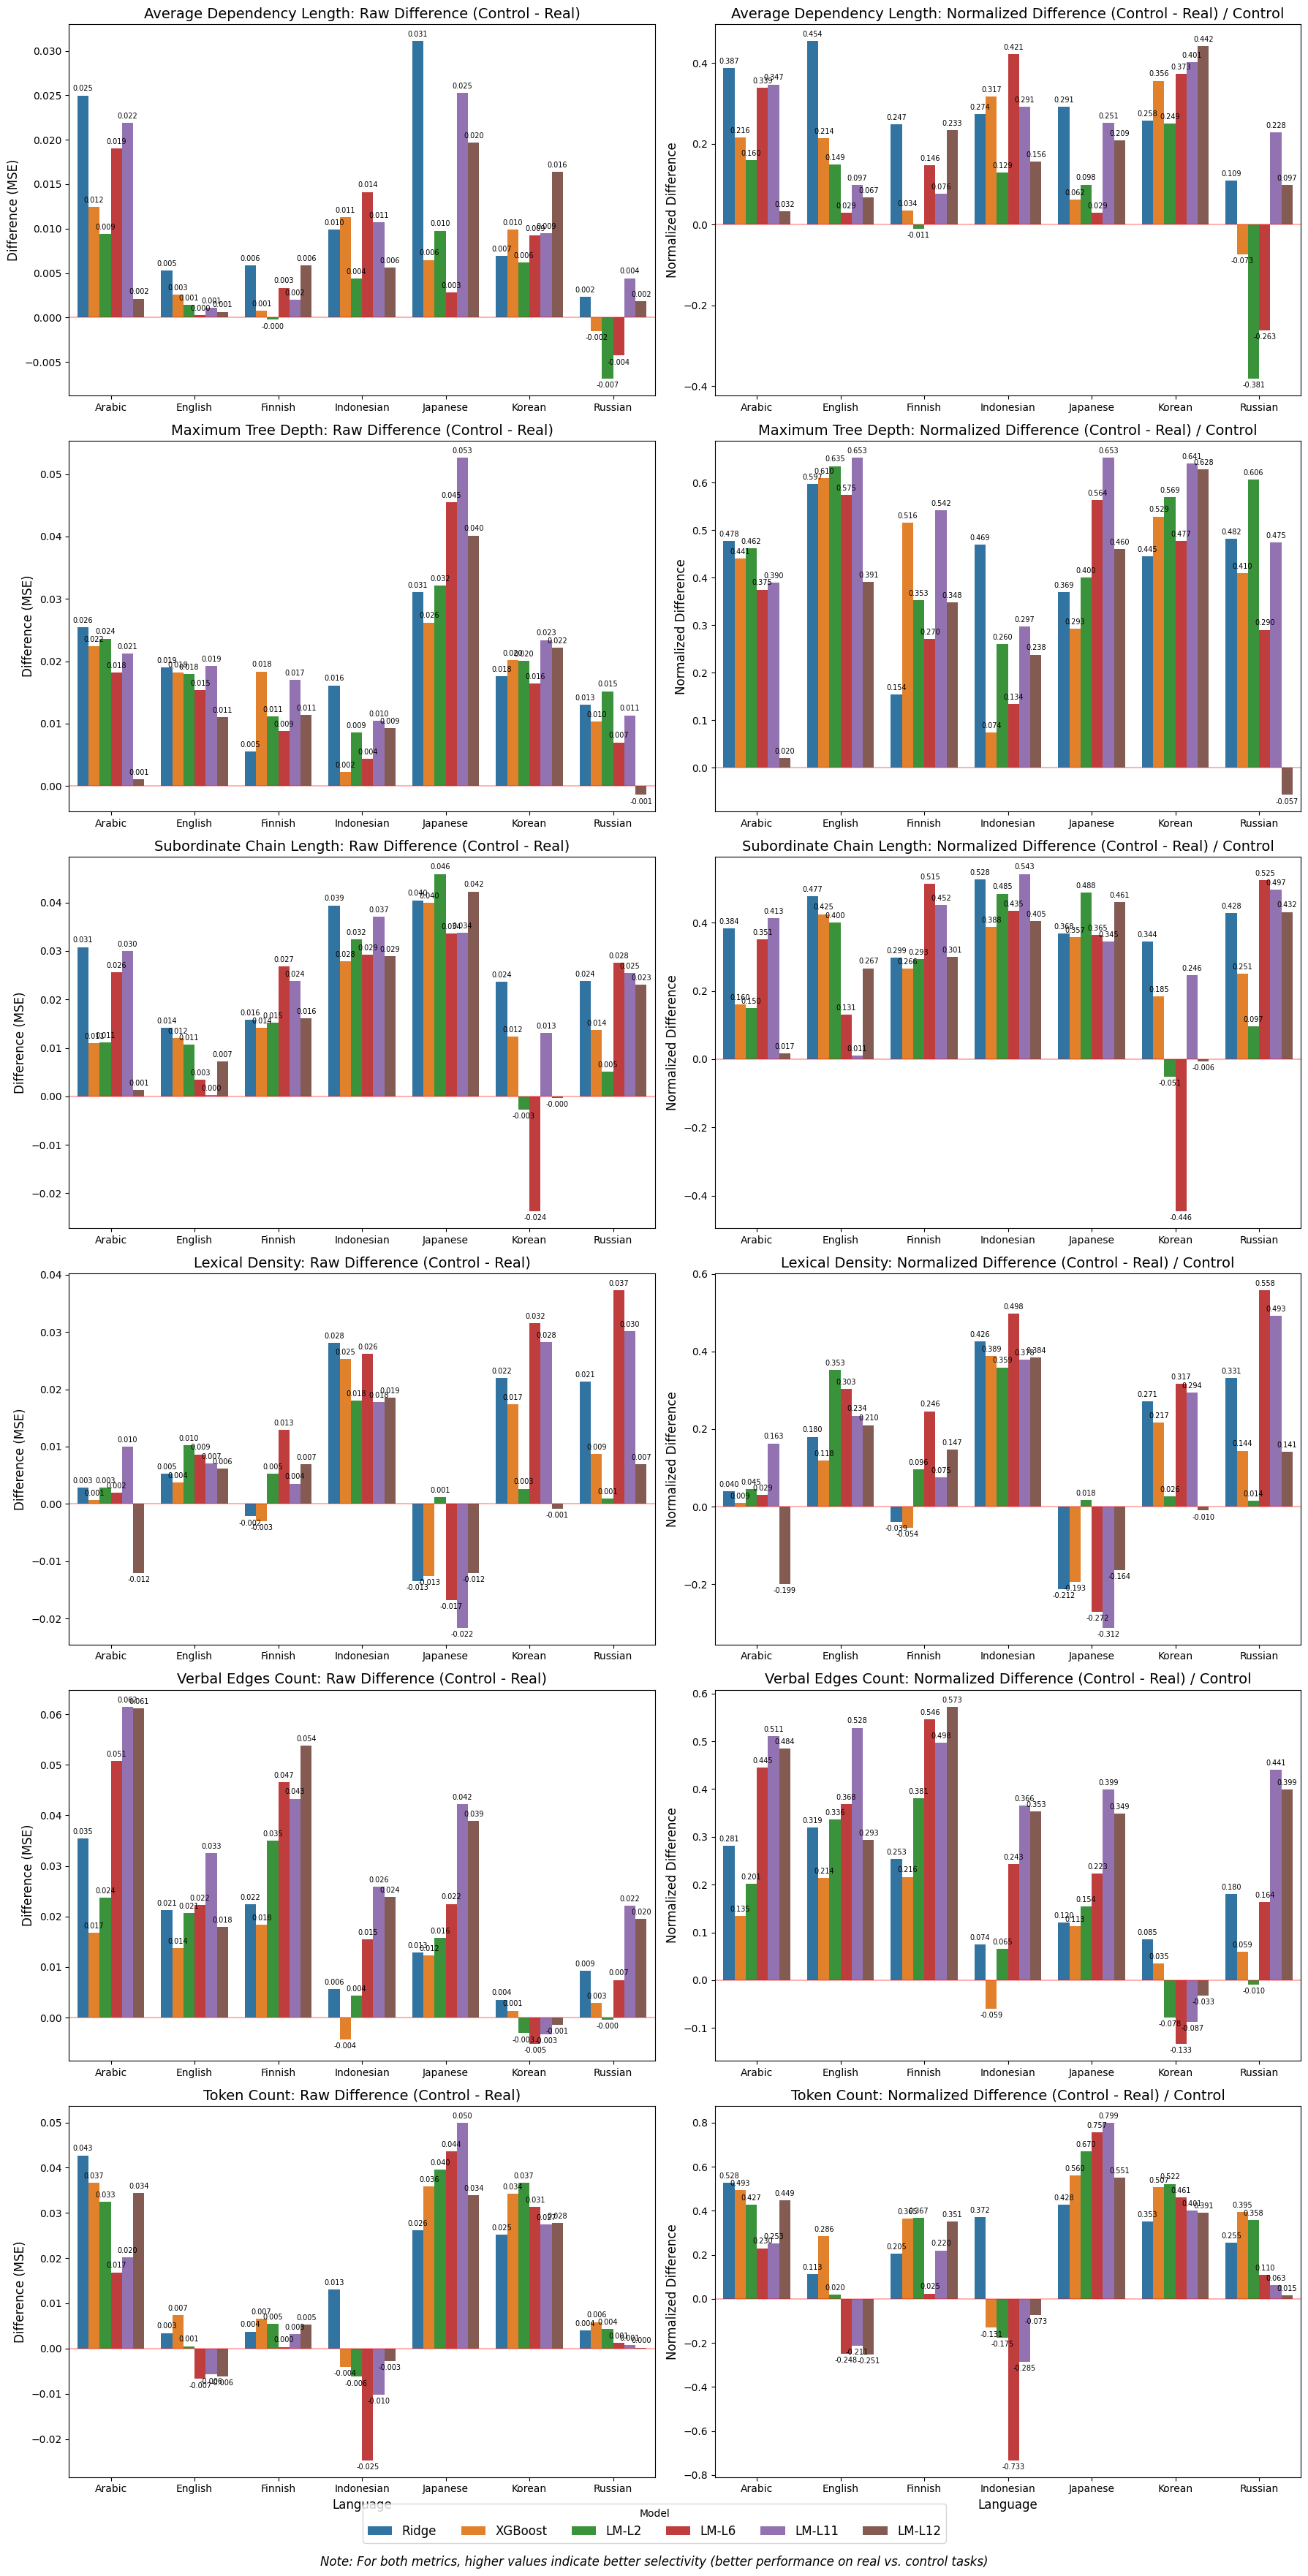

In [18]:
def plot_submetric_selectivity_comparisons():
 
    # Define models and their base paths
    models = [
        ('Ridge', '/home/robin/Research/qtype-eval/scripts/analysis/complexity_Ridge'),
        ('XGBoost', '/home/robin/Research/qtype-eval/scripts/analysis/complexity_XGBRegressor'),
        ('LM-L2', '/home/robin/Research/qtype-eval/scripts/analysis/single_submetric_lm_probe_mse_test'),
        ('LM-L6', '/home/robin/Research/qtype-eval/scripts/analysis/single_submetric_lm_probe_mse_test'),
        ('LM-L11', '/home/robin/Research/qtype-eval/scripts/analysis/single_submetric_lm_probe_mse_test'),
        ('LM-L12', '/home/robin/Research/qtype-eval/scripts/analysis/single_submetric_lm_probe_mse_test'),
    ]
    
    # Define submetrics based on actual file names
    submetrics = [
        'avg_links_len',
        'avg_max_depth',
        'avg_subordinate_chain_len',
        'lexical_density',
        'avg_verb_edges',
        'n_tokens'
    ]
    
    # Pretty names for display
    submetric_display_names = {
        'avg_links_len': 'Average Dependency Length',
        'avg_max_depth': 'Maximum Tree Depth',
        'avg_subordinate_chain_len': 'Subordinate Chain Length',
        'lexical_density': 'Lexical Density',
        'avg_verb_edges': 'Verbal Edges Count',
        'n_tokens': 'Token Count'
    }
    
    all_metrics_data = []
    
    for model_name, base_path in models:
        for submetric in submetrics:
            if 'lm_probe' in base_path:
                layer_num = model_name.split('-')[1][1:] 
                file_path = f"{base_path}_{submetric}_layer{layer_num}_table.csv"
            else:
                file_path = f"{base_path}_mse_test_{submetric}_table.csv"
            
            df = safe_read_csv(file_path)
            
            if df.empty or not all(col in df.columns for col in ['language', 'real', 'control1', 'control2', 'control3']):
                print(f"Warning: Could not load data for {model_name}, submetric {submetric} from {file_path}")
                continue
                
            df['language'] = df['language'].map(lambda x: LANGUAGE_NAMES.get(x, x))
            
            for _, row in df.iterrows():
                real = row['real']
                controls = [row['control1'], row['control2'], row['control3']]
                control_mean = np.mean(controls)
                
                raw_diff = control_mean - real
                norm_diff = (control_mean - real) / control_mean if control_mean != 0 else np.nan
                
                all_metrics_data.append({
                    'Language': row['language'],
                    'Model': model_name,
                    'Submetric': submetric,
                    'Real_MSE': real,
                    'Control_MSE': control_mean,
                    'Raw_Difference': raw_diff,
                    'Normalized_Difference': norm_diff
                })
    
    if not all_metrics_data:
        print("Error: No data could be loaded. Please check the file paths.")
        return None, None
    
    all_metrics_df = pd.DataFrame(all_metrics_data)
    
    loaded_submetrics = all_metrics_df['Submetric'].unique()
    
    if len(loaded_submetrics) == 0:
        print("Error: No submetrics could be loaded.")
        return None, None
    
    fig, axes = plt.subplots(len(loaded_submetrics), 2, figsize=(18, 6*len(loaded_submetrics)), 
                          gridspec_kw={'height_ratios': [1] * len(loaded_submetrics)})
    
    if len(loaded_submetrics) == 1:
        axes = axes.reshape(1, 2)
    
    for i, submetric in enumerate(loaded_submetrics):
        submetric_df = all_metrics_df[all_metrics_df['Submetric'] == submetric]
            
        display_name = submetric_display_names.get(submetric, submetric)
        
        metric = 'Raw_Difference'
        ax_plot = axes[i, 0]
        
        sns.barplot(x='Language', y=metric, hue='Model', data=submetric_df, ax=ax_plot)
        ax_plot.set_title(f'{display_name}: Raw Difference (Control - Real)', fontsize=14)
        ax_plot.set_ylabel('Difference (MSE)', fontsize=12)
        ax_plot.axhline(y=0, color='r', linestyle='-', alpha=0.3)
        
        if i < len(loaded_submetrics) - 1:
            ax_plot.set_xlabel('')
        else:
            ax_plot.set_xlabel('Language', fontsize=12)
        
        for container in ax_plot.containers:
            ax_plot.bar_label(container, fmt='%.3f', padding=3, fontsize=7)
        
        ax_plot.get_legend().remove()
        
        metric = 'Normalized_Difference'
        ax_plot = axes[i, 1]
        
        sns.barplot(x='Language', y=metric, hue='Model', data=submetric_df, ax=ax_plot)
        ax_plot.set_title(f'{display_name}: Normalized Difference (Control - Real) / Control', fontsize=14)
        ax_plot.set_ylabel('Normalized Difference', fontsize=12)
        ax_plot.axhline(y=0, color='r', linestyle='-', alpha=0.3)
        
        if i < len(loaded_submetrics) - 1:
            ax_plot.set_xlabel('')
        else:
            ax_plot.set_xlabel('Language', fontsize=12)
        
        for container in ax_plot.containers:
            ax_plot.bar_label(container, fmt='%.3f', padding=3, fontsize=7)
        
        ax_plot.get_legend().remove()
    
    handles, labels = axes[0, 0].get_legend_handles_labels()
    fig.legend(handles, labels, title='Model', loc='lower center', 
              bbox_to_anchor=(0.5, 0.01), ncol=len(models), fontsize=12)
    
    fig.text(0.5, 0.005, 'Note: For both metrics, higher values indicate better selectivity (better performance on real vs. control tasks)', ha='center', va='center', fontsize=12, style='italic')
    
    plt.tight_layout(rect=[0, 0.02, 1, 0.98])
    
    try:
        plt.savefig('submetric_selectivity_comparison.png', dpi=150, bbox_inches='tight')
        print("Submetric selectivity comparison saved as 'submetric_selectivity_comparison.png'")
    except Exception as e:
        print(f"Error saving plot: {e}")
        
    for submetric in loaded_submetrics:
        submetric_df = all_metrics_df[all_metrics_df['Submetric'] == submetric]
            
        display_name = submetric_display_names.get(submetric, submetric)
        
        fig_sub, axes_sub = plt.subplots(1, 2, figsize=(16, 6))
        
        sns.barplot(x='Language', y='Raw_Difference', hue='Model', data=submetric_df, ax=axes_sub[0])
        axes_sub[0].set_title(f'{display_name}: Raw Difference (Control - Real)', fontsize=14)
        axes_sub[0].set_ylabel('Difference (MSE)', fontsize=12)
        axes_sub[0].set_xlabel('Language', fontsize=12)
        axes_sub[0].axhline(y=0, color='r', linestyle='-', alpha=0.3)
        for container in axes_sub[0].containers:
            axes_sub[0].bar_label(container, fmt='%.3f', padding=3, fontsize=8)
        axes_sub[0].get_legend().remove()
        
        sns.barplot(x='Language', y='Normalized_Difference', hue='Model', data=submetric_df, ax=axes_sub[1])
        axes_sub[1].set_title(f'{display_name}: Normalized Difference (Control - Real) / Control', fontsize=14)
        axes_sub[1].set_ylabel('Normalized Difference', fontsize=12)
        axes_sub[1].set_xlabel('Language', fontsize=12)
        axes_sub[1].axhline(y=0, color='r', linestyle='-', alpha=0.3)
        for container in axes_sub[1].containers:
            axes_sub[1].bar_label(container, fmt='%.3f', padding=3, fontsize=8)
        
        handles, labels = axes_sub[1].get_legend_handles_labels()
        axes_sub[1].get_legend().remove()
        fig_sub.legend(handles, labels, title='Model', loc='lower center', 
                    bbox_to_anchor=(0.5, 0), ncol=len(models), fontsize=10)
        
        plt.tight_layout(rect=[0, 0.05, 1, 0.95])
        try:
            plt.savefig(f'submetric_{submetric}_comparison.png', dpi=200, bbox_inches='tight')
            print(f"Individual plot for {display_name} saved")
        except Exception as e:
            print(f"Error saving individual plot for {submetric}: {e}")
        
        plt.close(fig_sub)
    
    try:
        all_metrics_df.to_csv('submetric_selectivity_data.csv', index=False)
        print("Submetric metrics data saved as 'submetric_selectivity_data.csv'")
    except Exception as e:
        print(f"Error saving CSV: {e}")
    
    return fig, all_metrics_df

plot_submetric_selectivity_comparisons()